In [0]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import splrep, splev
import datetime as dt
import matplotlib.pyplot as plt
from fbprophet import Prophet
from scipy.interpolate import InterpolatedUnivariateSpline
%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [0]:
def smape(satellite_predicted_values, satellite_true_values):
    # the division, addition and subtraction are pointwise
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values)/
                (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))


def drop_close(t, x, eps=10**9):
    '''
    t = time array, x = data array, eps is in nanoseconds
    Returns entries in t,x with corresponding consecutive times > eps
    
    '''
    t = np.array(t) #if not already np array, convert
    x = np.array(x) #if t or x are pandas Series, will have dimension mismatch
    far = np.concatenate([(t[1:] - t[:-1]) > eps, [True]])
    return t[far], x[far]


def resample(t, x, step=10 * 10**9, t_new=None, return_t=False):
    '''
    t: time array (or series); 
    x: data array (or series); 
    t_new: new time scale from start to end of t with step size step;
    step: = 10 seconds by default; 
    return_t: by default, do not return resampled times
    
    resample time series or array by 10 (default) sec intervals and 
    return new time series (if t_new=True) and spline approximation series for data
    
    
    '''
    t, x = drop_close(t, x)
    if t_new is None:
        t_new = np.arange(t[0], t[-1], step)
    try:
        spl = splrep(t, x)
        x_new = splev(t_new, spl)
    except:
        raise ValueError(f'interpolation error, x length = {len(x)}, \
        t_new length = {len(t_new)}')

    return (t_new, x_new) if return_t else x_new


def get_peaks(array):
    '''
    returns index of "sharp" peaks, excluding first and last values of array
    
    index of "smooth peaks", e.g. 1 2 3 9 9 3 2 1, is not returned
    '''
    return np.where((array[1:-1] > array[2:]) & (array[1:-1] > array[:-2]))[0] + 1


def get_satellite_data(data, sat_id):
    '''
    returns all data for particular satellite by id
    '''
    return data[data['sat_id'] == sat_id].reset_index(drop=True)


def remove_time_jumps(satellite_data, features_list=('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                      suffix='_jumps_removed',time_threshold = 0.00003):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    '''
    satellite_data['t'] = ((pd.to_datetime(satellite_data['epoch']) - pd.to_datetime(satellite_data['epoch'])[0]) /
                           np.timedelta64(1, 'D')).astype(float)
    satellite_data['dt'] = satellite_data['t'].diff()
    # the most frequent time interval
    t_standard = satellite_data['dt'].value_counts().index[0]

    # time steps used for simulations
    satellite_data['t_sim'] = satellite_data.index.values * t_standard

    n = satellite_data.shape[0]
    corrected_features = []
    for feature_name in features_list:
        corrected_feature = [0] * n
        corrected_feature[0] = satellite_data[feature_name][0]

        feature = satellite_data[feature_name]

        for j in range(1, n - 1):
            if satellite_data.t[j] < satellite_data.t_sim[j] - time_threshold:
                # approximate by the left side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] < satellite_data.t_sim[j - step] - time_threshold:
                    step += 1
                #             print(step)
                corrected_feature[j] = feature[j - step] - (satellite_data.t_sim[j - step] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j - step] - satellite_data.t_sim[j - step - 1]) * (
                                              feature[j - step] - feature[j - step - 1])
            elif satellite_data.t[j] > satellite_data.t_sim[j] + time_threshold:
                # approximate by the right side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] > satellite_data.t_sim[j + step] + time_threshold:
                    step += 1
    
                corrected_feature[j] = feature[j + step + 1] - (satellite_data.t_sim[j + step + 1] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j + step + 1] - satellite_data.t_sim[j + step]) * (
                                              feature[j + step + 1] - feature[j + step])
            else:
                corrected_feature[j] = feature[j]
    
        corrected_feature[n - 1] = feature[n - 1] + corrected_feature[n - 2] - feature[n - 2]
        corrected_features.append(corrected_feature)
    return pd.DataFrame(corrected_features, index=[f + suffix for f in features_list]).T

In [0]:
def insert_previous_and_shift(df,col_name,ind):
    '''
    input a data frame (df), column name (col_name), and index (ind)
    insert previous value of df[col_name] at index and shift the rest 
    of df[col_name] from ind by +1;
    This is used for remove_time_jumps_fast
    '''
    shifted_series = df[col_name].shift(1)
    df[col_name].iloc[ind] = df[col_name].iloc[ind-1]
    df[col_name].iloc[ind+1:] = shifted_series.iloc[ind+1:]
    return df

In [0]:
def remove_time_jumps_fast(data, features_list=
                           ('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                           threshold = 0.000001):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    s_data = satellite data
    the features are replaced by the correction
    note that threshold here is not the same as in remove_time_jumps
    '''
    data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                               np.timedelta64(1, 'D')).astype(float)
    data['dt'] = data['t'].diff(1)

    index_for_correction = data[data['dt'] < threshold].index 
    #print(index_for_correction)
    if list(index_for_correction): #if non empty
        for feature in features_list:
            for i in index_for_correction:
                data = insert_previous_and_shift(data,feature,i)
    return data

## Transforming all the data

In [0]:
import utils
from LinearAlignment import LinearAlignment

In [0]:
features_list=['x', 'y', 'z', 'Vx', 'Vy', 'Vz']

In [10]:
data = pd.read_csv('train.csv')
data['time'] = data['epoch']
data['epoch'] = pd.to_datetime(data['epoch']).values.astype(float)
data.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,time
0,0,1.388534e+18,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,2014-01-01T00:00:00.000
1,1,1.388537e+18,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,2014-01-01T00:46:43.000
2,2,1.388540e+18,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,2014-01-01T01:33:26.001
3,3,1.388543e+18,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,2014-01-01T02:20:09.001
4,4,1.388546e+18,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,2014-01-01T03:06:52.002


In [11]:
result_df = []
alignment_model = LinearAlignment()

satellites_list = data['sat_id'].unique()

transf_df = pd.DataFrame([])
for sat_id in tqdm(satellites_list):
    
#     sat_data = utils.get_satellite_data(data, sat_id)
    try:
        sat_data = remove_time_jumps_fast(get_satellite_data(data, sat_id))
#         sat_data = get_satellite_data(data, sat_id) # run to check the smape score before any transformations
    except KeyError as e:
        print(f'jump removal failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue

    n_train = 2*len(sat_data) // 3
    train_sat_data = sat_data[:n_train]
    
    pred = pd.DataFrame(index = sat_data.index)
    pred['epoch'] = sat_data['epoch'].values
    pred['t'] = sat_data['t'].values
    pred['sat_id'] = sat_id
    
    try:

        for feature_name in features_list:
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x=-train_sat_data[f'{feature_name}_sim'].values,
                                gt=-train_sat_data[feature_name].values)
            option1 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x= train_sat_data[f'{feature_name}_sim'].values,
                                gt= train_sat_data[feature_name].values)
            
            option2 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            
            if utils.smape(option1,sat_data[feature_name].values) < utils.smape(option2,sat_data[feature_name].values):
                pred[f'{feature_name}_sim']  = option1
            else:
                pred[f'{feature_name}_sim']  = option2
                
            pred[feature_name]=sat_data[feature_name].values
        
                  
            
    except Exception as e:
        print(f'linear alignment failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    
    transf_df = transf_df.append(pred)

  0%|          | 0/600 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 600/600 [03:06<00:00,  2.89it/s]


In [14]:
transf_df.head()

,epoch,t,sat_id,x_sim,x,y_sim,y,z_sim,z,Vx_sim,Vx,Vy_sim,Vy,Vz_sim,Vz
0,1.388534e+18,0.000000,0,-8843.131454,-8855.823863,13138.221690,13117.780146,-20741.615306,-20728.353233,-0.907527,-0.908303,-3.804930,-3.808436,-2.024133,-2.022083
1,1.388537e+18,0.032442,0,-10555.386608,-10567.672384,1650.859396,1619.746066,-24472.868840,-24451.813271,-0.303784,-0.302590,-4.269805,-4.272617,-0.616663,-0.612796
2,1.388540e+18,0.064884,0,-10572.066874,-10578.684043,-10142.955312,-10180.467460,-24271.694509,-24238.280949,0.274744,0.277435,-4.046917,-4.047522,0.718442,0.723155
3,1.388543e+18,0.097326,0,-9150.440291,-9148.251857,-20614.468040,-20651.437460,-20766.919757,-20720.381279,0.712297,0.715600,-3.375518,-3.373762,1.717976,1.722115
4,1.388546e+18,0.129769,0,-6730.875258,-6719.092336,-28898.551349,-28929.061629,-14995.852194,-14938.907967,0.989275,0.992507,-2.523080,-2.519732,2.341988,2.344703


In [15]:
transf_df.shape

(649912, 15)

In [0]:
# # for now, simply append non-transformed values fot the satellites 252
# transf_df = transf_df.append(remove_time_jumps_fast(get_satellite_data(data, 252))[transf_df.columns])
# transf_df = transf_df.append(remove_time_jumps_fast(get_satellite_data(data, 301))[transf_df.columns])
# transf_df.shape

(650105, 15)

In [16]:
fail_list = []
satellites_list = transf_df['sat_id'].unique()

for sat_id in tqdm(satellites_list):
    pred = pd.DataFrame([])
    sat_data = transf_df[transf_df.sat_id == sat_id]

    n_train = 2* len(sat_data) // 3
   
    
    try:

        for feature_name in features_list:
            
            q = InterpolatedUnivariateSpline(sat_data ['t'], sat_data ['Vx']).roots()
            T = (q[2]-q[0])
            
            # create a DataFrame for prophet model()
            ts = pd.DataFrame([])
            ts['ds'] = pd.to_datetime(sat_data ['epoch']).values
            ts['y'] = sat_data [feature_name].values-sat_data [f'{feature_name}_sim'].values
            
            # define the time frame for the forecast 
            future =ts[n_train:] [['ds']]
            
            # define the model
            m = Prophet(changepoint_prior_scale = 0.01,
            weekly_seasonality = False,
            yearly_seasonality = False).add_seasonality(name='grid', period = T, fourier_order=50)
            
            #fit the model and make the forecast
            m.fit(ts[:n_train])
            forecast = m.predict(future)
            
            new_values = sat_data.loc[n_train:,f'{feature_name}_sim'].values+forecast.loc[:, 'yhat'].values

            option1 = sat_data[f'{feature_name}_sim'].values


            option2 = np.concatenate((sat_data[f'{feature_name}_sim'].values[:n_train], new_values), axis=None)


            print('{}[{}]  no correction: {}, correction:{}'.format(sat_id,
                                                                feature_name,
                                                                utils.smape(option1[n_train:],sat_data[feature_name][n_train:].values),
                                                                utils.smape(option2[n_train:],sat_data[feature_name][n_train:].values)))

            if utils.smape(option1[n_train:],sat_data[feature_name][n_train:].values) < utils.smape(option2[n_train:],sat_data[feature_name][n_train:].values):
                pred[feature_name] = option1
                print(sat_id, feature_name, 'does not work')
                fail_list.append((sat_id, feature_name))
            else:
                pred[feature_name] = option2     
 
            
    except Exception as e:
        print(f'phophet failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
        
    sat_sim_smape = utils.smape(sat_data.loc[n_train:, [f'{f}_sim' for f in features_list]].values,
                                sat_data.loc[n_train:, features_list].values)
    sat_new_smape = utils.smape(pred.loc[n_train:, features_list].values,
                                sat_data.loc[n_train:, features_list].values)
    result_df.append([sat_id, sat_sim_smape, sat_new_smape])

  0%|          | 0/600 [00:00<?, ?it/s]INFO:numexpr.utils:NumExpr defaulting to 2 threads.


0[x]  no correction: 0.002019949873584064, correction:0.000175179872617657
0[y]  no correction: 0.0004479225491172193, correction:0.00037944603603242463
0[z]  no correction: 0.0017280662374283356, correction:0.00022093656705430794
0[Vx]  no correction: 0.0009027952464898022, correction:0.00015864039532040636
0[Vy]  no correction: 0.0012632326676549502, correction:0.0005183769236656172


  0%|          | 1/600 [00:31<5:12:31, 31.30s/it]

0[Vz]  no correction: 0.001026267099375352, correction:0.0001905033667833676
1[x]  no correction: 0.19789230218414136, correction:0.026488975700141366
1[y]  no correction: 0.17379991709944773, correction:0.0861664769647062
1[z]  no correction: 0.15211767651014504, correction:0.11543476227761627
1[Vx]  no correction: 0.1866958779440588, correction:0.16553311144892083
1[Vy]  no correction: 0.15872449315519707, correction:0.10989095690687375


  0%|          | 2/600 [00:56<4:54:49, 29.58s/it]

1[Vz]  no correction: 0.1527931186815064, correction:0.11083275830249971
2[x]  no correction: 0.006831628265958696, correction:0.003134926582162182
2[y]  no correction: 0.014486183231356259, correction:0.0098057041236803
2[z]  no correction: 0.013740337241424407, correction:0.006999499648732501
2[Vx]  no correction: 0.0052801361614420155, correction:0.003146664486918086
2[Vy]  no correction: 0.0034801582687186377, correction:0.0033930432061423637


  0%|          | 3/600 [01:19<4:32:21, 27.37s/it]

2[Vz]  no correction: 0.005305657707651197, correction:0.0029269720954119517
3[x]  no correction: 0.006042744979714416, correction:0.003516140742180783
3[y]  no correction: 0.008444692834013966, correction:0.003531228332075882
3[z]  no correction: 0.06294194113219709, correction:0.015365345252197923
3[Vx]  no correction: 0.00566202150756282, correction:0.003164416816404807
3[Vy]  no correction: 0.005531362182074871, correction:0.00302884619864345


  1%|          | 4/600 [01:37<4:05:47, 24.74s/it]

3[Vz]  no correction: 0.03602083793947985, correction:0.012455911518097633
4[x]  no correction: 0.002804515512293963, correction:0.00019815675438566662
4[y]  no correction: 0.005382163302543501, correction:0.0006688402242891131
4[z]  no correction: 0.0013810737364457334, correction:9.428767733998983e-05
4[Vx]  no correction: 0.001108941955367948, correction:0.00013746767197725339
4[Vy]  no correction: 0.001268796853998633, correction:0.00018347462169886317


  1%|          | 5/600 [02:17<4:49:47, 29.22s/it]

4[Vz]  no correction: 0.0009560783110669585, correction:0.00011051381440864622
5[x]  no correction: 0.002748611291940033, correction:0.00023590325432948876
5[y]  no correction: 0.0003287371352047416, correction:0.00014682865613812704
5[z]  no correction: 0.003211336937419437, correction:0.002863947692332014
5[Vx]  no correction: 0.0003941236628613481, correction:0.0001446858600065564
5[Vy]  no correction: 0.0009283196197869395, correction:0.00012764180607003793


  1%|          | 6/600 [02:49<4:58:45, 30.18s/it]

5[Vz]  no correction: 0.002602664648923957, correction:0.002616165911172226
5 Vz does not work
6[x]  no correction: 0.42641369643453003, correction:0.07943305536436436
6[y]  no correction: 0.20043361933597656, correction:0.1864431767629884
6[z]  no correction: 0.3291172839570742, correction:0.10766182590889838
6[Vx]  no correction: 0.34954406975308383, correction:0.28129104310381664
6[Vy]  no correction: 0.23402892971800046, correction:0.17295882486968636


  1%|          | 7/600 [03:07<4:21:27, 26.45s/it]

6[Vz]  no correction: 0.2392956246706033, correction:0.15966699308673793
7[x]  no correction: 0.015073541128282249, correction:0.0315564752289842
7 x does not work
7[y]  no correction: 0.031543159303322826, correction:0.0272632895232024
7[z]  no correction: 0.019012972043139755, correction:0.023039216993909158
7 z does not work
7[Vx]  no correction: 0.03214408446859192, correction:0.09417288344984405
7 Vx does not work
7[Vy]  no correction: 0.06692071515901103, correction:0.11477549970418664
7 Vy does not work


  1%|▏         | 8/600 [03:19<3:38:56, 22.19s/it]

7[Vz]  no correction: 0.03454367707853033, correction:0.11683396201775569
7 Vz does not work
8[x]  no correction: 0.035569721516328756, correction:0.00017979566067167168
8[y]  no correction: 0.061375613032869404, correction:0.0007285451322488196
8[z]  no correction: 0.0971984433423835, correction:0.0010022582453814836
8[Vx]  no correction: 0.07034148229212532, correction:0.0007749869047188313
8[Vy]  no correction: 0.030512481770238752, correction:0.0003941332567278076


  2%|▏         | 9/600 [05:24<8:40:09, 52.81s/it]

8[Vz]  no correction: 0.04852333834855964, correction:0.0003445968125187667
9[x]  no correction: 0.07035945711419962, correction:0.0033976000005064904
9[y]  no correction: 0.07154642357356851, correction:0.013935801759168717
9[z]  no correction: 0.08965738431595427, correction:0.020500119254600116
9[Vx]  no correction: 0.09899988392963151, correction:0.019408204408068022
9[Vy]  no correction: 0.030310759708830123, correction:0.006081962254017417


  2%|▏         | 10/600 [05:45<7:07:00, 43.42s/it]

9[Vz]  no correction: 0.07162089644617552, correction:0.015243793864561343
10[x]  no correction: 0.007688189935980414, correction:0.0017634726269817656
10[y]  no correction: 0.00295435555156082, correction:0.0006187748757712584
10[z]  no correction: 0.002596802707602965, correction:0.0007669062360092921
10[Vx]  no correction: 0.0027345611902084782, correction:0.0003421227738351281
10[Vy]  no correction: 0.0032848327813939245, correction:0.00038472884919923283


  2%|▏         | 11/600 [06:33<7:20:02, 44.83s/it]

10[Vz]  no correction: 0.0018315017940827203, correction:0.0004862041090254555
11[x]  no correction: 0.3955298846712038, correction:0.3075682464099149
11[y]  no correction: 0.29877449508569226, correction:0.33220983788961117
11 y does not work
11[z]  no correction: 0.2819623042106356, correction:0.32448763837001277
11 z does not work
11[Vx]  no correction: 0.4398793780637433, correction:0.4242946630469298
11[Vy]  no correction: 0.22970794524565172, correction:0.29566223485522614
11 Vy does not work


  2%|▏         | 12/600 [06:58<6:20:07, 38.79s/it]

11[Vz]  no correction: 0.2672973075429962, correction:0.32214289143772346
11 Vz does not work
12[x]  no correction: 0.004214688565613107, correction:0.0014307344991027558
12[y]  no correction: 0.003718368767615762, correction:0.001878074934421941
12[z]  no correction: 0.0034747640384872867, correction:0.0018645393489150005
12[Vx]  no correction: 0.011982955475740355, correction:0.002001580764967772
12[Vy]  no correction: 0.0032342250762420442, correction:0.0016860804398732769


  2%|▏         | 13/600 [07:15<5:16:43, 32.37s/it]

12[Vz]  no correction: 0.0036418879405086015, correction:0.0015575760257103754
13[x]  no correction: 0.00255170106370611, correction:0.00021525980222688906
13[y]  no correction: 0.009256885267482468, correction:0.0021694115130165277
13[z]  no correction: 0.0045388393689079955, correction:0.0005694378026052015
13[Vx]  no correction: 0.0020134088770664693, correction:0.000463729287691818
13[Vy]  no correction: 0.0032859865573718035, correction:0.0005598828294392787


  2%|▏         | 14/600 [07:44<5:06:33, 31.39s/it]

13[Vz]  no correction: 0.003990270992787141, correction:0.0020018282721293566
14[x]  no correction: 0.061064429810258176, correction:0.04277744688963689
14[y]  no correction: 0.019142540744356836, correction:0.008419876447570036
14[z]  no correction: 0.07066626864321726, correction:0.03673371195556929
14[Vx]  no correction: 0.027314135256765775, correction:0.01535854200817197
14[Vy]  no correction: 0.031229671208253262, correction:0.022464088850669427


  2%|▎         | 15/600 [08:05<4:33:10, 28.02s/it]

14[Vz]  no correction: 0.052124368444151976, correction:0.028594457906721868
15[x]  no correction: 0.02442503444913969, correction:0.016055168496784525
15[y]  no correction: 0.010486616681330177, correction:0.015701491483415285
15 y does not work
15[z]  no correction: 0.021812384562674984, correction:0.017093186765573972
15[Vx]  no correction: 0.01196039310998516, correction:0.016866754622563488
15 Vx does not work
15[Vy]  no correction: 0.009121751463542185, correction:0.016498578546905382
15 Vy does not work


  3%|▎         | 16/600 [08:33<4:34:38, 28.22s/it]

15[Vz]  no correction: 0.026242134831735816, correction:0.033840180742338806
15 Vz does not work
16[x]  no correction: 0.05982249589893266, correction:0.01343563466869235
16[y]  no correction: 0.02793605812639504, correction:0.06425828838130897
16 y does not work
16[z]  no correction: 0.023947722524687524, correction:0.02023737257705941
16[Vx]  no correction: 0.014758198209773818, correction:0.02921735441594756
16 Vx does not work
16[Vy]  no correction: 0.036352134774715765, correction:0.021448989833644964


  3%|▎         | 17/600 [08:45<3:45:22, 23.19s/it]

16[Vz]  no correction: 0.02092923216598935, correction:0.01802639574254697
17[x]  no correction: 0.003915764597934331, correction:0.0016953638734883922
17[y]  no correction: 0.0023090777020684625, correction:0.0018438316077531564
17[z]  no correction: 0.0015703742585646595, correction:0.0009384483471686908
17[Vx]  no correction: 0.05792888127814252, correction:0.00906844469936372
17[Vy]  no correction: 0.0024020534315415706, correction:0.0013456395624519178


  3%|▎         | 18/600 [09:18<4:15:44, 26.37s/it]

17[Vz]  no correction: 0.00607249685319445, correction:0.0020800679646882326
18[x]  no correction: 0.0014211168216752012, correction:0.0013831456698564437
18[y]  no correction: 0.018900055730492797, correction:0.004492274051769774
18[z]  no correction: 0.002496845245995635, correction:0.0033862149497242613
18 z does not work
18[Vx]  no correction: 0.002254328143720483, correction:0.0020905121243017357
18[Vy]  no correction: 0.0007489363860214922, correction:0.0028484582578770503
18 Vy does not work


  3%|▎         | 19/600 [10:00<5:00:09, 31.00s/it]

18[Vz]  no correction: 0.0017463363867886402, correction:0.007386190869829122
18 Vz does not work
19[x]  no correction: 0.0029066778190300754, correction:0.00044103734052798827
19[y]  no correction: 0.011189667557916819, correction:0.00046988896089543517
19[z]  no correction: 0.0014909620879096312, correction:0.0005557651418221462
19[Vx]  no correction: 0.001972925026762013, correction:0.0003089810375786805
19[Vy]  no correction: 0.011396936765944768, correction:0.0007848348105759119


  3%|▎         | 20/600 [10:20<4:25:59, 27.52s/it]WARNING:fbprophet:Optimization terminated abnormally. Falling back to Newton.


19[Vz]  no correction: 0.0027610343832613444, correction:0.00041900172932655315
20[x]  no correction: 0.1189836256485341, correction:0.10755134624582259
20[y]  no correction: 0.11471827764211531, correction:0.049975951021977424
20[z]  no correction: 0.20040828780809788, correction:0.15512583393612545


20[Vx]  no correction: 0.10453551560478687, correction:0.23664673984024254
20 Vx does not work
20[Vy]  no correction: 0.6512199751981743, correction:0.5909337238410969


  4%|▎         | 21/600 [10:37<3:57:26, 24.61s/it]

20[Vz]  no correction: 0.5582220062156765, correction:0.5580986113377661
21[x]  no correction: 0.06123258196328543, correction:0.014537305312428396
21[y]  no correction: 0.05367661449101752, correction:0.029892392860002278
21[z]  no correction: 0.13067958265987833, correction:0.03207929731145877
21[Vx]  no correction: 0.07454123936158984, correction:0.06162044312110779
21[Vy]  no correction: 0.0414711834241359, correction:0.03099135160542734


  4%|▎         | 22/600 [11:00<3:51:15, 24.01s/it]

21[Vz]  no correction: 0.13312665585487937, correction:0.03576629553371297


22[x]  no correction: 0.2814366513743946, correction:0.12763438928287296
22[y]  no correction: 0.09101449476493166, correction:0.07010748073250142


22[z]  no correction: 0.30860285585476155, correction:0.09279357687300745
22[Vx]  no correction: 0.263520869117027, correction:0.19464947505873234
22[Vy]  no correction: 0.12377806947737068, correction:0.09215892015020428


  4%|▍         | 23/600 [11:28<4:01:13, 25.08s/it]

22[Vz]  no correction: 0.2984176878276573, correction:0.25160157780944065
23[x]  no correction: 0.026645427524430505, correction:0.004051984092667422
23[y]  no correction: 0.013226703898685223, correction:0.004571150342665075
23[z]  no correction: 0.0329474208231554, correction:0.005527200980021603
23[Vx]  no correction: 0.007821541822019768, correction:0.0029930663523871194
23[Vy]  no correction: 0.010027267366239859, correction:0.002988232905474989


  4%|▍         | 24/600 [11:40<3:24:04, 21.26s/it]

23[Vz]  no correction: 0.014314362241620788, correction:0.0021722771398396544
24[x]  no correction: 0.00119998546540475, correction:0.002756124922212847
24 x does not work
24[y]  no correction: 0.002519921631214658, correction:0.0016950445218862813
24[z]  no correction: 0.02149930696043329, correction:0.015057127761608027
24[Vx]  no correction: 0.03408170918539628, correction:0.005306716268626885
24[Vy]  no correction: 0.022896943885360954, correction:0.009793946199345501


  4%|▍         | 25/600 [12:00<3:21:23, 21.02s/it]

24[Vz]  no correction: 0.0014780637341829058, correction:0.003184274388680741
24 Vz does not work
25[x]  no correction: 0.0012054883665223943, correction:0.0017202560720541893
25 x does not work
25[y]  no correction: 0.0016768959036729412, correction:0.0017187955293610604
25 y does not work
25[z]  no correction: 0.0029556706616563227, correction:0.0013401320208663269
25[Vx]  no correction: 0.002081548814271426, correction:0.001762544928631624
25[Vy]  no correction: 0.002439334856632743, correction:0.0016541594697409207


  4%|▍         | 26/600 [12:25<3:32:13, 22.18s/it]

25[Vz]  no correction: 0.0021921274617650896, correction:0.002028813680266633
26[x]  no correction: 0.47069386064513064, correction:0.7651931050178257
26 x does not work
26[y]  no correction: 0.3332421990504919, correction:0.8188407677175675
26 y does not work
26[z]  no correction: 0.4302076226189574, correction:0.8484320660059113
26 z does not work
26[Vx]  no correction: 0.3307855838835005, correction:0.9621938059131862
26 Vx does not work
26[Vy]  no correction: 0.3362499732043359, correction:0.8854603075252228
26 Vy does not work


  4%|▍         | 27/600 [14:52<9:29:25, 59.63s/it]

26[Vz]  no correction: 0.285022649514767, correction:0.9332014229505482
26 Vz does not work
27[x]  no correction: 0.010419931945129567, correction:0.0010909453566196167
27[y]  no correction: 0.0056612018635412, correction:0.000474993919984334
27[z]  no correction: 0.003616121464933688, correction:0.0008793602501475415
27[Vx]  no correction: 0.03569652755228486, correction:0.01531994992148791
27[Vy]  no correction: 0.03994691976298024, correction:0.005372972487424386


  5%|▍         | 28/600 [15:36<8:41:59, 54.75s/it]

27[Vz]  no correction: 0.040599352447829924, correction:0.005572659212937413
28[x]  no correction: 0.32161013202763017, correction:0.129071637915262
28[y]  no correction: 0.14330652978212885, correction:0.0795096827858001
28[z]  no correction: 0.36690490208481197, correction:0.2545313385099637
28[Vx]  no correction: 0.25338032288877166, correction:0.18928131880658555
28[Vy]  no correction: 0.16192591015892188, correction:0.11191265742261469


  5%|▍         | 29/600 [15:54<6:56:50, 43.80s/it]

28[Vz]  no correction: 0.368505226130695, correction:0.1967232449050441
29[x]  no correction: 0.016125508006037192, correction:0.0011641965978635988
29[y]  no correction: 0.02495079938919443, correction:0.0011123514674761827
29[z]  no correction: 0.016703729986084836, correction:0.0032194825510976723
29[Vx]  no correction: 0.6699312966306789, correction:0.6108574846297915
29[Vy]  no correction: 0.03563329870954734, correction:0.006662653997009123


  5%|▌         | 30/600 [16:14<5:47:32, 36.58s/it]

29[Vz]  no correction: 0.016659658041920055, correction:0.0036762967003831446
30[x]  no correction: 0.0004894532167627696, correction:0.0006711254714062806
30 x does not work
30[y]  no correction: 0.0006618917546040985, correction:0.0006270138550952786
30[z]  no correction: 0.003268639222697476, correction:0.000813515253348569
30[Vx]  no correction: 0.0002034941059285771, correction:0.000540596251055612
30 Vx does not work
30[Vy]  no correction: 0.00031370087520737, correction:0.0006012461708855714
30 Vy does not work


  5%|▌         | 31/600 [16:46<5:34:00, 35.22s/it]

30[Vz]  no correction: 0.002463344885112638, correction:0.00024808471721090685
31[x]  no correction: 0.2087327833139838, correction:0.12695151411663855
31[y]  no correction: 0.11418861386430669, correction:0.05604904361037922
31[z]  no correction: 0.24688984227051136, correction:0.07072306663901055
31[Vx]  no correction: 0.19925440490923751, correction:0.13956792722180367


31[Vy]  no correction: 0.11644038809349586, correction:0.10477146906270757


  5%|▌         | 32/600 [17:07<4:54:26, 31.10s/it]

31[Vz]  no correction: 0.20680565873122217, correction:0.15057497321181992
32[x]  no correction: 0.04365616144386877, correction:0.005162385564628327
32[y]  no correction: 0.01341406034469544, correction:0.0050150377070929475
32[z]  no correction: 0.05676765782828476, correction:0.008320005246927168
32[Vx]  no correction: 0.05998557688579679, correction:0.008602811788023482
32[Vy]  no correction: 0.021370212291164235, correction:0.006708316998636306


  6%|▌         | 33/600 [17:26<4:17:55, 27.29s/it]

32[Vz]  no correction: 0.06953906893434277, correction:0.01452220554860846
33[x]  no correction: 0.0008058165438415596, correction:0.00011453195695538003
33[y]  no correction: 0.024944763244943508, correction:0.011005122959385601
33[z]  no correction: 0.00845158887190029, correction:0.0008600477143443137
33[Vx]  no correction: 0.0005467439393229331, correction:0.0002607094518025647
33[Vy]  no correction: 0.04831350063812432, correction:0.027061983349567886


  6%|▌         | 34/600 [17:52<4:14:13, 26.95s/it]

33[Vz]  no correction: 0.0014392256218970691, correction:0.00020497146955069116
34[x]  no correction: 0.03755076216429738, correction:0.0018922571840438163
34[y]  no correction: 0.0041492202815028205, correction:0.002093495228743986
34[z]  no correction: 0.010316410713762138, correction:0.0009018596085069635
34[Vx]  no correction: 0.004855567275729759, correction:0.00038732468781537115
34[Vy]  no correction: 0.0032959992060798077, correction:0.001689332967794348


  6%|▌         | 35/600 [18:23<4:25:01, 28.14s/it]

34[Vz]  no correction: 0.003396333117610209, correction:0.0017724657459608703
35[x]  no correction: 0.6820345912451603, correction:0.16124112882283115
35[y]  no correction: 0.3829694092558852, correction:0.23751177591386785


35[z]  no correction: 0.6014605142676458, correction:0.24663248806795576
35[Vx]  no correction: 0.5860597326433518, correction:0.42034632307637515


35[Vy]  no correction: 0.33594711202124083, correction:0.31274160656432


  6%|▌         | 36/600 [18:50<4:22:41, 27.95s/it]

35[Vz]  no correction: 0.5635243577594116, correction:0.37548199358133555
36[x]  no correction: 0.0035120303613746483, correction:0.0034166998121153945
36[y]  no correction: 0.006441616265642247, correction:0.004584024527379627
36[z]  no correction: 0.0035443896287145954, correction:0.0011544838733458746
36[Vx]  no correction: 0.0018016853350318982, correction:0.001109481972460422
36[Vy]  no correction: 0.0052537269133601525, correction:0.0025464227639043924


  6%|▌         | 37/600 [19:23<4:34:58, 29.31s/it]

36[Vz]  no correction: 0.0006804609811341797, correction:0.0002893229417115461
37[x]  no correction: 0.40913244950370414, correction:0.4509867479617124
37 x does not work
37[y]  no correction: 0.3443911242686668, correction:0.4030422746285078
37 y does not work
37[z]  no correction: 0.41648224239550236, correction:0.4472785381934638
37 z does not work
37[Vx]  no correction: 0.3368070376237556, correction:0.4660812746991575
37 Vx does not work
37[Vy]  no correction: 0.4048637678405158, correction:0.5202398892388311
37 Vy does not work


  6%|▋         | 38/600 [19:48<4:23:55, 28.18s/it]

37[Vz]  no correction: 0.3554960069198919, correction:0.45233186010330284
37 Vz does not work
38[x]  no correction: 0.022759674796291034, correction:0.00048224469277546037
38[y]  no correction: 0.018163392632066764, correction:0.0005311186697808441
38[z]  no correction: 0.0745550499462444, correction:0.0012921255569667439
38[Vx]  no correction: 0.017178693223347082, correction:0.0002691117286733625
38[Vy]  no correction: 0.017337340878646273, correction:0.00013605114098649677


  6%|▋         | 39/600 [20:36<5:18:35, 34.07s/it]

38[Vz]  no correction: 0.02998890070736662, correction:0.0005941944777930967
39[x]  no correction: 0.01159966573964488, correction:0.0005596001378138152
39[y]  no correction: 0.012796663897351544, correction:0.001421309462302253
39[z]  no correction: 0.011748255391193767, correction:0.0008218212610298846
39[Vx]  no correction: 0.0027720474819309723, correction:0.0015425144913974716
39[Vy]  no correction: 0.009486919917131966, correction:0.004074963872577867


  7%|▋         | 40/600 [20:59<4:47:38, 30.82s/it]

39[Vz]  no correction: 0.004079326941959353, correction:0.0006797522396182818
40[x]  no correction: 0.00375535417099563, correction:0.0004454852625566042
40[y]  no correction: 0.004121223771740581, correction:0.0004498049348178517
40[z]  no correction: 0.0068090247339903966, correction:0.0004506595418423264
40[Vx]  no correction: 0.0023373607387029596, correction:0.000398136353644077
40[Vy]  no correction: 0.002090123043331676, correction:0.0005007956838070645


  7%|▋         | 41/600 [21:25<4:32:30, 29.25s/it]

40[Vz]  no correction: 0.0036322044281832744, correction:0.00024255846205830856
41[x]  no correction: 0.0049852860493539534, correction:0.001183819045522102
41[y]  no correction: 0.009774812171374785, correction:0.006336422178464029
41[z]  no correction: 0.013405674037704176, correction:0.00986470183810557
41[Vx]  no correction: 0.0012482902041964007, correction:0.000788876955386217
41[Vy]  no correction: 0.005808581938151293, correction:0.004222862012114387


  7%|▋         | 42/600 [21:50<4:21:30, 28.12s/it]

41[Vz]  no correction: 0.007893612219830492, correction:0.005481425706643379
42[x]  no correction: 0.010586873070438438, correction:0.0007833678672014809
42[y]  no correction: 0.0029515714892272152, correction:0.000987709137899002
42[z]  no correction: 0.003352098435306211, correction:0.0019745889180734152
42[Vx]  no correction: 0.04621750076536505, correction:0.009983012113025935
42[Vy]  no correction: 0.0028894014333704456, correction:0.0012756214815086036


  7%|▋         | 43/600 [22:15<4:11:17, 27.07s/it]

42[Vz]  no correction: 0.0017725540948968646, correction:0.0005761686514387218
43[x]  no correction: 0.007107270901747631, correction:0.001067126086445774
43[y]  no correction: 0.005613856965315755, correction:0.001458229330714732
43[z]  no correction: 0.004555760903122312, correction:0.0015643655692697796
43[Vx]  no correction: 0.009395354031889121, correction:0.0014478089045530473
43[Vy]  no correction: 0.004907981581312931, correction:0.0017226926811494396


  7%|▋         | 44/600 [22:35<3:50:24, 24.86s/it]

43[Vz]  no correction: 0.002375384809469935, correction:0.0018027429037898383
44[x]  no correction: 0.0031704116679681965, correction:0.0025247472491712894
44[y]  no correction: 0.006078659327891744, correction:0.005262347411357393
44[z]  no correction: 0.003619004234357256, correction:0.002982794138054409
44[Vx]  no correction: 0.00950071052383218, correction:0.008750621395361431
44[Vy]  no correction: 0.006890696315284716, correction:0.006400182340042883


  8%|▊         | 45/600 [23:09<4:15:56, 27.67s/it]

44[Vz]  no correction: 0.013291962478042764, correction:0.010915092064812058
45[x]  no correction: 0.016224054717284275, correction:0.006217790944484544
45[y]  no correction: 0.0058601182519619184, correction:0.006481741894481483
45 y does not work
45[z]  no correction: 0.00935032142942741, correction:0.004366057654703128
45[Vx]  no correction: 0.01979531802006216, correction:0.007585812858480828
45[Vy]  no correction: 0.019798610695177084, correction:0.023427706481303854
45 Vy does not work


  8%|▊         | 46/600 [23:27<3:49:39, 24.87s/it]

45[Vz]  no correction: 0.006971431749737425, correction:0.0036625602724210653
46[x]  no correction: 0.10898103937223004, correction:0.015218963885301346
46[y]  no correction: 0.026826849427729664, correction:0.00602164041534012
46[z]  no correction: 0.0516624065253591, correction:0.00720790476872002
46[Vx]  no correction: 0.07272587341175325, correction:0.0064637116785781455
46[Vy]  no correction: 0.04657736122459182, correction:0.012137842458006427


  8%|▊         | 47/600 [23:48<3:37:35, 23.61s/it]

46[Vz]  no correction: 0.051878710566370285, correction:0.015669920070383966
47[x]  no correction: 0.0013317726698188468, correction:0.000368184707160822
47[y]  no correction: 0.00605559152777768, correction:0.0010161621774904207
47[z]  no correction: 0.0040861580353942165, correction:0.001189364519055503
47[Vx]  no correction: 0.0037315988275237917, correction:0.0016692672643260533
47[Vy]  no correction: 0.007844469595328628, correction:0.0011376562947664859


  8%|▊         | 48/600 [24:19<3:58:12, 25.89s/it]

47[Vz]  no correction: 0.0025210844766620005, correction:0.003969495619764965
47 Vz does not work
48[x]  no correction: 0.0013526904902134863, correction:0.0004048886878438319
48[y]  no correction: 0.024617073916020162, correction:0.0008450511166477525
48[z]  no correction: 0.00115861933498175, correction:0.0004904580843658169
48[Vx]  no correction: 0.01126250042104698, correction:0.000995328934489873
48[Vy]  no correction: 0.007229476549582672, correction:0.00043315376058727744


  8%|▊         | 49/600 [24:47<4:04:18, 26.60s/it]

48[Vz]  no correction: 0.0012015128718622164, correction:0.0005089951653123356
49[x]  no correction: 0.007525074597067742, correction:0.00045528498424564335
49[y]  no correction: 0.049283802998715806, correction:0.0029169186332302305
49[z]  no correction: 0.010873078068945118, correction:0.004909015605900366
49[Vx]  no correction: 0.005280757808893325, correction:0.001155981100167308
49[Vy]  no correction: 0.01991462865830454, correction:0.0005411464824727914


  8%|▊         | 50/600 [25:44<5:26:37, 35.63s/it]

49[Vz]  no correction: 0.00819205415626603, correction:0.0005497097851796929
50[x]  no correction: 0.0078239353585964, correction:0.007462635824905893
50[y]  no correction: 0.01732456545719881, correction:0.011313404808684825
50[z]  no correction: 0.014940941603634699, correction:0.012224800427759783
50[Vx]  no correction: 0.053556347005187924, correction:0.036632651535931045
50[Vy]  no correction: 0.025180505720126596, correction:0.016789496704184732


  8%|▊         | 51/600 [26:06<4:49:00, 31.59s/it]

50[Vz]  no correction: 0.007938279623042582, correction:0.008012141477320047
50 Vz does not work
51[x]  no correction: 0.05181252189081561, correction:0.0020829974162232543
51[y]  no correction: 0.006323592626258773, correction:0.0007787884604075123
51[z]  no correction: 0.007605081370037166, correction:0.0005911011197582343
51[Vx]  no correction: 0.014238074960360022, correction:0.0008405930853093419
51[Vy]  no correction: 0.009601865970582227, correction:0.0010663362671555713


  9%|▊         | 52/600 [27:04<6:00:29, 39.47s/it]

51[Vz]  no correction: 0.014709186372303208, correction:0.002002937802135974
52[x]  no correction: 0.11578922923979672, correction:0.09654250799864558
52[y]  no correction: 0.13756937204852301, correction:0.054968949715410095
52[z]  no correction: 0.10075302780785063, correction:0.052563572830409605
52[Vx]  no correction: 0.10887487958326507, correction:0.08181254179757451
52[Vy]  no correction: 0.11851338815833051, correction:0.08797485719021757


  9%|▉         | 53/600 [27:22<4:59:51, 32.89s/it]

52[Vz]  no correction: 0.13141700978174303, correction:0.09765541030921598
53[x]  no correction: 0.0015992613072388809, correction:0.00010514616064676645
53[y]  no correction: 0.0012766549948038221, correction:0.00012518432676371185
53[z]  no correction: 0.005191381812445572, correction:0.00029312933788653894
53[Vx]  no correction: 0.0009608718500957902, correction:0.00016405247289479486
53[Vy]  no correction: 0.003749180678067929, correction:0.0002703572646909354


  9%|▉         | 54/600 [28:06<5:30:11, 36.28s/it]

53[Vz]  no correction: 0.0007200809070854498, correction:0.0002455557623102257
54[x]  no correction: 0.32871123760192217, correction:0.07851855337532793
54[y]  no correction: 0.18215345804200947, correction:0.1546375081835157
54[z]  no correction: 0.3474492015923219, correction:0.08407457506606265
54[Vx]  no correction: 0.30144081954993635, correction:0.23079953252852142
54[Vy]  no correction: 0.17288589969665524, correction:0.12213831030803322


  9%|▉         | 55/600 [28:33<5:03:44, 33.44s/it]

54[Vz]  no correction: 0.3134834437138852, correction:0.22908546143028385
55[x]  no correction: 0.06299071956539325, correction:0.0036679451053436675
55[y]  no correction: 0.016506071538287145, correction:0.0009949863909861569
55[z]  no correction: 0.026969190938011978, correction:0.0005562532295138009
55[Vx]  no correction: 0.0429010034168573, correction:0.0008922716429476927
55[Vy]  no correction: 0.018561502718602255, correction:0.0008124206034095537


  9%|▉         | 56/600 [29:19<5:37:41, 37.25s/it]

55[Vz]  no correction: 0.02602131870250959, correction:0.0006110912245666571
56[x]  no correction: 0.27606274705784073, correction:0.033715998870204315
56[y]  no correction: 0.23402118018347104, correction:0.07755071192552512
56[z]  no correction: 0.12499597026836805, correction:0.025612205297814675
56[Vx]  no correction: 0.21263183351265166, correction:0.08010005119821204
56[Vy]  no correction: 0.21455150313324822, correction:0.055387648225144206


 10%|▉         | 57/600 [29:39<4:50:13, 32.07s/it]

56[Vz]  no correction: 0.16889165690776414, correction:0.06694035494257221
57[x]  no correction: 0.006313271474353764, correction:0.00011810066626967052
57[y]  no correction: 0.005597393465782489, correction:0.0002247538172407651
57[z]  no correction: 0.014484831176289707, correction:0.0014766407242181112
57[Vx]  no correction: 0.006159273375336404, correction:9.981492864559809e-05
57[Vy]  no correction: 0.00837782078868868, correction:0.0003474973033836192


 10%|▉         | 58/600 [30:44<6:20:26, 42.12s/it]

57[Vz]  no correction: 0.007615076190657549, correction:0.0003208071429402382
58[x]  no correction: 0.011245782930556574, correction:0.004181308683296111
58[y]  no correction: 0.001571326850373413, correction:0.0006684815903159073
58[z]  no correction: 0.0030226100198220735, correction:0.0013964780084855684
58[Vx]  no correction: 0.0035120570068511406, correction:0.0015469703437764111
58[Vy]  no correction: 0.001048021712422089, correction:0.0008068312771671072


 10%|▉         | 59/600 [31:03<5:16:07, 35.06s/it]

58[Vz]  no correction: 0.0012453382373175407, correction:0.0007623764267243828
59[x]  no correction: 0.0010077668999520877, correction:0.0006840645325960061
59[y]  no correction: 0.0002190124385933922, correction:0.0011328152312117207
59 y does not work
59[z]  no correction: 0.000948258128172371, correction:0.0004543787728323114
59[Vx]  no correction: 0.001174509340153045, correction:0.0018350552920591335
59 Vx does not work
59[Vy]  no correction: 0.0004773215385236319, correction:0.00042386058705288625


 10%|█         | 60/600 [31:36<5:11:25, 34.60s/it]

59[Vz]  no correction: 0.0004040085295803874, correction:0.00045314155547812417
59 Vz does not work
60[x]  no correction: 0.040317174523180344, correction:0.02487162247483949
60[y]  no correction: 0.07282809373181713, correction:0.0274607682721018
60[z]  no correction: 0.06506017037341211, correction:0.02158955979582746
60[Vx]  no correction: 0.04068829925940756, correction:0.0351025524353225
60[Vy]  no correction: 0.03713557446009807, correction:0.029510035038493213


 10%|█         | 61/600 [32:11<5:10:50, 34.60s/it]

60[Vz]  no correction: 0.0408884884867725, correction:0.031771072664107225
61[x]  no correction: 0.026232048482306657, correction:0.002515195100898624
61[y]  no correction: 0.06389993803908119, correction:0.005953124129374483


61[z]  no correction: 0.05543723136530814, correction:0.004244180995531612
61[Vx]  no correction: 0.020660109999548575, correction:0.02101674826279422
61 Vx does not work


61[Vy]  no correction: 0.018302254317244207, correction:0.0031756305571424897


 10%|█         | 62/600 [32:43<5:02:36, 33.75s/it]

61[Vz]  no correction: 0.050147066782355296, correction:0.013774367331056903
62[x]  no correction: 0.0024911559890927874, correction:0.0005317728653997286
62[y]  no correction: 0.002206136081712355, correction:0.0006374310485975097
62[z]  no correction: 0.004261479925015503, correction:0.0005638938587033915
62[Vx]  no correction: 0.004302117624049026, correction:0.0021863380498466996
62[Vy]  no correction: 0.002815182566167369, correction:0.0004399946079548978


 10%|█         | 63/600 [33:01<4:20:18, 29.08s/it]

62[Vz]  no correction: 0.0054090697570389305, correction:0.0008163674449384623
63[x]  no correction: 0.03988042615609896, correction:0.0007778671886117441
63[y]  no correction: 0.025426360658851267, correction:0.0012276817890636352
63[z]  no correction: 0.08867605818396769, correction:0.014312810160087132
63[Vx]  no correction: 0.060486560074020854, correction:0.004456840158230268
63[Vy]  no correction: 0.021205598056318692, correction:0.0011584953953215915


 11%|█         | 64/600 [34:20<6:34:11, 44.13s/it]

63[Vz]  no correction: 0.054219943041849496, correction:0.005689949970932044
64[x]  no correction: 0.06309730813137135, correction:0.027655011558350057
64[y]  no correction: 0.0409863844071582, correction:0.015596160448207531
64[z]  no correction: 0.06653670713205324, correction:0.01564752671464891
64[Vx]  no correction: 0.062058024417880636, correction:0.028194014569466925
64[Vy]  no correction: 0.03984425297236457, correction:0.04704086007561101
64 Vy does not work


 11%|█         | 65/600 [34:32<5:06:29, 34.37s/it]

64[Vz]  no correction: 0.10604505236929002, correction:0.052819535126365016
65[x]  no correction: 0.003667901993840539, correction:0.00042002472752065826
65[y]  no correction: 0.003758267100221287, correction:0.0005491046151306264
65[z]  no correction: 0.004168105546039889, correction:0.0003317275172445804
65[Vx]  no correction: 0.014293230073794447, correction:0.006439639220650421
65[Vy]  no correction: 0.0019364619186254771, correction:0.00040301055400600365


 11%|█         | 66/600 [34:53<4:30:56, 30.44s/it]

65[Vz]  no correction: 0.0029429345741377065, correction:0.000725161984954859
66[x]  no correction: 0.003473054078557022, correction:0.002786863259737925
66[y]  no correction: 0.009172613815848848, correction:0.003777062940689612
66[z]  no correction: 0.06250410591513382, correction:0.03821804460874898
66[Vx]  no correction: 0.017231181552515955, correction:0.009905691394302326
66[Vy]  no correction: 0.01902820532347406, correction:0.0207783134631657
66 Vy does not work


 11%|█         | 67/600 [35:04<3:38:15, 24.57s/it]

66[Vz]  no correction: 0.02115652440058865, correction:0.020726704818928812
67[x]  no correction: 0.0005944676442561432, correction:0.00015254112616845962
67[y]  no correction: 0.0010903498058986712, correction:0.00013692406922923345
67[z]  no correction: 0.0027610840101876095, correction:0.00015957266663248584
67[Vx]  no correction: 0.0014002881639375822, correction:0.0001452588929175732
67[Vy]  no correction: 0.0003567490219013122, correction:0.0002993449886713465


 11%|█▏        | 68/600 [35:24<3:25:51, 23.22s/it]

67[Vz]  no correction: 0.0016835179088207817, correction:0.00010616056512025739
68[x]  no correction: 0.004794135155221277, correction:0.0006681011096992002
68[y]  no correction: 0.004454797741360577, correction:0.0008947269611383709
68[z]  no correction: 0.0023977524720054785, correction:0.00014081523087298436
68[Vx]  no correction: 0.0039965450794976634, correction:0.00039592775134107824
68[Vy]  no correction: 0.0016717143945065918, correction:0.00045381584233470274


 12%|█▏        | 69/600 [36:15<4:38:25, 31.46s/it]

68[Vz]  no correction: 0.007657513622554303, correction:0.0034553978307173593
69[x]  no correction: 0.03709967038334985, correction:0.0008810414145330601
69[y]  no correction: 0.04158365330374307, correction:0.0016244182102768932
69[z]  no correction: 0.09993517987488856, correction:0.001746454326538095
69[Vx]  no correction: 0.04650609429523715, correction:0.002913613388441707
69[Vy]  no correction: 0.06153446787357517, correction:0.006262247808257722


 12%|█▏        | 70/600 [36:46<4:38:05, 31.48s/it]

69[Vz]  no correction: 0.06706791287933894, correction:0.0045205530155384855
70[x]  no correction: 0.007053074090447823, correction:0.004405618438346932
70[y]  no correction: 0.03021870495094283, correction:0.03002342678050276
70[z]  no correction: 0.0038650717113918446, correction:0.005059340169848911
70 z does not work
70[Vx]  no correction: 0.8035706260633959, correction:0.8330323791828934
70 Vx does not work
70[Vy]  no correction: 0.010396804544965556, correction:0.007986027025078519


 12%|█▏        | 71/600 [36:57<3:43:13, 25.32s/it]

70[Vz]  no correction: 0.7696774222948665, correction:0.801612111727453
70 Vz does not work
71[x]  no correction: 0.03454484949901887, correction:0.04936972147890819
71 x does not work
71[y]  no correction: 0.049467725914732634, correction:0.03127552119504071
71[z]  no correction: 0.054083914436673354, correction:0.034487054643099535
71[Vx]  no correction: 0.04565521768482123, correction:0.03314566601881707
71[Vy]  no correction: 0.06958556987487192, correction:0.0643226552596973


 12%|█▏        | 72/600 [37:20<3:36:36, 24.61s/it]

71[Vz]  no correction: 0.07375181882580416, correction:0.07727898615861269
71 Vz does not work
72[x]  no correction: 0.22810711851296242, correction:0.03031885392295862
72[y]  no correction: 0.18535089744312083, correction:0.03648245032379432
72[z]  no correction: 0.2555504873235416, correction:0.030822792907913076
72[Vx]  no correction: 0.1523312974572417, correction:0.036697557803793024
72[Vy]  no correction: 0.17603420657332294, correction:0.0398036686292798


 12%|█▏        | 73/600 [38:00<4:15:44, 29.12s/it]

72[Vz]  no correction: 0.259884983206886, correction:0.03396792551485174
73[x]  no correction: 0.17929175094031344, correction:0.00840199524606418
73[y]  no correction: 0.12128595312417616, correction:0.02075761073736078
73[z]  no correction: 0.1261909631366643, correction:0.007042342693557525
73[Vx]  no correction: 0.1793952867566375, correction:0.01609996438474077
73[Vy]  no correction: 0.1047036629170884, correction:0.013407668798430026


 12%|█▏        | 74/600 [38:37<4:35:21, 31.41s/it]

73[Vz]  no correction: 0.10817479678794832, correction:0.01020301777885241
74[x]  no correction: 0.004284120171497864, correction:0.0019951014598470914
74[y]  no correction: 0.017577964562233265, correction:0.00933937440803236
74[z]  no correction: 0.06619145282815027, correction:0.008128419754264456
74[Vx]  no correction: 0.011900977952781215, correction:0.0037684464441074066
74[Vy]  no correction: 0.011153645588655834, correction:0.0062920785021139064


 12%|█▎        | 75/600 [39:05<4:25:46, 30.37s/it]

74[Vz]  no correction: 0.06751536406149558, correction:0.021999864576011274
75[x]  no correction: 0.11448509826438887, correction:0.011965889378229233
75[y]  no correction: 0.17140215067974424, correction:0.013453206068635915
75[z]  no correction: 0.15974625600179307, correction:0.012745873352775033
75[Vx]  no correction: 0.10259313122706, correction:0.00742877428703267
75[Vy]  no correction: 0.17519816201374627, correction:0.024920089877238902


 13%|█▎        | 76/600 [39:49<5:01:51, 34.56s/it]

75[Vz]  no correction: 0.16626843199874097, correction:0.026655327435119096
76[x]  no correction: 0.11867278838099199, correction:0.00533313577763694
76[y]  no correction: 0.09843167699998523, correction:0.00985203890818664
76[z]  no correction: 0.09220025927659657, correction:0.0018307261563910986
76[Vx]  no correction: 0.07516329974129474, correction:0.0015535712628427295
76[Vy]  no correction: 0.07105496741780709, correction:0.0010954626621273536


 13%|█▎        | 77/600 [40:20<4:52:52, 33.60s/it]

76[Vz]  no correction: 0.09129092511873761, correction:0.001540358979382188
77[x]  no correction: 0.011413891503970526, correction:0.013302346720521259
77 x does not work
77[y]  no correction: 0.012460973312570844, correction:0.004434013480590759
77[z]  no correction: 0.007276701873729868, correction:0.008684827195161796
77 z does not work
77[Vx]  no correction: 0.01073057016533049, correction:0.012544007133815753
77 Vx does not work
77[Vy]  no correction: 0.016494817270645567, correction:0.0513625113738204
77 Vy does not work


 13%|█▎        | 78/600 [40:40<4:15:10, 29.33s/it]

77[Vz]  no correction: 0.008078756488453895, correction:0.009053016260511191
77 Vz does not work
78[x]  no correction: 0.03614539816778312, correction:0.005378145959873019
78[y]  no correction: 0.002799213491478882, correction:0.0021144187332411825
78[z]  no correction: 0.007237069184988725, correction:0.0013028170377003202
78[Vx]  no correction: 0.01595348970506949, correction:0.007103745507278756
78[Vy]  no correction: 0.008823049966899388, correction:0.0025055092583855815


 13%|█▎        | 79/600 [40:57<3:44:55, 25.90s/it]

78[Vz]  no correction: 0.006414911785400048, correction:0.0020125874417505083
79[x]  no correction: 0.0022905818049631034, correction:0.0002984020617819374
79[y]  no correction: 0.0029545796956213675, correction:0.00045682800218688636
79[z]  no correction: 0.0016987868872637346, correction:0.0004053245795265811
79[Vx]  no correction: 0.0023811894309347693, correction:0.0003682789817489679
79[Vy]  no correction: 0.002193419985898616, correction:0.0005605438940471556


 13%|█▎        | 80/600 [41:17<3:27:49, 23.98s/it]

79[Vz]  no correction: 0.0014269624507514535, correction:0.0003892125794433818
80[x]  no correction: 0.013093993463515528, correction:0.00614992833468976
80[y]  no correction: 0.011444217764638966, correction:0.004318111590331219
80[z]  no correction: 0.009059290775706028, correction:0.003985912781681453
80[Vx]  no correction: 0.014917428739798061, correction:0.007535759900723771
80[Vy]  no correction: 0.01686183737262913, correction:0.011073705523237058


 14%|█▎        | 81/600 [41:45<3:38:48, 25.30s/it]

80[Vz]  no correction: 0.01295645828987694, correction:0.0142427608392981
80 Vz does not work
81[x]  no correction: 0.007441789719134236, correction:0.0043198660091523546
81[y]  no correction: 0.008461234176859163, correction:0.006462568603560445
81[z]  no correction: 0.0020368732293911435, correction:0.0008503412439013285
81[Vx]  no correction: 0.001445806890291985, correction:0.0009794174490703924
81[Vy]  no correction: 0.0014803541356467472, correction:0.0009038903277533469


 14%|█▎        | 82/600 [42:16<3:51:44, 26.84s/it]

81[Vz]  no correction: 0.0047719961499391225, correction:0.004998063920462132
81 Vz does not work
82[x]  no correction: 0.25186071464984167, correction:0.007626386653447422
82[y]  no correction: 0.27624572243434153, correction:0.022028405238688216
82[z]  no correction: 0.3345001471657483, correction:0.019581824331344592
82[Vx]  no correction: 0.19544213502064284, correction:0.008562692577228435
82[Vy]  no correction: 0.20926705213655575, correction:0.015909950239254705


 14%|█▍        | 83/600 [42:45<3:57:16, 27.54s/it]

82[Vz]  no correction: 0.32717587539486903, correction:0.01526108286086684
83[x]  no correction: 0.006870680360246957, correction:0.0010768471157351367
83[y]  no correction: 0.0029176073038795804, correction:0.0005797209737501601
83[z]  no correction: 0.01437314586134936, correction:0.0010055461340792236
83[Vx]  no correction: 0.028397461745152515, correction:0.006795582175625071
83[Vy]  no correction: 0.005796648342414748, correction:0.0004883387472800777


 14%|█▍        | 84/600 [43:06<3:40:50, 25.68s/it]

83[Vz]  no correction: 0.006620204409267742, correction:0.0005830921885022675
84[x]  no correction: 0.0029562187564873515, correction:0.000781321107437677
84[y]  no correction: 0.0041313986796487675, correction:0.0024191613914201987
84[z]  no correction: 0.0031106512759264382, correction:0.0004845987505299484
84[Vx]  no correction: 0.0013724668563673422, correction:0.0010438846586497004
84[Vy]  no correction: 0.0025487650719340517, correction:0.0014756400174323794


 14%|█▍        | 85/600 [43:27<3:27:34, 24.18s/it]

84[Vz]  no correction: 0.002223827657820004, correction:0.0003425445416296806
85[x]  no correction: 0.021954128145922073, correction:0.0023858472488955543
85[y]  no correction: 0.018556971605149863, correction:0.0032243526303429152
85[z]  no correction: 0.054853874171918234, correction:0.007260817186652073
85[Vx]  no correction: 0.03881161363448692, correction:0.008091761685159965
85[Vy]  no correction: 0.0323853236205803, correction:0.0076007780370179415


 14%|█▍        | 86/600 [44:08<4:09:42, 29.15s/it]

85[Vz]  no correction: 0.010090385163458391, correction:0.003944775351627425
86[x]  no correction: 0.0029506712486230937, correction:0.0002849077806326851
86[y]  no correction: 0.002952595499153669, correction:0.00030764748148710553
86[z]  no correction: 0.0035722456773289867, correction:0.0005558702503987751
86[Vx]  no correction: 0.005445806323879632, correction:0.0017505233411592193
86[Vy]  no correction: 0.021551270869878753, correction:0.001169325378057601


 14%|█▍        | 87/600 [44:55<4:55:08, 34.52s/it]

86[Vz]  no correction: 0.05660417955466764, correction:0.007178705624134664
87[x]  no correction: 0.012593157332749547, correction:0.004265562695692792
87[y]  no correction: 0.0051084293144009795, correction:0.003035484994820894
87[z]  no correction: 0.01458415563410974, correction:0.004113939439015771
87[Vx]  no correction: 0.005652564382200543, correction:0.005621668656650592
87[Vy]  no correction: 0.007085433480364415, correction:0.0038302658168572114


 15%|█▍        | 88/600 [45:14<4:15:46, 29.97s/it]

87[Vz]  no correction: 0.0030619000654723374, correction:0.0026121541908854214
88[x]  no correction: 0.033328921520403974, correction:0.0016690820000905958
88[y]  no correction: 0.02167718565758929, correction:0.0009590094103889349
88[z]  no correction: 0.07994466720300715, correction:0.003607582522373599
88[Vx]  no correction: 0.020544345551142786, correction:0.00157105581702946
88[Vy]  no correction: 0.021287458924498338, correction:0.0016730040420572818


 15%|█▍        | 89/600 [45:36<3:55:42, 27.68s/it]

88[Vz]  no correction: 0.03800464798665739, correction:0.0032134054317030946
89[x]  no correction: 0.046196771278771066, correction:0.006604268944235432
89[y]  no correction: 0.009306415015913358, correction:0.0016418381651995195
89[z]  no correction: 0.0038505526953840317, correction:0.0018659927376408582
89[Vx]  no correction: 0.005849123265632521, correction:0.010140160374132538
89 Vx does not work
89[Vy]  no correction: 0.0032445818903756615, correction:0.002232866815679669


 15%|█▌        | 90/600 [45:59<3:41:01, 26.00s/it]

89[Vz]  no correction: 0.007422827916698127, correction:0.0022927060386596916
90[x]  no correction: 0.13863045134861474, correction:0.013470994004002666
90[y]  no correction: 0.06968607197707158, correction:0.03173684152917139
90[z]  no correction: 0.037406847798194934, correction:0.007705918878238612
90[Vx]  no correction: 0.10166905421291171, correction:0.027199513580759126
90[Vy]  no correction: 0.05226929148802829, correction:0.014637610669266717


 15%|█▌        | 91/600 [46:22<3:35:06, 25.36s/it]

90[Vz]  no correction: 0.05492148656934621, correction:0.030086074604952853
91[x]  no correction: 0.15494385348276873, correction:0.01094471247336831
91[y]  no correction: 0.11546225796958559, correction:0.005449197524587355
91[z]  no correction: 0.14794074597394302, correction:0.008590691659796585
91[Vx]  no correction: 0.1326635884557219, correction:0.0032929733266665517
91[Vy]  no correction: 0.09653875714572072, correction:0.006262714787883432


 15%|█▌        | 92/600 [47:08<4:25:50, 31.40s/it]

91[Vz]  no correction: 0.11450364747372009, correction:0.006277698102349015
92[x]  no correction: 0.16173836056534058, correction:0.03371403882584947
92[y]  no correction: 0.1015222876804184, correction:0.06375363849789834
92[z]  no correction: 0.1095833291462582, correction:0.019656176826457008
92[Vx]  no correction: 0.12162231765769634, correction:0.06188628916267722
92[Vy]  no correction: 0.11837697582026882, correction:0.07865695376979283


 16%|█▌        | 93/600 [47:21<3:39:08, 25.93s/it]

92[Vz]  no correction: 0.13552006211325116, correction:0.10529783054181263
93[x]  no correction: 0.023913224652160555, correction:0.000672510686297048
93[y]  no correction: 0.00974099498795568, correction:0.0005167476057040995
93[z]  no correction: 0.024151156567923618, correction:0.0005832655750097437
93[Vx]  no correction: 0.023947020131833738, correction:0.0006816556137663601
93[Vy]  no correction: 0.010013571255625226, correction:0.0005504324855291695


 16%|█▌        | 94/600 [48:28<5:22:02, 38.19s/it]

93[Vz]  no correction: 0.021396798777207043, correction:0.0005248691218002766
94[x]  no correction: 0.0021222266571296073, correction:0.0005206802700322106
94[y]  no correction: 0.0024757458412738085, correction:0.00038172753187993186
94[z]  no correction: 0.0018667643370012714, correction:0.00043139629362606754
94[Vx]  no correction: 0.0013118925350512436, correction:0.0003611022713984751
94[Vy]  no correction: 0.0017889963352067226, correction:0.00021213832667941603


 16%|█▌        | 95/600 [48:56<4:55:03, 35.06s/it]

94[Vz]  no correction: 0.0013134556830845, correction:0.00022240383769082315
95[x]  no correction: 0.006977913087628366, correction:0.0019173661439312948
95[y]  no correction: 0.006819086411709261, correction:0.0023873973250196513
95[z]  no correction: 0.02003426120865771, correction:0.00941449465371893
95[Vx]  no correction: 0.010964374771889034, correction:0.0024812216785792666
95[Vy]  no correction: 0.007305101509730403, correction:0.0030004419342942994


 16%|█▌        | 96/600 [49:16<4:17:59, 30.71s/it]

95[Vz]  no correction: 0.004318009118943268, correction:0.0018004785918595712
96[x]  no correction: 0.004881842444313237, correction:0.002258262120811907
96[y]  no correction: 0.008698304670438717, correction:0.001971719748801139
96[z]  no correction: 0.004694223393711017, correction:0.0028479170335461513
96[Vx]  no correction: 0.0026969743856444903, correction:0.018316456644713028
96 Vx does not work
96[Vy]  no correction: 0.018082875533421312, correction:0.009040380883671916


 16%|█▌        | 97/600 [49:36<3:51:15, 27.58s/it]

96[Vz]  no correction: 0.001383368948197058, correction:0.005305540770748762
96 Vz does not work
97[x]  no correction: 0.0045299465248347616, correction:0.000190899993772057
97[y]  no correction: 0.001254095298544542, correction:0.00044268824027516576
97[z]  no correction: 0.01120072351105045, correction:0.0005932966049892745
97[Vx]  no correction: 0.004920885471321052, correction:0.00016190478897880586
97[Vy]  no correction: 0.034970486879673635, correction:0.009540913231431178


 16%|█▋        | 98/600 [50:32<5:00:10, 35.88s/it]

97[Vz]  no correction: 0.004970475985067496, correction:0.0004219938989103946
98[x]  no correction: 0.017678154177518734, correction:0.0011603010783643097
98[y]  no correction: 0.006979789892929, correction:0.0008289502653088521
98[z]  no correction: 0.00807960662299937, correction:0.0030476558905520473
98[Vx]  no correction: 0.006495847743891364, correction:0.0008125001561640829
98[Vy]  no correction: 0.006657463092226907, correction:0.0010051470272993716


 16%|█▋        | 99/600 [50:52<4:20:30, 31.20s/it]

98[Vz]  no correction: 0.0041610427678991655, correction:0.0011300713231629552
99[x]  no correction: 0.008274164540547519, correction:0.0022334014155927346
99[y]  no correction: 0.006777819153128534, correction:0.0034604533751762035
99[z]  no correction: 0.0107736401420446, correction:0.00472318313203212
99[Vx]  no correction: 0.06968861404751713, correction:0.010993308736125246
99[Vy]  no correction: 0.03212148290922779, correction:0.015642151880179443


 17%|█▋        | 100/600 [51:25<4:24:20, 31.72s/it]

99[Vz]  no correction: 0.007660803537516538, correction:0.007749331094990293
99 Vz does not work
100[x]  no correction: 0.07472347292925019, correction:0.004907739484852097
100[y]  no correction: 0.041926567122862336, correction:0.00582373820940314
100[z]  no correction: 0.1225847549524029, correction:0.01715189230911356
100[Vx]  no correction: 0.0900950640323468, correction:0.004864373210497715
100[Vy]  no correction: 0.04035452423982413, correction:0.002596534641490077


 17%|█▋        | 101/600 [51:54<4:18:20, 31.06s/it]

100[Vz]  no correction: 0.08229727272182263, correction:0.002523965535451279
101[x]  no correction: 0.1081356203727281, correction:0.008310104357140751
101[y]  no correction: 0.030070971332940465, correction:0.0011466628479050024
101[z]  no correction: 0.09841954810935653, correction:0.0016986703194696836
101[Vx]  no correction: 0.06490203172296433, correction:0.002093690835794589
101[Vy]  no correction: 0.05967052699537961, correction:0.015457332973955908


 17%|█▋        | 102/600 [52:34<4:38:44, 33.58s/it]

101[Vz]  no correction: 0.0822675257958077, correction:0.0016851673176051592
102[x]  no correction: 0.03224318271338196, correction:0.0037019764660853253
102[y]  no correction: 0.020846154161157423, correction:0.00868755990942124
102[z]  no correction: 0.02070674016862711, correction:0.0010673904789313606
102[Vx]  no correction: 0.07013724073135268, correction:0.06898872343790365
102[Vy]  no correction: 0.04202473671218129, correction:0.010447231140905554


 17%|█▋        | 103/600 [53:04<4:30:16, 32.63s/it]

102[Vz]  no correction: 0.09458836387238075, correction:0.048296811226810205
103[x]  no correction: 0.005169163217246808, correction:0.0004733893424957037
103[y]  no correction: 0.004249835943928452, correction:0.00023297607675925737
103[z]  no correction: 0.008177035859077883, correction:0.00039168307712683143
103[Vx]  no correction: 0.003345695648848887, correction:0.000282323835705771
103[Vy]  no correction: 0.004672129969366105, correction:0.0005516143905114114


 17%|█▋        | 104/600 [53:25<3:59:19, 28.95s/it]

103[Vz]  no correction: 0.004439950596645876, correction:0.0003063539052151707
104[x]  no correction: 0.05006697670493984, correction:0.03203993533284089
104[y]  no correction: 0.0198325386393049, correction:0.010449780564285477
104[z]  no correction: 0.48361322270977797, correction:0.22374182954639238
104[Vx]  no correction: 0.017196830769782838, correction:0.014831673963048932
104[Vy]  no correction: 0.028564236415610917, correction:0.019015456204668085


 18%|█▊        | 105/600 [53:55<4:02:04, 29.34s/it]

104[Vz]  no correction: 0.5041146344633958, correction:0.23861053681878364
105[x]  no correction: 0.007134974688068295, correction:0.00041351864095734225
105[y]  no correction: 0.012097703770604117, correction:0.0010618012745001481
105[z]  no correction: 0.005560345952808853, correction:0.0009479748389377784
105[Vx]  no correction: 0.003018023515682838, correction:0.0013807559629983566
105[Vy]  no correction: 0.004604072545186719, correction:0.0005431370542878399


 18%|█▊        | 106/600 [54:15<3:38:35, 26.55s/it]

105[Vz]  no correction: 0.002548905029538117, correction:0.0004813066585089075


106[x]  no correction: 0.1079219103534054, correction:0.05226475181337746
106[y]  no correction: 0.06367097269926159, correction:0.032511772811269136
106[z]  no correction: 0.1591715523503252, correction:0.053232967512633296
106[Vx]  no correction: 0.11769203496378648, correction:0.14395700260736885
106 Vx does not work
106[Vy]  no correction: 0.09835601277683796, correction:0.06985893950414951


 18%|█▊        | 107/600 [54:32<3:13:55, 23.60s/it]

106[Vz]  no correction: 0.21724504946347892, correction:0.20397123609861362
107[x]  no correction: 0.01585963534714527, correction:0.001726344215755261
107[y]  no correction: 0.007886408285856888, correction:0.0031560173480215804
107[z]  no correction: 0.007541199371204374, correction:0.0019948806572487017
107[Vx]  no correction: 0.03249523741196086, correction:0.003232879217442948
107[Vy]  no correction: 0.016866501319368586, correction:0.002251044670266889


 18%|█▊        | 108/600 [54:51<3:01:59, 22.19s/it]

107[Vz]  no correction: 0.030380467113605973, correction:0.0030851890643112043
108[x]  no correction: 0.0008598157356153204, correction:0.0001008750830030665
108[y]  no correction: 0.001470264779789421, correction:7.282886832070186e-05
108[z]  no correction: 0.001091455243285847, correction:8.138834311046941e-05
108[Vx]  no correction: 0.0018877246466663291, correction:6.72068372746551e-05
108[Vy]  no correction: 0.0008890142806334252, correction:7.942574616996113e-05


 18%|█▊        | 109/600 [56:00<4:56:44, 36.26s/it]

108[Vz]  no correction: 0.0010072382737376063, correction:4.614796433729107e-05
109[x]  no correction: 0.12212574868650078, correction:0.0014605212666709822
109[y]  no correction: 0.05245720575016055, correction:0.0015705449719874752
109[z]  no correction: 0.1502633600129198, correction:0.005524423846867504
109[Vx]  no correction: 0.11513007326269109, correction:0.01917024213401839
109[Vy]  no correction: 0.04444648118756337, correction:0.0011405979455992319


 18%|█▊        | 110/600 [56:41<5:07:55, 37.70s/it]

109[Vz]  no correction: 0.17956274434124223, correction:0.008629501099491912
110[x]  no correction: 0.02066624412246781, correction:0.016311680985812517
110[y]  no correction: 0.012410821369651999, correction:0.006693908654769313
110[z]  no correction: 0.011087858502898656, correction:0.0051477977582662275
110[Vx]  no correction: 0.01060487104826827, correction:0.024107637493620295
110 Vx does not work
110[Vy]  no correction: 0.008834539026198136, correction:0.0067067319998280065


 18%|█▊        | 111/600 [56:58<4:17:53, 31.64s/it]

110[Vz]  no correction: 0.010377272101602535, correction:0.004951202659482671
111[x]  no correction: 0.07660621023603263, correction:0.007753986008428108
111[y]  no correction: 0.03269878054287949, correction:0.004754011212972626
111[z]  no correction: 0.059054707150462404, correction:0.012381075716894889
111[Vx]  no correction: 0.05793833080527482, correction:0.010206442965165027
111[Vy]  no correction: 0.06916904521112524, correction:0.022137106073846807


 19%|█▊        | 112/600 [58:19<6:17:37, 46.43s/it]

111[Vz]  no correction: 0.03483507557962436, correction:0.004654840528276603
112[x]  no correction: 0.007242446689785125, correction:0.0005091252470994287
112[y]  no correction: 0.006566184640324279, correction:0.0011759142355759638
112[z]  no correction: 0.0055712939098948, correction:0.0010119198123645639
112[Vx]  no correction: 0.013790283563122452, correction:0.0022898197410444097
112[Vy]  no correction: 0.028315198912702094, correction:0.0023381678444719146


 19%|█▉        | 113/600 [59:19<6:50:36, 50.59s/it]

112[Vz]  no correction: 0.056571560344265484, correction:0.004246648853889787
113[x]  no correction: 0.2676370980407455, correction:0.10965658199589787
113[y]  no correction: 0.15196256604881492, correction:0.10036293586988226
113[z]  no correction: 0.1548881387595013, correction:0.0914070850963724
113[Vx]  no correction: 0.24214911894566854, correction:0.1750506260183386
113[Vy]  no correction: 0.1466723044530965, correction:0.12738987458981096


 19%|█▉        | 114/600 [59:37<5:29:16, 40.65s/it]

113[Vz]  no correction: 0.17158176730300212, correction:0.15332446481548873
114[x]  no correction: 0.2047633101595607, correction:0.05796390702353522
114[y]  no correction: 0.11705410105363033, correction:0.0888148446641875
114[z]  no correction: 0.1202388888907262, correction:0.09287966775119545
114[Vx]  no correction: 0.17549051044365074, correction:0.14274463372179985
114[Vy]  no correction: 0.10517688791673009, correction:0.11464115378115657
114 Vy does not work


 19%|█▉        | 115/600 [59:57<4:39:20, 34.56s/it]

114[Vz]  no correction: 0.11269713137664998, correction:0.10614113705077664
115[x]  no correction: 0.33883547511268086, correction:0.12961197491935406
115[y]  no correction: 0.11497183913125204, correction:0.06737854952824465
115[z]  no correction: 0.2500439614056847, correction:0.09585498940212445
115[Vx]  no correction: 0.29657479170263207, correction:0.19425685461360898
115[Vy]  no correction: 0.15585969695368077, correction:0.10506084449924899


 19%|█▉        | 116/600 [1:00:17<4:03:21, 30.17s/it]

115[Vz]  no correction: 0.22210388364397599, correction:0.1561208584281284
116[x]  no correction: 0.02888031379162372, correction:0.0010364039876141623
116[y]  no correction: 0.005585302204672938, correction:0.001247165492932253
116[z]  no correction: 0.017418526121215472, correction:0.00057301797978946
116[Vx]  no correction: 0.01079740578276693, correction:0.0004629053972598882
116[Vy]  no correction: 0.0363311801624784, correction:0.000593189076211385


 20%|█▉        | 117/600 [1:00:41<3:46:39, 28.16s/it]

116[Vz]  no correction: 0.013325140578163974, correction:0.0003914081050796867
117[x]  no correction: 0.007306935715652446, correction:0.0015433906260954677
117[y]  no correction: 0.008595193093064708, correction:0.0019955337364352763
117[z]  no correction: 0.021005907156275514, correction:0.007058919312388717
117[Vx]  no correction: 0.01466632255209552, correction:0.005775690840961117
117[Vy]  no correction: 0.9999809673678854, correction:0.9999787062440777


 20%|█▉        | 118/600 [1:00:58<3:19:10, 24.79s/it]

117[Vz]  no correction: 0.011091410717380082, correction:0.006712683128886835
118[x]  no correction: 0.01716279185118852, correction:0.014448099414090814
118[y]  no correction: 0.0857282478731155, correction:0.0443164531805478
118[z]  no correction: 0.03511992524086658, correction:0.009335823984492508
118[Vx]  no correction: 0.9999872404362252, correction:0.999980907246061
118[Vy]  no correction: 0.03357375270567235, correction:0.030961434926928263


 20%|█▉        | 119/600 [1:01:18<3:07:10, 23.35s/it]

118[Vz]  no correction: 0.08755016478270312, correction:0.06288844117547435
119[x]  no correction: 0.030147912330259485, correction:0.0009827827423942528
119[y]  no correction: 0.0108125209083356, correction:0.0003135132620720573
119[z]  no correction: 0.00903840047972866, correction:0.00023478999134911527
119[Vx]  no correction: 0.01690370847575457, correction:0.0011611232523087067
119[Vy]  no correction: 0.014235216365591968, correction:0.001289092404916964


 20%|██        | 120/600 [1:01:55<3:40:00, 27.50s/it]

119[Vz]  no correction: 0.0073712556113205326, correction:0.0005380593350179839
120[x]  no correction: 0.009356817218997802, correction:0.009313530475163038
120[y]  no correction: 0.029885838171709853, correction:0.011473370737030562
120[z]  no correction: 0.03999222541262713, correction:0.01853533716388502
120[Vx]  no correction: 0.016715801201992078, correction:0.010611446726969512
120[Vy]  no correction: 0.008630046715741167, correction:0.021110542474648896
120 Vy does not work


 20%|██        | 121/600 [1:02:07<3:02:00, 22.80s/it]

120[Vz]  no correction: 0.0115033354059269, correction:0.011359552781728103
121[x]  no correction: 0.012148125654715878, correction:0.00035189508112779455
121[y]  no correction: 0.012941595044208576, correction:0.0007834633873234902
121[z]  no correction: 0.006630179405792015, correction:0.00044816141570957563
121[Vx]  no correction: 0.012068186894643708, correction:0.0006418403043016339
121[Vy]  no correction: 0.005040660281665208, correction:0.00017779692607749735


 20%|██        | 122/600 [1:03:18<4:56:59, 37.28s/it]

121[Vz]  no correction: 0.0047471427359433264, correction:0.0003398420335049183
122[x]  no correction: 0.43352763310358783, correction:0.07761402717255389
122[y]  no correction: 0.2844489739349896, correction:0.17308445663253147
122[z]  no correction: 0.22849968217350772, correction:0.19310865304288113
122[Vx]  no correction: 0.39115547267375395, correction:0.2921045462238072
122[Vy]  no correction: 0.251600269269074, correction:0.19342957776129552


 20%|██        | 123/600 [1:03:36<4:11:46, 31.67s/it]

122[Vz]  no correction: 0.24018249303599404, correction:0.18137226787101274
123[x]  no correction: 0.006364497652382591, correction:0.00045072027524799377
123[y]  no correction: 0.004851951717486183, correction:0.0004994169352889757
123[z]  no correction: 0.0011404336041079739, correction:0.00020132203726680966
123[Vx]  no correction: 0.006361288843410733, correction:0.003807609764518915
123[Vy]  no correction: 0.0012167471699437045, correction:0.0006887441913740927


 21%|██        | 124/600 [1:04:36<5:18:20, 40.13s/it]

123[Vz]  no correction: 0.005015639225130369, correction:0.0006668865568064856
124[x]  no correction: 0.002454510707659467, correction:0.00020409588202362474
124[y]  no correction: 0.004839767919958586, correction:0.00037444385447520323
124[z]  no correction: 0.0015452609678019604, correction:0.0002699688436276052
124[Vx]  no correction: 0.0014264588553997797, correction:0.00018440019248089072
124[Vy]  no correction: 0.0014660776409656127, correction:0.0004281359420274556


 21%|██        | 125/600 [1:05:25<5:39:08, 42.84s/it]

124[Vz]  no correction: 0.002611360312323194, correction:0.0002589755984781423
125[x]  no correction: 0.03669022637065206, correction:0.0004186755239692009
125[y]  no correction: 0.032425840761874505, correction:0.0007365184438955314
125[z]  no correction: 0.01375527202326903, correction:0.00019601310873732615
125[Vx]  no correction: 0.05949315458363055, correction:0.0010718231889089104
125[Vy]  no correction: 0.024584995320622926, correction:0.0006813242522523442


 21%|██        | 126/600 [1:06:21<6:09:05, 46.72s/it]

125[Vz]  no correction: 0.036272942540232604, correction:0.0005930889913520844
126[x]  no correction: 0.050216638685134804, correction:0.0033839638728489626
126[y]  no correction: 0.0023920853488150987, correction:0.0021067170612205526
126[z]  no correction: 0.013648939659378745, correction:0.001233696039766752
126[Vx]  no correction: 0.012510945802234575, correction:0.0031971165184618627
126[Vy]  no correction: 0.005001156855890485, correction:0.0013380640886920434


 21%|██        | 127/600 [1:06:42<5:07:49, 39.05s/it]

126[Vz]  no correction: 0.0034321238606083264, correction:0.0007590449737968154
127[x]  no correction: 0.16502462192729253, correction:0.20678013418541158
127 x does not work
127[y]  no correction: 0.12886095293112856, correction:0.1781360870791177
127 y does not work
127[z]  no correction: 0.15697098953259, correction:0.2093262082760752
127 z does not work
127[Vx]  no correction: 0.12634158200668139, correction:0.18050655230800186
127 Vx does not work
127[Vy]  no correction: 0.16472331036852328, correction:0.20287193698181638
127 Vy does not work


 21%|██▏       | 128/600 [1:07:07<4:34:17, 34.87s/it]

127[Vz]  no correction: 0.13475311208356916, correction:0.18981884712871366
127 Vz does not work
128[x]  no correction: 0.04712212631200074, correction:0.005357797077680866
128[y]  no correction: 0.041318498720281566, correction:0.007464777335064727
128[z]  no correction: 0.09909823623222644, correction:0.010509723633666052
128[Vx]  no correction: 0.08838553698481227, correction:0.024276407752944353
128[Vy]  no correction: 0.04086273149068836, correction:0.007321908890750651


 22%|██▏       | 129/600 [1:07:28<4:01:04, 30.71s/it]

128[Vz]  no correction: 0.08940038967027862, correction:0.08882129031837321
129[x]  no correction: 0.16217464870272016, correction:0.07558283412547077
129[y]  no correction: 0.12086590935016983, correction:0.08940543134024381
129[z]  no correction: 0.16602480943348655, correction:0.08203537197125316
129[Vx]  no correction: 0.15688385040925804, correction:0.14296656062781996
129[Vy]  no correction: 0.10774285343466997, correction:0.11567531593418796
129 Vy does not work


 22%|██▏       | 130/600 [1:07:46<3:29:57, 26.80s/it]

129[Vz]  no correction: 0.17013139179345585, correction:0.15667475115184432
130[x]  no correction: 0.006878155669946046, correction:0.0008343850718192581
130[y]  no correction: 0.007563276309930303, correction:0.0020191224204627314
130[z]  no correction: 0.042383445656932736, correction:0.020666399829470612
130[Vx]  no correction: 0.004840953165673779, correction:0.0024683661329784556
130[Vy]  no correction: 0.004292403787097054, correction:0.0010103063682465265


 22%|██▏       | 131/600 [1:08:07<3:16:15, 25.11s/it]

130[Vz]  no correction: 0.018868211602970933, correction:0.005662199956008677
131[x]  no correction: 0.4657424819482334, correction:0.07841584605071289
131[y]  no correction: 0.3589980828697854, correction:0.1273409429041858
131[z]  no correction: 0.2096903129521052, correction:0.16849740985085926
131[Vx]  no correction: 0.4212051113810767, correction:0.3567288347465643
131[Vy]  no correction: 0.32997319164672934, correction:0.21782189047501319


 22%|██▏       | 132/600 [1:08:25<2:59:17, 22.99s/it]

131[Vz]  no correction: 0.2911790323432767, correction:0.23077872377160175
132[x]  no correction: 0.06742747211932078, correction:0.0008284904602769595
132[y]  no correction: 0.06092662665497639, correction:0.0016285852017520295
132[z]  no correction: 0.03063358110066041, correction:0.0011835052515281473
132[Vx]  no correction: 0.05414803573840764, correction:0.0008197017179316081
132[Vy]  no correction: 0.01964436603039058, correction:0.00045845510492443495


 22%|██▏       | 133/600 [1:09:02<3:30:36, 27.06s/it]

132[Vz]  no correction: 0.02495360535782803, correction:0.0005611414135224774
133[x]  no correction: 0.0018997613957952375, correction:0.0002866047106767037
133[y]  no correction: 0.004959324873026719, correction:0.00026645698215257567
133[z]  no correction: 0.0034616154887436826, correction:0.00021035144002836848
133[Vx]  no correction: 0.0029183240981227134, correction:0.00024940106806876954
133[Vy]  no correction: 0.0027759461242998365, correction:0.0001965663226116956


 22%|██▏       | 134/600 [1:09:22<3:13:07, 24.87s/it]

133[Vz]  no correction: 0.0032090397938941, correction:0.00026866287535150387
134[x]  no correction: 0.07357608108002216, correction:0.0023947304960832993
134[y]  no correction: 0.023227764036545716, correction:0.00100924217548427
134[z]  no correction: 0.04547595610481494, correction:0.00846959352850397
134[Vx]  no correction: 0.037880216909003214, correction:0.0015146980736894405
134[Vy]  no correction: 0.02430620654567587, correction:0.0015092638561307067


 22%|██▎       | 135/600 [1:09:52<3:25:12, 26.48s/it]

134[Vz]  no correction: 0.023133957198640982, correction:0.0013830218149293314
135[x]  no correction: 0.008773751499331793, correction:0.0014073027986097118
135[y]  no correction: 0.01952600381601303, correction:0.0088580320462778
135[z]  no correction: 0.010053678255070595, correction:0.008198047756439987
135[Vx]  no correction: 0.006625059182333406, correction:0.003903969696055079
135[Vy]  no correction: 0.01765074186473302, correction:0.012225653110510605


 23%|██▎       | 136/600 [1:10:27<3:44:26, 29.02s/it]

135[Vz]  no correction: 0.0053384187466078885, correction:0.0034106842020398247
136[x]  no correction: 0.02142267608276801, correction:0.030372356487076983
136 x does not work
136[y]  no correction: 0.014745205045916802, correction:0.024895375581273624
136 y does not work
136[z]  no correction: 0.01441829972572378, correction:0.025227767773815028
136 z does not work
136[Vx]  no correction: 0.02657649122314374, correction:0.0329133292588965
136 Vx does not work
136[Vy]  no correction: 0.010225451077727923, correction:0.02224998676097551
136 Vy does not work


 23%|██▎       | 137/600 [1:10:57<3:47:24, 29.47s/it]

136[Vz]  no correction: 0.016991464274401454, correction:0.029196504045913986
136 Vz does not work
137[x]  no correction: 0.023242729187634214, correction:0.00029285155440187717
137[y]  no correction: 0.023357185507377136, correction:0.00040323733198641484
137[z]  no correction: 0.023685154321575804, correction:0.00024733369866811406
137[Vx]  no correction: 0.030264952742919612, correction:0.00039756034867280404
137[Vy]  no correction: 0.009264773317548198, correction:0.0002492881100352596


 23%|██▎       | 138/600 [1:11:29<3:52:53, 30.25s/it]

137[Vz]  no correction: 0.020954917174983895, correction:0.0003699942678065911
138[x]  no correction: 0.050540123892200375, correction:0.00014070904927627212
138[y]  no correction: 0.01827350925175247, correction:0.00018842750009550924
138[z]  no correction: 0.019137841046195272, correction:0.00015610169264482216
138[Vx]  no correction: 0.03649209174654674, correction:0.0002968344770553441
138[Vy]  no correction: 0.015592084046904434, correction:0.0001592875584843231


 23%|██▎       | 139/600 [1:13:10<6:35:28, 51.47s/it]

138[Vz]  no correction: 0.017307431758123437, correction:0.0002042856325707763
139[x]  no correction: 0.0016081177510080956, correction:0.0002893679326520303
139[y]  no correction: 0.0007050325972752135, correction:0.0002495203892787882
139[z]  no correction: 0.0009003290357776504, correction:0.0005138674370760498
139[Vx]  no correction: 0.0011022998511020297, correction:0.00013380310096453574
139[Vy]  no correction: 0.001648025036416853, correction:0.00038757711301917134


 23%|██▎       | 140/600 [1:13:36<5:35:10, 43.72s/it]

139[Vz]  no correction: 0.0023546498092003295, correction:0.000539231969950846
140[x]  no correction: 0.3726385389906222, correction:0.06244232969633637
140[y]  no correction: 0.35485538676743417, correction:0.10076172803058439
140[z]  no correction: 0.5015092959982362, correction:0.03369658320904989
140[Vx]  no correction: 0.43541878020233554, correction:0.3269497677709413
140[Vy]  no correction: 0.3242621439306857, correction:0.21654880313711228


 24%|██▎       | 141/600 [1:13:54<4:35:53, 36.06s/it]

140[Vz]  no correction: 0.3757649261720385, correction:0.15170159887784954
141[x]  no correction: 0.011272321868589182, correction:0.0024564252561023645
141[y]  no correction: 0.0031238290977019874, correction:0.00019166487183689527
141[z]  no correction: 0.004599515676711926, correction:0.0002281876384573829
141[Vx]  no correction: 0.007306023229517354, correction:0.00024613763948574344
141[Vy]  no correction: 0.012625424189722505, correction:0.0016495733487744435


 24%|██▎       | 142/600 [1:15:05<5:55:07, 46.52s/it]

141[Vz]  no correction: 0.02604045229333032, correction:0.00040423636816996016
142[x]  no correction: 0.08847719284987621, correction:0.0022847003137955774
142[y]  no correction: 0.04897542385165455, correction:0.005519483284333194
142[z]  no correction: 0.061678839183312205, correction:0.0037431536595973433
142[Vx]  no correction: 0.06298615223956062, correction:0.006496277029209477
142[Vy]  no correction: 0.037573878429333706, correction:0.0061542078504307094


 24%|██▍       | 143/600 [1:16:12<6:39:56, 52.51s/it]

142[Vz]  no correction: 0.056159372980517694, correction:0.018390531179874593
143[x]  no correction: 0.004711006340108775, correction:0.0006201233426264005
143[y]  no correction: 0.002226223218446903, correction:0.000637806592487472
143[z]  no correction: 0.0021315280220263223, correction:0.0006648648064954138
143[Vx]  no correction: 0.0039549528236742515, correction:0.0010644426245864677
143[Vy]  no correction: 0.001558796037356646, correction:0.0013248912912591508


 24%|██▍       | 144/600 [1:16:32<5:26:03, 42.90s/it]

143[Vz]  no correction: 0.0014153835582029085, correction:0.0016066025506230356
143 Vz does not work
144[x]  no correction: 0.019609383772709002, correction:0.00200938883829962
144[y]  no correction: 0.0072079636317958305, correction:0.004116322944604919
144[z]  no correction: 0.00208358229158348, correction:0.0004730314473815532
144[Vx]  no correction: 0.0038868118229104256, correction:0.0007449519425371909
144[Vy]  no correction: 0.0034340430188609774, correction:0.0006503758002624309


 24%|██▍       | 145/600 [1:16:51<4:30:52, 35.72s/it]

144[Vz]  no correction: 0.006855620547097431, correction:0.0028373444688404715
145[x]  no correction: 0.002051848811780695, correction:0.0012411462167557575
145[y]  no correction: 0.0016718327652585302, correction:0.0011393705900463724
145[z]  no correction: 0.0045401740464609385, correction:0.0010427833277151398
145[Vx]  no correction: 0.029496910826532743, correction:0.0270581079208884
145[Vy]  no correction: 0.008398605781711942, correction:0.0061931290654249635


 24%|██▍       | 146/600 [1:17:22<4:19:37, 34.31s/it]

145[Vz]  no correction: 0.004146631466021099, correction:0.0010992831288283574
146[x]  no correction: 0.01586954363650975, correction:0.0018084521739835054
146[y]  no correction: 0.012649591148697424, correction:0.001434514369963506
146[z]  no correction: 0.01607896597220244, correction:0.0009408995384282356
146[Vx]  no correction: 0.010361983566415328, correction:0.0007975497125869876
146[Vy]  no correction: 0.013013500034759666, correction:0.001822378901850789


 24%|██▍       | 147/600 [1:17:48<4:00:50, 31.90s/it]

146[Vz]  no correction: 0.04938661392242218, correction:0.02230439919592072
147[x]  no correction: 0.0025626825607307745, correction:0.002237049738029523
147[y]  no correction: 0.005390225844206509, correction:0.001555235710842343
147[z]  no correction: 0.006755894439525573, correction:0.0002309947588176858
147[Vx]  no correction: 0.0036233500125395757, correction:0.002981329480629995
147[Vy]  no correction: 0.003698322759207528, correction:0.0035517420711107016


 25%|██▍       | 148/600 [1:18:09<3:34:22, 28.46s/it]

147[Vz]  no correction: 0.006187563365390559, correction:0.003949904581961764
148[x]  no correction: 0.0798699079609099, correction:0.09731292984500126
148 x does not work
148[y]  no correction: 0.08472318330629684, correction:0.06089829469831498
148[z]  no correction: 0.11423351660288734, correction:0.02843067408739837
148[Vx]  no correction: 0.07608557825494873, correction:0.058468898669066925
148[Vy]  no correction: 0.0882803240686166, correction:0.09702317105352871
148 Vy does not work


 25%|██▍       | 149/600 [1:18:36<3:31:46, 28.17s/it]

148[Vz]  no correction: 0.12591506849474138, correction:0.12680385159407376
148 Vz does not work
149[x]  no correction: 0.01079163234827959, correction:0.0022461478838655736
149[y]  no correction: 0.020366793588241568, correction:0.004020081317189918
149[z]  no correction: 0.009212164822898111, correction:0.0010721375424579268
149[Vx]  no correction: 0.012841017248950546, correction:0.0023398340353141247
149[Vy]  no correction: 0.00509829459731136, correction:0.0017777396972894636


 25%|██▌       | 150/600 [1:19:13<3:50:37, 30.75s/it]

149[Vz]  no correction: 0.006288755334733162, correction:0.0015856753634021935
150[x]  no correction: 0.11073945199118147, correction:0.095497079827662
150[y]  no correction: 0.052188806362160084, correction:0.026283092895422595
150[z]  no correction: 0.06936360319037649, correction:0.05096661231157107
150[Vx]  no correction: 0.0882030406842689, correction:0.07261105131912168
150[Vy]  no correction: 0.697063358973874, correction:0.6562620762585053


 25%|██▌       | 151/600 [1:19:32<3:23:04, 27.14s/it]

150[Vz]  no correction: 0.1466164529162239, correction:0.10090525003331718
151[x]  no correction: 0.015664999625309452, correction:0.0030139070062091375
151[y]  no correction: 0.006117907016955022, correction:0.002289063390407752
151[z]  no correction: 0.030476939973476867, correction:0.01664537203765907
151[Vx]  no correction: 0.03485832779444429, correction:0.012488067186676308
151[Vy]  no correction: 0.007823319547294066, correction:0.002421330791199799


 25%|██▌       | 152/600 [1:19:53<3:09:59, 25.45s/it]

151[Vz]  no correction: 0.02563960096270425, correction:0.016895349268099328
152[x]  no correction: 0.006954473767439143, correction:0.001154683055066272
152[y]  no correction: 0.0013355584296332885, correction:0.0010905068061256983
152[z]  no correction: 0.004483249834600097, correction:0.0012600412604741723
152[Vx]  no correction: 0.0045820902078438685, correction:0.0010747198017113638
152[Vy]  no correction: 0.0026264380378474197, correction:0.0012015467509164188


 26%|██▌       | 153/600 [1:20:17<3:05:21, 24.88s/it]

152[Vz]  no correction: 0.003508287048837059, correction:0.0011074527476380483


153[x]  no correction: 0.10981906097969249, correction:0.018605185648516303


153[y]  no correction: 0.11900197097093546, correction:0.1078293326232797
153[z]  no correction: 0.054932901215051365, correction:0.0723861239126259
153 z does not work


153[Vx]  no correction: 0.13725675323517872, correction:0.063859611602662
153[Vy]  no correction: 0.6014654940845146, correction:0.9459363915827569
153 Vy does not work


 26%|██▌       | 154/600 [1:22:46<7:43:01, 62.29s/it]

153[Vz]  no correction: 0.08730669970650108, correction:0.02254842101099324
154[x]  no correction: 0.21450302840347915, correction:0.11811171144803091
154[y]  no correction: 0.12294515210859096, correction:0.08396515474424605
154[z]  no correction: 0.13294497239902797, correction:0.1082694581239388


154[Vx]  no correction: 0.22522496918531992, correction:0.17529085594973576
154[Vy]  no correction: 0.11746863283444824, correction:0.12302789123870228
154 Vy does not work


 26%|██▌       | 155/600 [1:23:08<6:10:42, 49.98s/it]

154[Vz]  no correction: 0.1697457550331398, correction:0.10084626345355427
155[x]  no correction: 0.013150634671775253, correction:0.009592153024828597
155[y]  no correction: 0.023402887153450732, correction:0.007188983383889563
155[z]  no correction: 0.024812739628240956, correction:0.000675090058335319
155[Vx]  no correction: 0.013811135174210036, correction:0.006875348367762936
155[Vy]  no correction: 0.030642515859293926, correction:0.017241108865305697


 26%|██▌       | 156/600 [1:23:25<4:58:26, 40.33s/it]

155[Vz]  no correction: 0.02923528293975081, correction:0.05694634924834308
155 Vz does not work
156[x]  no correction: 0.0029059446049388704, correction:0.0005886482191917381
156[y]  no correction: 0.0020035823055416613, correction:0.0009900121204537173
156[z]  no correction: 0.0007079576602992855, correction:0.0016487911544950063
156 z does not work
156[Vx]  no correction: 0.004020254908775917, correction:0.0018294828028372623
156[Vy]  no correction: 0.001482868475322439, correction:0.00039765825800371383


 26%|██▌       | 157/600 [1:23:55<4:33:15, 37.01s/it]

156[Vz]  no correction: 0.0018535912811801995, correction:0.002742024987877021
156 Vz does not work
157[x]  no correction: 0.007812141303660551, correction:0.00025718288552550525
157[y]  no correction: 0.03000833001326492, correction:0.005684302992929276
157[z]  no correction: 0.004357896898864797, correction:0.000613842081927644
157[Vx]  no correction: 0.021105001314476752, correction:0.0021900255474476995
157[Vy]  no correction: 0.007253051071765698, correction:0.0014447774677763044


 26%|██▋       | 158/600 [1:24:34<4:37:32, 37.67s/it]

157[Vz]  no correction: 0.006454226795007735, correction:0.002030148067883678
158[x]  no correction: 0.0048966303905567075, correction:0.0008708008872326565
158[y]  no correction: 0.014534145335340887, correction:0.0018598632480320452
158[z]  no correction: 0.011225807092862233, correction:0.0016527299494454933
158[Vx]  no correction: 0.00762735963325629, correction:0.0010696696929289099
158[Vy]  no correction: 0.025158055115396996, correction:0.011226458233218356


 26%|██▋       | 159/600 [1:24:52<3:54:28, 31.90s/it]

158[Vz]  no correction: 0.007064591281367387, correction:0.00235131825767241
159[x]  no correction: 0.016354759110266542, correction:0.0038349386024561266
159[y]  no correction: 0.0075146660238706465, correction:0.0059112308909446305
159[z]  no correction: 0.007390533407560725, correction:0.008754773231590445
159 z does not work
159[Vx]  no correction: 0.05241681583749749, correction:0.04771831490918649
159[Vy]  no correction: 0.05889650735956363, correction:0.04202581465400101


 27%|██▋       | 160/600 [1:25:19<3:41:49, 30.25s/it]

159[Vz]  no correction: 0.00262946250386451, correction:0.003688564213437318
159 Vz does not work
160[x]  no correction: 0.0019305355499548808, correction:0.0006614019848151358
160[y]  no correction: 0.009598763169286924, correction:0.0004190539834940291
160[z]  no correction: 0.003675867176907145, correction:0.00018100564724866756
160[Vx]  no correction: 0.0015539586206126884, correction:0.0005571039272724324
160[Vy]  no correction: 0.030815357555316225, correction:0.006332929821582137


 27%|██▋       | 161/600 [1:25:47<3:37:28, 29.72s/it]

160[Vz]  no correction: 0.00230126974470273, correction:0.0005662956039222187
161[x]  no correction: 0.05147976859857739, correction:0.008158255242340215
161[y]  no correction: 0.1557035853989539, correction:0.03384767465282138
161[z]  no correction: 0.061890811106509125, correction:0.0060274521263013435
161[Vx]  no correction: 0.07732765714850823, correction:0.01603035886702677
161[Vy]  no correction: 0.16782454789022774, correction:0.016180914395302212


 27%|██▋       | 162/600 [1:26:11<3:24:57, 28.08s/it]

161[Vz]  no correction: 0.05432574164904908, correction:0.007946234439394522
162[x]  no correction: 0.4819517220307513, correction:0.13716641482047748
162[y]  no correction: 0.38431779508508745, correction:0.24636245737779922
162[z]  no correction: 0.499923936965304, correction:0.10928315459138195
162[Vx]  no correction: 0.4609104917524695, correction:0.32664374681375874
162[Vy]  no correction: 0.38585215591947175, correction:0.3229467577948663


 27%|██▋       | 163/600 [1:26:29<3:00:57, 24.85s/it]

162[Vz]  no correction: 0.43784183308829727, correction:0.3385417992595149
163[x]  no correction: 0.03467335705671178, correction:0.003150468278569581
163[y]  no correction: 0.035749519029886455, correction:0.020474162258632158
163[z]  no correction: 0.006044743324537377, correction:0.0032969860259097687
163[Vx]  no correction: 0.012733544891159108, correction:0.005986503625319898
163[Vy]  no correction: 0.009893255061264069, correction:0.0018088775856886289


 27%|██▋       | 164/600 [1:26:46<2:44:40, 22.66s/it]

163[Vz]  no correction: 0.017735898960755246, correction:0.0019185004734573398


164[x]  no correction: 0.0328074462776755, correction:0.010609698340142366
164[y]  no correction: 0.16888939771699732, correction:0.1833788395020675
164 y does not work
164[z]  no correction: 0.06571326987853088, correction:0.04727696202184204
164[Vx]  no correction: 0.03768612361959858, correction:0.12999597911154956
164 Vx does not work
164[Vy]  no correction: 0.15713829226568357, correction:0.10780588006295636


 28%|██▊       | 165/600 [1:27:04<2:34:25, 21.30s/it]

164[Vz]  no correction: 0.044873066454681323, correction:0.08453188882942363
164 Vz does not work
165[x]  no correction: 0.02812332832672607, correction:0.005419766718388501
165[y]  no correction: 0.0027143234758782385, correction:0.0016474099509566074
165[z]  no correction: 0.0011840556719181718, correction:0.0006379053165996045
165[Vx]  no correction: 0.017746401324773595, correction:0.009460400946801653
165[Vy]  no correction: 0.001210140265796289, correction:0.004415706331366676
165 Vy does not work


 28%|██▊       | 166/600 [1:27:23<2:27:06, 20.34s/it]

165[Vz]  no correction: 0.0034150150041317453, correction:0.008474059918677041
165 Vz does not work
166[x]  no correction: 0.00969630744474925, correction:0.004644674878568142
166[y]  no correction: 0.002581757303602882, correction:0.003659910916985886
166 y does not work
166[z]  no correction: 0.001617474564020812, correction:0.0018200036664664757
166 z does not work
166[Vx]  no correction: 0.00182766986491807, correction:0.002626623894424739
166 Vx does not work
166[Vy]  no correction: 0.002515036555934226, correction:0.0038327713405346205
166 Vy does not work


 28%|██▊       | 167/600 [1:27:55<2:53:47, 24.08s/it]

166[Vz]  no correction: 0.00393863741312831, correction:0.0018309206217430763
167[x]  no correction: 0.024151000389913163, correction:0.0024684457514626153
167[y]  no correction: 0.01701684217583587, correction:0.0028540733596586804
167[z]  no correction: 0.02038840041944054, correction:0.002544135789830762
167[Vx]  no correction: 0.017410701424994807, correction:0.001243476835342852
167[Vy]  no correction: 0.006072269906105449, correction:0.001976402065351869


 28%|██▊       | 168/600 [1:28:16<2:46:28, 23.12s/it]

167[Vz]  no correction: 0.012320321129774025, correction:0.002855374738714886
168[x]  no correction: 0.019777013781237394, correction:0.00814120206563272
168[y]  no correction: 0.03446318566332641, correction:0.012346816043141055
168[z]  no correction: 0.019788910244975734, correction:0.007570802355745585
168[Vx]  no correction: 0.05504781604690351, correction:0.04889906203584325
168[Vy]  no correction: 0.0635628699077071, correction:0.03284427156218186


 28%|██▊       | 169/600 [1:28:34<2:35:09, 21.60s/it]

168[Vz]  no correction: 0.03655218959344892, correction:0.030821730217786402
169[x]  no correction: 0.03916274918678485, correction:0.006758534822336574
169[y]  no correction: 0.016076627330626196, correction:0.04030415989365545
169 y does not work
169[z]  no correction: 0.05385014059924677, correction:0.0195049628935407


169[Vx]  no correction: 0.04207600127301817, correction:0.019148103411668373
169[Vy]  no correction: 0.008832509622558484, correction:0.057262594502399164
169 Vy does not work


 28%|██▊       | 170/600 [1:28:52<2:27:25, 20.57s/it]

169[Vz]  no correction: 0.0066718651465234105, correction:0.011390727148378056
169 Vz does not work
170[x]  no correction: 0.18546863708862985, correction:0.07892062956701953
170[y]  no correction: 0.19305321003633344, correction:0.04715309862477727
170[z]  no correction: 0.11120962451380265, correction:0.08486701823049815
170[Vx]  no correction: 0.1809645456139396, correction:0.12805643850720483
170[Vy]  no correction: 0.177760665749524, correction:0.13079473079032825


 28%|██▊       | 171/600 [1:29:17<2:35:46, 21.79s/it]

170[Vz]  no correction: 0.1468191765688825, correction:0.10185769882703821
171[x]  no correction: 0.38844706042338667, correction:0.07310356640630317
171[y]  no correction: 0.34530425323539504, correction:0.13566269182699447
171[z]  no correction: 0.19236241448388366, correction:0.1378883399265139
171[Vx]  no correction: 0.33117987945329064, correction:0.2430233336939083
171[Vy]  no correction: 0.30256272681696034, correction:0.19776280597808577


 29%|██▊       | 172/600 [1:29:37<2:30:22, 21.08s/it]

171[Vz]  no correction: 0.2119345174742571, correction:0.15067099602453113
172[x]  no correction: 0.14997074901444693, correction:0.007546840910612128
172[y]  no correction: 0.05337546333319447, correction:0.0039986931707279676
172[z]  no correction: 0.08797664077646772, correction:0.0072153831916356714
172[Vx]  no correction: 0.11831290745538349, correction:0.012299017934892352
172[Vy]  no correction: 0.07441878841670761, correction:0.012238133348748854


 29%|██▉       | 173/600 [1:30:06<2:48:18, 23.65s/it]

172[Vz]  no correction: 0.07224102126531956, correction:0.03544447282882193
173[x]  no correction: 0.061001633694954996, correction:0.000369806736392747
173[y]  no correction: 0.08850327650177463, correction:0.0009731372687467328
173[z]  no correction: 0.1151490150648322, correction:0.0007249413795998559
173[Vx]  no correction: 0.057211541155862154, correction:0.0005200511264804659
173[Vy]  no correction: 0.07428423015756903, correction:0.0005579459986542914


 29%|██▉       | 174/600 [1:31:08<4:09:51, 35.19s/it]

173[Vz]  no correction: 0.0963938476807226, correction:0.0012582631644708923
174[x]  no correction: 0.18981727107882493, correction:0.03555113659538576
174[y]  no correction: 0.14132175138509423, correction:0.08011124746156055
174[z]  no correction: 0.14101442608161313, correction:0.0626761250393858
174[Vx]  no correction: 0.15108210424416446, correction:0.09960287442561823
174[Vy]  no correction: 0.1308015619315349, correction:0.08625271632999149


 29%|██▉       | 175/600 [1:31:30<3:39:54, 31.04s/it]WARNING:fbprophet:Optimization terminated abnormally. Falling back to Newton.


174[Vz]  no correction: 0.14093912090334884, correction:0.10248441557921226
175[x]  no correction: 0.022933930597486656, correction:0.024781315755336444
175 x does not work


175[y]  no correction: 0.021420309840550957, correction:0.012713730470028922


175[z]  no correction: 0.037845910976251486, correction:0.037183769181334425
175[Vx]  no correction: 0.033142866229437316, correction:0.19638609391717557
175 Vx does not work


175[Vy]  no correction: 0.08292653551255721, correction:0.16513942591632488
175 Vy does not work


 29%|██▉       | 176/600 [1:32:00<3:36:55, 30.70s/it]

175[Vz]  no correction: 0.048546794977418616, correction:0.33326922932189945
175 Vz does not work
176[x]  no correction: 0.005239055695424584, correction:0.0030410480959682357
176[y]  no correction: 0.005309446448851742, correction:0.0013633037455968117
176[z]  no correction: 0.01501736134753179, correction:0.005072721002833242
176[Vx]  no correction: 0.0876522692610503, correction:0.044953758444092794
176[Vy]  no correction: 0.108729788896007, correction:0.04598030535637439


 30%|██▉       | 177/600 [1:32:22<3:18:00, 28.09s/it]

176[Vz]  no correction: 0.05099567154778657, correction:0.03143616393350371
177[x]  no correction: 0.010465815004925317, correction:0.007731190857571982
177[y]  no correction: 0.019617675915703472, correction:0.013997403120328352
177[z]  no correction: 0.003551139564239775, correction:0.007422283142372754
177 z does not work
177[Vx]  no correction: 0.010179112083127554, correction:0.00580085110701968
177[Vy]  no correction: 0.01784292184247628, correction:0.011461927896583091


 30%|██▉       | 178/600 [1:32:39<2:54:23, 24.80s/it]

177[Vz]  no correction: 0.00620403035282914, correction:0.01045380145290525
177 Vz does not work
178[x]  no correction: 0.008418264519557869, correction:0.001692507065694966
178[y]  no correction: 0.0051639053214519795, correction:0.0017052706755524688
178[z]  no correction: 0.005444557607438333, correction:0.0029877555394356077
178[Vx]  no correction: 0.004891256633601358, correction:0.0007919196466004806
178[Vy]  no correction: 0.007870759778889767, correction:0.0038499496525367127


 30%|██▉       | 179/600 [1:32:56<2:39:19, 22.71s/it]

178[Vz]  no correction: 0.008709313434917432, correction:0.00247379176245193
179[x]  no correction: 0.41186302639832545, correction:0.13600928531104123
179[y]  no correction: 0.30975974770970127, correction:0.21539796624855448
179[z]  no correction: 0.4400738286315918, correction:0.3279551202448417
179[Vx]  no correction: 0.3941150466433128, correction:0.28662753191660423


179[Vy]  no correction: 0.2917175147194441, correction:0.24723111226285593


 30%|███       | 180/600 [1:33:20<2:41:33, 23.08s/it]

179[Vz]  no correction: 0.548285826250763, correction:0.5062206447426223
180[x]  no correction: 0.0024171295691266374, correction:0.0002488604911410425
180[y]  no correction: 0.003810087435333725, correction:0.0004659365388803199
180[z]  no correction: 0.004518689059371821, correction:0.0013176456162063339
180[Vx]  no correction: 0.0018342189905915282, correction:0.000601819085367293
180[Vy]  no correction: 0.0020103429524552584, correction:0.0012618224763395161


 30%|███       | 181/600 [1:33:50<2:54:44, 25.02s/it]

180[Vz]  no correction: 0.003595810434816321, correction:0.0011518191268072363
181[x]  no correction: 0.009306852242772935, correction:0.003126108959591189
181[y]  no correction: 0.02356168665700661, correction:0.0052804008423304565
181[z]  no correction: 0.03338343753959494, correction:0.023427038956647616
181[Vx]  no correction: 0.007783872312599752, correction:0.0034136789072793023
181[Vy]  no correction: 0.017119505451403595, correction:0.004646416615015464


 30%|███       | 182/600 [1:34:01<2:25:38, 20.91s/it]

181[Vz]  no correction: 0.015475412311633399, correction:0.0071522107017056346
182[x]  no correction: 0.0034927902577752087, correction:0.0004572694707073387
182[y]  no correction: 0.0023767158289106447, correction:0.0004744085223685906
182[z]  no correction: 0.043441456687353296, correction:0.0014166158384768541
182[Vx]  no correction: 0.0022473147239278424, correction:0.0006067366244431856
182[Vy]  no correction: 0.0017204848387992896, correction:0.0003048116143010808


 30%|███       | 183/600 [1:34:19<2:19:07, 20.02s/it]

182[Vz]  no correction: 0.0035756521106988354, correction:0.0005918867794465302
183[x]  no correction: 0.08220387637296829, correction:0.0003008884037374476
183[y]  no correction: 0.036979317367070344, correction:0.00017196160799038781
183[z]  no correction: 0.09132903301945844, correction:0.00039224248361645233
183[Vx]  no correction: 0.09182469012722025, correction:0.000340145316355266
183[Vy]  no correction: 0.03378913625980961, correction:0.0004812336603982102


 31%|███       | 184/600 [1:35:48<4:42:02, 40.68s/it]

183[Vz]  no correction: 0.0713727970345307, correction:0.001864499611803942
184[x]  no correction: 0.018416490772763888, correction:0.030036393723105913
184 x does not work
184[y]  no correction: 0.020523063365985056, correction:0.031052527646321867
184 y does not work
184[z]  no correction: 0.02525214410995668, correction:0.0340401555297589
184 z does not work
184[Vx]  no correction: 0.024036728780999467, correction:0.035364074849367454
184 Vx does not work
184[Vy]  no correction: 0.021239882821684014, correction:0.03193291635084408
184 Vy does not work


 31%|███       | 185/600 [1:36:23<4:29:39, 38.99s/it]

184[Vz]  no correction: 0.034428693760521815, correction:0.04085643677859028
184 Vz does not work
185[x]  no correction: 0.0036472335163394544, correction:0.001418890418670693
185[y]  no correction: 0.010159054286202637, correction:0.003784018980402742
185[z]  no correction: 0.009253671286653003, correction:0.001299794079924359
185[Vx]  no correction: 0.013603045881675076, correction:0.01592850573334823
185 Vx does not work
185[Vy]  no correction: 0.0041893691467361225, correction:0.001424215624580348


 31%|███       | 186/600 [1:36:41<3:44:56, 32.60s/it]

185[Vz]  no correction: 0.010580559207436047, correction:0.0030270317197890573
186[x]  no correction: 0.006196045225267545, correction:0.00530628689915424
186[y]  no correction: 0.0032126887892439293, correction:0.003234340269905041
186 y does not work
186[z]  no correction: 0.0038628850250965437, correction:0.003598009039472323
186[Vx]  no correction: 0.008448526911042892, correction:0.007871878505572735
186[Vy]  no correction: 0.011740838530621684, correction:0.012679102961163022
186 Vy does not work


 31%|███       | 187/600 [1:37:23<4:04:23, 35.50s/it]

186[Vz]  no correction: 0.010125215582049372, correction:0.010249702364763573
186 Vz does not work
187[x]  no correction: 0.014490900641231451, correction:0.010347594809830758
187[y]  no correction: 0.004837035546637317, correction:0.003971797066317037
187[z]  no correction: 0.011012649153303638, correction:0.0033203731764035573
187[Vx]  no correction: 0.013783778607964408, correction:0.012490630030041635
187[Vy]  no correction: 0.008883156887093126, correction:0.008649641423832555


 31%|███▏      | 188/600 [1:37:48<3:40:59, 32.18s/it]

187[Vz]  no correction: 0.010872602121415968, correction:0.00497920544090052
188[x]  no correction: 0.004687285426978288, correction:0.0018545982897180732
188[y]  no correction: 0.0093998934332447, correction:0.0030646574335098224
188[z]  no correction: 0.01006752485410389, correction:0.007190246692148117
188[Vx]  no correction: 0.004578258606431172, correction:0.002145234444135834
188[Vy]  no correction: 0.003554682701613107, correction:0.0033367355737275


 32%|███▏      | 189/600 [1:38:06<3:12:39, 28.13s/it]

188[Vz]  no correction: 0.004311044499284867, correction:0.0031831709904283838
189[x]  no correction: 0.018733983928681905, correction:0.014136135916326481
189[y]  no correction: 0.011874601826717167, correction:0.031066528303324365
189 y does not work
189[z]  no correction: 0.006318712363501937, correction:0.005317825197134071
189[Vx]  no correction: 0.006849001350577596, correction:0.007125833891850244
189 Vx does not work
189[Vy]  no correction: 0.00648574138568031, correction:0.004854288238246368


 32%|███▏      | 190/600 [1:38:17<2:37:29, 23.05s/it]

189[Vz]  no correction: 0.005272134750723259, correction:0.005981670036278561
189 Vz does not work
190[x]  no correction: 0.001978686710082782, correction:0.0006006444810036459
190[y]  no correction: 0.006352759692500293, correction:0.002319078481417511
190[z]  no correction: 0.003100199468814868, correction:0.0005885039636484082
190[Vx]  no correction: 0.00606676094941392, correction:0.0024654675440044073


190[Vy]  no correction: 0.002894545350614452, correction:0.0015950379256599514


 32%|███▏      | 191/600 [1:38:47<2:50:44, 25.05s/it]

190[Vz]  no correction: 0.040997213270685444, correction:0.015270063111447917
191[x]  no correction: 0.0058015015836749735, correction:0.00173166311020995
191[y]  no correction: 0.00361258615704722, correction:0.0010352629552631892
191[z]  no correction: 0.004627630927896989, correction:0.0012994194014365181
191[Vx]  no correction: 0.00952838432112566, correction:0.007432778112676823
191[Vy]  no correction: 0.003972815205811435, correction:0.003435684685671191


 32%|███▏      | 192/600 [1:39:11<2:48:01, 24.71s/it]

191[Vz]  no correction: 0.11490679298075264, correction:0.11328244918547027
192[x]  no correction: 0.02328474039107543, correction:0.002143880747203292
192[y]  no correction: 0.007405260156291674, correction:0.0009369339998662151
192[z]  no correction: 0.0028882917518600814, correction:0.0009155925255032695
192[Vx]  no correction: 0.014534996204888528, correction:0.0014450242548863452
192[Vy]  no correction: 0.003505775247984316, correction:0.0010374572501585446


 32%|███▏      | 193/600 [1:39:30<2:36:46, 23.11s/it]

192[Vz]  no correction: 0.004031851188024233, correction:0.001289019284030799
193[x]  no correction: 0.0023748627060985856, correction:0.0005231375403743268
193[y]  no correction: 0.011406557299825645, correction:0.002075990163708142
193[z]  no correction: 0.00368637863321504, correction:0.0021884474940474046
193[Vx]  no correction: 0.003528341121078602, correction:0.0019577415813101964
193[Vy]  no correction: 0.004084016510113251, correction:0.0016401460742548493


 32%|███▏      | 194/600 [1:40:03<2:55:12, 25.89s/it]

193[Vz]  no correction: 0.04763569925436623, correction:0.00427137788826078
194[x]  no correction: 0.17497500683221623, correction:0.05471856484882269
194[y]  no correction: 0.22025232340077744, correction:0.020442825069329325
194[z]  no correction: 0.14016553949387073, correction:0.022140476414235055
194[Vx]  no correction: 0.10593474950760964, correction:0.053706383094555374
194[Vy]  no correction: 0.22837335714859747, correction:0.11310549381222333


 32%|███▎      | 195/600 [1:40:18<2:33:34, 22.75s/it]

194[Vz]  no correction: 0.1805552236701783, correction:0.12333731066797378
195[x]  no correction: 0.07396084239202544, correction:0.014045866439370835
195[y]  no correction: 0.06286237350109221, correction:0.0072232697636104804
195[z]  no correction: 0.05137380584117727, correction:0.004585333937670406
195[Vx]  no correction: 0.03306183539422735, correction:0.006055132136964074
195[Vy]  no correction: 0.04545916442946782, correction:0.00693515309990796


 33%|███▎      | 196/600 [1:40:30<2:11:41, 19.56s/it]

195[Vz]  no correction: 0.0377295875717181, correction:0.018302536004673485
196[x]  no correction: 0.027993174362904247, correction:0.009137029547684443
196[y]  no correction: 0.004627220886071566, correction:0.004606273855578135
196[z]  no correction: 0.03434242106309407, correction:0.016608040879656265
196[Vx]  no correction: 0.09942676864712569, correction:0.13893991690091972
196 Vx does not work
196[Vy]  no correction: 0.06911100704167661, correction:0.11333466766028223
196 Vy does not work


 33%|███▎      | 197/600 [1:40:48<2:08:08, 19.08s/it]

196[Vz]  no correction: 0.6224469014921485, correction:0.8213077156332989
196 Vz does not work
197[x]  no correction: 0.024544854935567174, correction:0.007469624369052421
197[y]  no correction: 0.016699697409067515, correction:0.005622642492333394
197[z]  no correction: 0.03718380787083085, correction:0.010395703211001552
197[Vx]  no correction: 0.008171062981766803, correction:0.0035704599739788227
197[Vy]  no correction: 0.009023356072222157, correction:0.0021482241953341406


 33%|███▎      | 198/600 [1:41:06<2:05:30, 18.73s/it]

197[Vz]  no correction: 0.04073429235818482, correction:0.013191280569796621
198[x]  no correction: 0.015544928703734832, correction:0.0007791192763063104
198[y]  no correction: 0.022573770854400734, correction:0.004559216079774227
198[z]  no correction: 0.019098373983636955, correction:0.002081985471029098
198[Vx]  no correction: 0.02511408116355613, correction:0.0036497652277702334
198[Vy]  no correction: 0.021690456576926684, correction:0.005392168922959937


 33%|███▎      | 199/600 [1:41:40<2:34:40, 23.14s/it]

198[Vz]  no correction: 0.026253598305834194, correction:0.0026706454359129825
199[x]  no correction: 0.06062227307253263, correction:0.05712052138590293
199[y]  no correction: 0.05172016771312656, correction:0.019548373511350917
199[z]  no correction: 0.0478586454120682, correction:0.05335033895047729
199 z does not work
199[Vx]  no correction: 0.8379622923333236, correction:0.8976265058880036
199 Vx does not work
199[Vy]  no correction: 0.018398391102100793, correction:0.23632375130580777
199 Vy does not work


 33%|███▎      | 200/600 [1:49:08<16:45:19, 150.80s/it]

199[Vz]  no correction: 0.04493006920513107, correction:0.1925062042213349
199 Vz does not work
200[x]  no correction: 0.005372843673924384, correction:0.004547147045041047
200[y]  no correction: 0.02484373504657413, correction:0.005717810573784617
200[z]  no correction: 0.025876655873816417, correction:0.01598026059637427
200[Vx]  no correction: 0.05352185606467985, correction:0.02485467328184456
200[Vy]  no correction: 0.7652963067644108, correction:0.7719167547182908
200 Vy does not work


 34%|███▎      | 201/600 [1:49:28<12:21:14, 111.46s/it]

200[Vz]  no correction: 0.021561715692569473, correction:0.006848839511071618
201[x]  no correction: 0.011326649171561284, correction:0.0014977348624396038
201[y]  no correction: 0.006733037347328553, correction:0.0011338461461574629
201[z]  no correction: 0.04514387141605205, correction:0.0014688941310291952
201[Vx]  no correction: 0.034383308049636185, correction:0.011014824606986691
201[Vy]  no correction: 0.007169290756786144, correction:0.0026968435198100912


 34%|███▎      | 202/600 [1:49:46<9:13:38, 83.46s/it]  

201[Vz]  no correction: 0.006506759661066884, correction:0.001495014760099923
202[x]  no correction: 0.006064075354022487, correction:0.0014897732181438754
202[y]  no correction: 0.023160812974746883, correction:0.003748519442585095
202[z]  no correction: 0.0024752601948541063, correction:0.0025097069158552237
202 z does not work
202[Vx]  no correction: 0.006493840440134446, correction:0.001926140871173662
202[Vy]  no correction: 0.0076615400323282535, correction:0.001772595778449918


 34%|███▍      | 203/600 [1:50:04<7:02:22, 63.84s/it]

202[Vz]  no correction: 0.008490334255044892, correction:0.003140105317563064
203[x]  no correction: 0.004194234016196426, correction:0.001975070339096707
203[y]  no correction: 0.003516417341559887, correction:0.0019448301717742873
203[z]  no correction: 0.006306842748736329, correction:0.0013643135357493189
203[Vx]  no correction: 0.02694983559008546, correction:0.007618958080712956
203[Vy]  no correction: 0.003929177840527983, correction:0.001297598659812362


 34%|███▍      | 204/600 [1:50:33<5:52:28, 53.41s/it]

203[Vz]  no correction: 0.0041206119718039304, correction:0.002323933485163093
204[x]  no correction: 0.12621880036431732, correction:0.07667153521453264
204[y]  no correction: 0.1245654626767361, correction:0.10497299860490396
204[z]  no correction: 0.15211135837223483, correction:0.12654485146990224
204[Vx]  no correction: 0.10719573357422653, correction:0.09989907617177278
204[Vy]  no correction: 0.10420865043177088, correction:0.09492045570983691


 34%|███▍      | 205/600 [1:50:51<4:41:28, 42.76s/it]

204[Vz]  no correction: 0.1186728340650475, correction:0.10757078166195748
205[x]  no correction: 0.04099367698189015, correction:0.03023225180261675
205[y]  no correction: 0.025483623840087035, correction:0.017416781688113798
205[z]  no correction: 0.002792203572964874, correction:0.0009655773109216338
205[Vx]  no correction: 0.004873864008203742, correction:0.0030011055045090695
205[Vy]  no correction: 0.0017070275150656497, correction:0.0026379380323573454
205 Vy does not work


 34%|███▍      | 206/600 [1:51:10<3:52:53, 35.47s/it]

205[Vz]  no correction: 0.0022197342319246654, correction:0.001212799869070123
206[x]  no correction: 0.023696588100344265, correction:0.011100720833294195
206[y]  no correction: 0.011148167139462213, correction:0.00723931843769531
206[z]  no correction: 0.01141766849659559, correction:0.009862344904130599
206[Vx]  no correction: 0.009518371523632677, correction:0.007981342292456377
206[Vy]  no correction: 0.00748509122461683, correction:0.006372697070570831


 34%|███▍      | 207/600 [1:51:47<3:56:32, 36.11s/it]

206[Vz]  no correction: 0.009206399625095826, correction:0.008304120665542083
207[x]  no correction: 0.028902186416137184, correction:0.0009479164212262376
207[y]  no correction: 0.010334200386996853, correction:0.00043159874028376804
207[z]  no correction: 0.028190476616654043, correction:0.0032122949088511225
207[Vx]  no correction: 0.026606643587081178, correction:0.00424804721032664
207[Vy]  no correction: 0.00965236737267325, correction:0.0006020391722321756


 35%|███▍      | 208/600 [1:54:18<7:41:11, 70.59s/it]

207[Vz]  no correction: 0.02851540650857413, correction:0.002245029821888566
208[x]  no correction: 0.15028452778820114, correction:0.028359217636467135
208[y]  no correction: 0.065059096510067, correction:0.019915284189032764
208[z]  no correction: 0.08255459539801692, correction:0.013197333530015625
208[Vx]  no correction: 0.09341401838446704, correction:0.01609936262492907
208[Vy]  no correction: 0.08169095349424596, correction:0.027761392999406213


 35%|███▍      | 209/600 [1:54:40<6:05:22, 56.07s/it]

208[Vz]  no correction: 0.08229646726787616, correction:0.013879819499708904
209[x]  no correction: 0.004488929451037535, correction:0.002260829855053332
209[y]  no correction: 0.011102420385729166, correction:0.007445137597867801
209[z]  no correction: 0.3727012249291625, correction:0.3032420163434275
209[Vx]  no correction: 0.0035289716235089486, correction:0.0020701818598775346
209[Vy]  no correction: 0.00682712989172439, correction:0.005118783565451738


 35%|███▌      | 210/600 [1:55:17<5:25:47, 50.12s/it]

209[Vz]  no correction: 0.36783008148832885, correction:0.27611073361359006
210[x]  no correction: 0.029889329581393696, correction:0.008877861932882765
210[y]  no correction: 0.0144874002309658, correction:0.002731490979326781
210[z]  no correction: 0.0015598999676704683, correction:0.0008552262770052273
210[Vx]  no correction: 0.010293444700033641, correction:0.017992978512962245
210 Vx does not work
210[Vy]  no correction: 0.003813829082600764, correction:0.004155249218397932
210 Vy does not work


 35%|███▌      | 211/600 [1:55:37<4:27:18, 41.23s/it]

210[Vz]  no correction: 0.0026880275887356865, correction:0.002170391356171894
211[x]  no correction: 0.0022366134583036794, correction:0.00033370544468777944
211[y]  no correction: 0.0054098345772231795, correction:0.0002314818417978728
211[z]  no correction: 0.001918770954994203, correction:0.0002484946138816355
211[Vx]  no correction: 0.00093298247942571, correction:0.0001717966049481163
211[Vy]  no correction: 0.004277098011371444, correction:0.0001240929108446149


 35%|███▌      | 212/600 [1:56:15<4:20:54, 40.35s/it]

211[Vz]  no correction: 0.0032007127699835735, correction:0.0006126451306253672
212[x]  no correction: 0.044686332326003206, correction:0.014355637706337685
212[y]  no correction: 0.03562901453863264, correction:0.02229203264832252
212[z]  no correction: 0.05126467700265711, correction:0.02010052573872397
212[Vx]  no correction: 0.04289980393704569, correction:0.029817013518756524
212[Vy]  no correction: 0.03943673389680257, correction:0.02553495108066161


 36%|███▌      | 213/600 [1:56:48<4:05:34, 38.07s/it]

212[Vz]  no correction: 0.04096848686641989, correction:0.028590187105771186
213[x]  no correction: 0.009793365681036866, correction:0.0015804619853405245
213[y]  no correction: 0.0070109746150125675, correction:0.0010986058134677405
213[z]  no correction: 0.006176778575786411, correction:0.0006044959520953732
213[Vx]  no correction: 0.004672749043233024, correction:0.0029401020542494036
213[Vy]  no correction: 0.0076358116344341365, correction:0.0019144473287051613


 36%|███▌      | 214/600 [1:57:09<3:31:38, 32.90s/it]

213[Vz]  no correction: 0.005019873693832821, correction:0.0018400829279231604
214[x]  no correction: 0.0870054518637251, correction:0.006083366455918761
214[y]  no correction: 0.029887030703299476, correction:0.002992641153378113
214[z]  no correction: 0.02492557915638569, correction:0.00988401811156681
214[Vx]  no correction: 0.05633740774622976, correction:0.004939784224530106
214[Vy]  no correction: 0.0315687052938792, correction:0.0034302794470144177


 36%|███▌      | 215/600 [1:57:27<3:02:14, 28.40s/it]

214[Vz]  no correction: 0.04664726585746036, correction:0.008378151383070681
215[x]  no correction: 0.0015656021621176493, correction:3.4467563677445635e-05
215[y]  no correction: 0.0009520395949836243, correction:7.884403953366883e-05
215[z]  no correction: 0.0022253975431281445, correction:0.0001194660609956703
215[Vx]  no correction: 0.0012076068032996006, correction:9.914809112012794e-05
215[Vy]  no correction: 0.0014051325491316862, correction:0.00011625057371668654


 36%|███▌      | 216/600 [1:58:52<4:51:00, 45.47s/it]

215[Vz]  no correction: 0.005153149358692667, correction:0.00022241539870781704
216[x]  no correction: 0.021701692487096032, correction:0.01224356785512539
216[y]  no correction: 0.007121469608788626, correction:0.003052003551464952
216[z]  no correction: 0.022035268223340294, correction:0.00997403354203068
216[Vx]  no correction: 0.010753946537682791, correction:0.0041492381097988544
216[Vy]  no correction: 0.01116590687452049, correction:0.03534953607368326
216 Vy does not work


 36%|███▌      | 217/600 [1:59:11<3:58:28, 37.36s/it]

216[Vz]  no correction: 0.0029316093453107326, correction:0.02570315181097418
216 Vz does not work
217[x]  no correction: 0.04673516986204755, correction:0.000514006621795799
217[y]  no correction: 0.03569198648760758, correction:0.0008359107086139756
217[z]  no correction: 0.07086425420540057, correction:0.0016905875633826152
217[Vx]  no correction: 0.024616431293284932, correction:0.0007259465089485063
217[Vy]  no correction: 0.0475097311337232, correction:0.0016887798947982343


 36%|███▋      | 218/600 [1:59:58<4:16:36, 40.30s/it]

217[Vz]  no correction: 0.05447504336505882, correction:0.00089955808675747
218[x]  no correction: 0.006405031542971614, correction:0.0005991204074608904
218[y]  no correction: 0.002803923586318112, correction:0.0007060996570572024
218[z]  no correction: 0.00407524219697203, correction:0.0005854013672999251
218[Vx]  no correction: 0.031944447115886274, correction:0.002918442865131602
218[Vy]  no correction: 0.018327008390144638, correction:0.002848286120526233


 36%|███▋      | 219/600 [2:00:36<4:11:16, 39.57s/it]

218[Vz]  no correction: 0.01074960762391872, correction:0.002183440088830797
219[x]  no correction: 0.024215411557498026, correction:0.004521028303514858
219[y]  no correction: 0.05637245612927489, correction:0.022514231382064123
219[z]  no correction: 0.015407976935390876, correction:0.002866929669183487
219[Vx]  no correction: 0.03965226717714827, correction:0.005296789909094899
219[Vy]  no correction: 0.012767200455775526, correction:0.0034040756068211774


 37%|███▋      | 220/600 [2:00:53<3:29:07, 33.02s/it]

219[Vz]  no correction: 0.011773390510430439, correction:0.00556257483647216
220[x]  no correction: 0.004320375057080855, correction:0.002583950567598759
220[y]  no correction: 0.005390611592729444, correction:0.0018298522407343798
220[z]  no correction: 0.00430054802519277, correction:0.0019393761352445454
220[Vx]  no correction: 0.007708851903771292, correction:0.008696814473179363
220 Vx does not work
220[Vy]  no correction: 0.014124147763979147, correction:0.026137994523738384
220 Vy does not work


 37%|███▋      | 221/600 [2:01:13<3:02:17, 28.86s/it]

220[Vz]  no correction: 0.006393059761477228, correction:0.012144986414513947
220 Vz does not work
221[x]  no correction: 0.045564242427856776, correction:0.0007648307963501131
221[y]  no correction: 0.028047864475574905, correction:0.0007229722349740037
221[z]  no correction: 0.053047653061272175, correction:0.0011482446585855876
221[Vx]  no correction: 0.06704236799325843, correction:0.0017751890407793622
221[Vy]  no correction: 0.01858586009696537, correction:0.0009544244684140915


 37%|███▋      | 222/600 [2:01:47<3:12:48, 30.60s/it]

221[Vz]  no correction: 0.0598414156603559, correction:0.002182590396025271
222[x]  no correction: 0.0063766227292518214, correction:0.0022084669129545445
222[y]  no correction: 0.013705031376616572, correction:0.001683711192088371
222[z]  no correction: 0.01816283550413714, correction:0.001389419805985937
222[Vx]  no correction: 0.016063633290628137, correction:0.003969890534119857
222[Vy]  no correction: 0.015943349690263318, correction:0.006506500879938204


 37%|███▋      | 223/600 [2:02:05<2:47:25, 26.65s/it]

222[Vz]  no correction: 0.007465851019525987, correction:0.002254973697429032
223[x]  no correction: 0.005477971539905987, correction:0.0002687131341670522
223[y]  no correction: 0.014729293177524848, correction:0.00015141853655524027
223[z]  no correction: 0.001304768720486238, correction:0.002109236253578468
223 z does not work
223[Vx]  no correction: 0.0006723011507389516, correction:0.00014578758594157922
223[Vy]  no correction: 0.001924707226105378, correction:8.864000176471879e-05


 37%|███▋      | 224/600 [2:02:37<2:58:16, 28.45s/it]

223[Vz]  no correction: 0.0008164234758009088, correction:0.00013657505230792204
224[x]  no correction: 0.1977803692012063, correction:0.1415422608450151
224[y]  no correction: 0.39886563651352136, correction:0.16648098665351008
224[z]  no correction: 0.495710464432603, correction:0.19178292155345475


224[Vx]  no correction: 0.24764165473715033, correction:0.20533857994025626


224[Vy]  no correction: 0.3312437810195952, correction:0.27819663725555643


 38%|███▊      | 225/600 [2:03:02<2:51:32, 27.45s/it]

224[Vz]  no correction: 0.3900106288747626, correction:0.2710709874162796
225[x]  no correction: 0.31416780716636616, correction:0.06505633526169424
225[y]  no correction: 0.17707703859005905, correction:0.11405660003887241
225[z]  no correction: 0.28988189528094194, correction:0.0605384794368087
225[Vx]  no correction: 0.28540044625805744, correction:0.20304417903670297
225[Vy]  no correction: 0.16616295352813115, correction:0.11093700601969782


 38%|███▊      | 226/600 [2:03:24<2:39:45, 25.63s/it]

225[Vz]  no correction: 0.2776771383850733, correction:0.19978678739159372
226[x]  no correction: 0.0017458581504502524, correction:0.00023298952255127578
226[y]  no correction: 0.0020477862717165327, correction:0.00021701738426063
226[z]  no correction: 0.0030249841425516073, correction:0.00016491586007045237
226[Vx]  no correction: 0.002449639873458225, correction:0.0003124913753859409
226[Vy]  no correction: 0.0035760610267718696, correction:0.0008740783149708125


 38%|███▊      | 227/600 [2:03:49<2:38:20, 25.47s/it]

226[Vz]  no correction: 0.005568516355380695, correction:0.002911629308812247
227[x]  no correction: 0.011089906298333951, correction:0.0008208240291625922
227[y]  no correction: 0.01123194812384236, correction:0.002111241030888524
227[z]  no correction: 0.023726250121189955, correction:0.0011713936520164633
227[Vx]  no correction: 0.019545205047953085, correction:0.005119084739002577
227[Vy]  no correction: 0.009250603304067708, correction:0.001866499696379765


 38%|███▊      | 228/600 [2:04:13<2:35:16, 25.04s/it]

227[Vz]  no correction: 0.02091724486552858, correction:0.0009840987703705433
228[x]  no correction: 0.013814966474398997, correction:0.03936847900481304
228 x does not work


228[y]  no correction: 0.047777201419410165, correction:0.1253207513952956
228 y does not work
228[z]  no correction: 0.04300682105326962, correction:0.20810505335198665
228 z does not work
228[Vx]  no correction: 0.02133376493200261, correction:0.05358003701145012
228 Vx does not work
228[Vy]  no correction: 0.013706698517669102, correction:0.09149445278617162
228 Vy does not work


 38%|███▊      | 229/600 [2:05:08<3:29:41, 33.91s/it]

228[Vz]  no correction: 0.10109141522831991, correction:0.33869743749044146
228 Vz does not work
229[x]  no correction: 0.020508897778845805, correction:0.005753305175314727
229[y]  no correction: 0.004289492762447673, correction:0.002682531331490841
229[z]  no correction: 0.0019976363278978596, correction:0.0009308778790155551
229[Vx]  no correction: 0.020641643590176992, correction:0.0070327902569787696
229[Vy]  no correction: 0.0013234611848399421, correction:0.0011374621759783832


 38%|███▊      | 230/600 [2:05:25<2:58:45, 28.99s/it]

229[Vz]  no correction: 0.0016862634257958612, correction:0.0019482610014710038
229 Vz does not work
230[x]  no correction: 0.005089845397370955, correction:0.0009169205411730906
230[y]  no correction: 0.0032240240629054172, correction:0.000775456901024447
230[z]  no correction: 0.007352699024037422, correction:0.001129488907494295
230[Vx]  no correction: 0.0017180623474046693, correction:0.0007602262372084468
230[Vy]  no correction: 0.0031648088942408314, correction:0.0008617456975677998


 38%|███▊      | 231/600 [2:05:45<2:42:09, 26.37s/it]

230[Vz]  no correction: 0.03105583672517248, correction:0.011754172060378687
231[x]  no correction: 0.06823751496226195, correction:0.01932718734120918
231[y]  no correction: 0.06214714260769923, correction:0.0287215367955554
231[z]  no correction: 0.045677403233628414, correction:0.03330051941576523
231[Vx]  no correction: 0.07185936436247707, correction:0.04559730291788335
231[Vy]  no correction: 0.05653097563877222, correction:0.03633032644552796


 39%|███▊      | 232/600 [2:06:12<2:41:21, 26.31s/it]

231[Vz]  no correction: 0.04490106621893234, correction:0.03020064685810468
232[x]  no correction: 0.006305817209768415, correction:0.0018074937479755741
232[y]  no correction: 0.015207418054257465, correction:0.006962126974346307
232[z]  no correction: 0.01042492849808784, correction:0.0046891836229318185
232[Vx]  no correction: 0.01399894347052222, correction:0.006372338532845509
232[Vy]  no correction: 0.013857680623702084, correction:0.005875311427957409


 39%|███▉      | 233/600 [2:06:42<2:48:37, 27.57s/it]

232[Vz]  no correction: 0.03895009450630421, correction:0.020918098153715352
233[x]  no correction: 0.0008991532995545649, correction:5.703057187077439e-05
233[y]  no correction: 0.003739921417177509, correction:0.0001890677730074465
233[z]  no correction: 0.002567306472963191, correction:6.691132857485273e-05
233[Vx]  no correction: 0.0024371706157816637, correction:7.924471960836828e-05
233[Vy]  no correction: 0.002444470735079742, correction:0.0001887640273800269


 39%|███▉      | 234/600 [2:07:05<2:39:27, 26.14s/it]

233[Vz]  no correction: 0.001909217756171546, correction:7.064441492265664e-05
234[x]  no correction: 0.002605697400710509, correction:0.003187867269027584
234 x does not work
234[y]  no correction: 0.0020679297495745227, correction:0.003205940180441951
234 y does not work
234[z]  no correction: 0.0011060771643792548, correction:0.0004219544862126967
234[Vx]  no correction: 0.001390997637837482, correction:0.0015605550628965419
234 Vx does not work
234[Vy]  no correction: 0.004071057304835923, correction:0.001377013445660759


 39%|███▉      | 235/600 [2:07:31<2:38:46, 26.10s/it]

234[Vz]  no correction: 0.0032755836604124802, correction:0.0009061990570932623
235[x]  no correction: 0.010806882599842998, correction:0.0016309523442838666
235[y]  no correction: 0.014727808978444086, correction:0.002069206891173774
235[z]  no correction: 0.010249701913646206, correction:0.0025133257775443708
235[Vx]  no correction: 0.01935064342436628, correction:0.0029214309965531725
235[Vy]  no correction: 0.04055118675946686, correction:0.027487294733916548


 39%|███▉      | 236/600 [2:07:49<2:23:30, 23.66s/it]

235[Vz]  no correction: 0.00555604115920654, correction:0.002867907252408591
236[x]  no correction: 0.035743093255199, correction:0.00043607806404891624
236[y]  no correction: 0.022081657530834308, correction:0.0009855709539775236
236[z]  no correction: 0.07804550596711475, correction:0.0016042164424384087
236[Vx]  no correction: 0.06560227999755822, correction:0.0069951666267084435
236[Vy]  no correction: 0.022030511917661852, correction:0.0006406114194678744


 40%|███▉      | 237/600 [2:08:25<2:45:30, 27.36s/it]

236[Vz]  no correction: 0.04789205752127425, correction:0.0016339496761960846
237[x]  no correction: 0.002295046330645442, correction:0.000348043827881376
237[y]  no correction: 0.0018111297015921232, correction:0.0003055805676171474
237[z]  no correction: 0.0009688386239269855, correction:0.0001341812479909666
237[Vx]  no correction: 0.001679613316473822, correction:0.000264205338636801
237[Vy]  no correction: 0.0016762253775145627, correction:0.0003259398028898078


 40%|███▉      | 238/600 [2:09:21<3:36:27, 35.88s/it]

237[Vz]  no correction: 0.0018340780596735125, correction:0.00023931596810258826
238[x]  no correction: 0.01883513512652248, correction:0.001193608990007294
238[y]  no correction: 0.0034292334044899783, correction:0.002342871476574245
238[z]  no correction: 0.007884468302679696, correction:0.0006250586261457225
238[Vx]  no correction: 0.015984516635892357, correction:0.0028913408701015685
238[Vy]  no correction: 0.012532630115752815, correction:0.0020719676529650254


 40%|███▉      | 239/600 [2:09:38<3:02:54, 30.40s/it]

238[Vz]  no correction: 0.013671388096147223, correction:0.002217996088769243
239[x]  no correction: 0.000499093154397522, correction:0.00010674209019846492
239[y]  no correction: 0.0022338064678173006, correction:0.00040691114524524577
239[z]  no correction: 0.002349814030773234, correction:0.0006320200793069419
239[Vx]  no correction: 0.0031794790753154403, correction:0.0008086042780130939
239[Vy]  no correction: 0.009823222917291208, correction:0.0016046003649317464


 40%|████      | 240/600 [2:10:29<3:39:45, 36.63s/it]

239[Vz]  no correction: 0.000619087340598602, correction:0.00010871276184282739
240[x]  no correction: 0.06810950652641856, correction:0.002815485839293827
240[y]  no correction: 0.034560350004995265, correction:0.019490663992487556
240[z]  no correction: 0.02552997893162782, correction:0.014072235033791815
240[Vx]  no correction: 0.05167960054971642, correction:0.03706041780910703
240[Vy]  no correction: 0.025506290177362452, correction:0.01790678036801356


 40%|████      | 241/600 [2:10:48<3:06:12, 31.12s/it]

240[Vz]  no correction: 0.019056287248598848, correction:0.011320835411543297
241[x]  no correction: 0.0009884401628017846, correction:0.0006248140449492465
241[y]  no correction: 0.000953411850136266, correction:0.00042357869502000203
241[z]  no correction: 0.0014562440867378317, correction:0.000276642500011653
241[Vx]  no correction: 0.007990138950365249, correction:0.0009247061121347201
241[Vy]  no correction: 0.012653915015486114, correction:0.0012831979394090694


 40%|████      | 242/600 [2:11:30<3:25:05, 34.37s/it]

241[Vz]  no correction: 0.0026819936739208173, correction:0.0003535990585092555
242[x]  no correction: 0.03917926410686216, correction:0.0008634604505496037
242[y]  no correction: 0.01937150029389717, correction:0.001615765715232207
242[z]  no correction: 0.05064583215978811, correction:0.0024004829394333334
242[Vx]  no correction: 0.025869848904171266, correction:0.0008846899674036529
242[Vy]  no correction: 0.013404436939396427, correction:0.0006178452071973059


 40%|████      | 243/600 [2:11:55<3:07:57, 31.59s/it]

242[Vz]  no correction: 0.0334294657140595, correction:0.000765529725175634
243[x]  no correction: 0.0027284134633202774, correction:0.00023938786341494526
243[y]  no correction: 0.003038167686959255, correction:0.0014452350777687695
243[z]  no correction: 0.002248891547184807, correction:0.0007671250336186684
243[Vx]  no correction: 0.0025288534878441177, correction:0.0004468285566669972
243[Vy]  no correction: 0.0012929699367653796, correction:0.00039056866335284736


 41%|████      | 244/600 [2:12:40<3:32:14, 35.77s/it]

243[Vz]  no correction: 0.001145903148972134, correction:0.00020018617021528909
244[x]  no correction: 0.48296093195455214, correction:0.13320105689479084
244[y]  no correction: 0.280590400122011, correction:0.1702686639090291
244[z]  no correction: 0.32710830326205026, correction:0.13957008815039348
244[Vx]  no correction: 0.4290678229065642, correction:0.32449295345154094
244[Vy]  no correction: 0.2716218374183463, correction:0.19141224913945148


 41%|████      | 245/600 [2:13:00<3:04:06, 31.12s/it]

244[Vz]  no correction: 0.3106798877942673, correction:0.1504203482829001
245[x]  no correction: 0.045408037063746354, correction:0.005353353091624567
245[y]  no correction: 0.007030770237841329, correction:0.005289605240975711
245[z]  no correction: 0.02524935805338824, correction:0.0071391950949696885
245[Vx]  no correction: 0.004295045695816379, correction:0.002801506350982387
245[Vy]  no correction: 0.0051861027532390065, correction:0.002846875237330555


 41%|████      | 246/600 [2:13:20<2:42:35, 27.56s/it]

245[Vz]  no correction: 0.024301211818615064, correction:0.035341496310121574
245 Vz does not work
246[x]  no correction: 0.007242883231192284, correction:0.0007278432179576392
246[y]  no correction: 0.013428806532378981, correction:0.0031940418021375156
246[z]  no correction: 0.007930586791334862, correction:0.0019529969155139032
246[Vx]  no correction: 0.00978937252167574, correction:0.002037974722341683
246[Vy]  no correction: 0.0030282322446470366, correction:0.0008893298369846903


 41%|████      | 247/600 [2:13:37<2:24:53, 24.63s/it]

246[Vz]  no correction: 0.0020406086054472806, correction:0.0005024202650614492
247[x]  no correction: 0.001953489379521438, correction:0.0002538527486779023
247[y]  no correction: 0.0012957422672547389, correction:0.0002048256816020359
247[z]  no correction: 0.01521339099972678, correction:0.00891068831849404
247[Vx]  no correction: 0.0006870856841847572, correction:0.0001353850599344069
247[Vy]  no correction: 0.0015647635637815879, correction:0.0007302358171609154


 41%|████▏     | 248/600 [2:13:56<2:14:04, 22.85s/it]

247[Vz]  no correction: 0.0019921389087243914, correction:0.0006640089429964028
248[x]  no correction: 0.041545338345443675, correction:0.0031373572189475818
248[y]  no correction: 0.004298929296745557, correction:0.0034794259792894065
248[z]  no correction: 0.3877461981106712, correction:0.12684038321843674
248[Vx]  no correction: 0.01529866188295009, correction:0.005335795361542325
248[Vy]  no correction: 0.011147563120682052, correction:0.0015546181697124802


 42%|████▏     | 249/600 [2:14:14<2:05:22, 21.43s/it]

248[Vz]  no correction: 0.38771751787251507, correction:0.10070503675684518
249[x]  no correction: 0.4852704904273472, correction:0.479434360160687
249[y]  no correction: 0.545229881875529, correction:0.5192967255621371
249[z]  no correction: 0.4901697419810762, correction:0.4759349909682405
249[Vx]  no correction: 0.6523840557167362, correction:0.5912954618696203
249[Vy]  no correction: 0.44719657385370126, correction:0.4623152875276681
249 Vy does not work


 42%|████▏     | 250/600 [2:14:38<2:09:28, 22.19s/it]

249[Vz]  no correction: 0.6252651297312631, correction:0.5612073628898322
250[x]  no correction: 0.0004745870774297033, correction:0.000605733147823215
250 x does not work
250[y]  no correction: 0.0005885000776230272, correction:0.00021446465019517354
250[z]  no correction: 0.0004852894057315589, correction:0.0004120521820132519
250[Vx]  no correction: 0.00031516621999068704, correction:0.00011493678325809671
250[Vy]  no correction: 0.0008105851842113297, correction:0.000496807132852267


 42%|████▏     | 251/600 [2:15:00<2:09:03, 22.19s/it]

250[Vz]  no correction: 0.0010252639590404985, correction:0.0004669558331844889
251[x]  no correction: 0.0038912282190370143, correction:0.0010592846710077925
251[y]  no correction: 0.001906895320747833, correction:0.0012306600507942412
251[z]  no correction: 0.006729184000244644, correction:0.0020519703920860665
251[Vx]  no correction: 0.003479811251062137, correction:0.005524826526454155
251 Vx does not work
251[Vy]  no correction: 0.002141563402436503, correction:0.0012286316806004222


 42%|████▏     | 252/600 [2:15:21<2:05:18, 21.60s/it]

251[Vz]  no correction: 0.003621217961636715, correction:0.0008734512948497698
252[x]  no correction: 0.5558957523832178, correction:0.8978465670191823
252 x does not work
252[y]  no correction: 0.1939408961814192, correction:0.7781698963477517
252 y does not work
252[z]  no correction: 0.39576389968637343, correction:0.889297631107901
252 z does not work
252[Vx]  no correction: 0.327228457989727, correction:0.9858696530535409
252 Vx does not work
252[Vy]  no correction: 0.23642490173134473, correction:0.9226227462996128
252 Vy does not work


 42%|████▏     | 253/600 [2:16:41<3:45:59, 39.08s/it]

252[Vz]  no correction: 0.25932940442727964, correction:0.9721965185973341
252 Vz does not work
253[x]  no correction: 0.41743511917962106, correction:0.41008270631877214
253[y]  no correction: 0.4451517019344843, correction:0.40925831601691803
253[z]  no correction: 0.4052210697236832, correction:0.3904860673903329
253[Vx]  no correction: 0.47367033454142504, correction:0.42947483174300555
253[Vy]  no correction: 0.4541825362940724, correction:0.42849799274280653


 42%|████▏     | 254/600 [2:17:16<3:38:52, 37.95s/it]

253[Vz]  no correction: 0.4873438315353187, correction:0.45403492479964663
254[x]  no correction: 0.11031733230683136, correction:0.005402043246207414
254[y]  no correction: 0.07828769316614356, correction:0.0017271841046738595
254[z]  no correction: 0.12067224791422503, correction:0.00405398587236257
254[Vx]  no correction: 0.11037539423776234, correction:0.0037962411083551735
254[Vy]  no correction: 0.06337032512024982, correction:0.005075160663976018


 42%|████▎     | 255/600 [2:18:14<4:13:39, 44.11s/it]

254[Vz]  no correction: 0.1239640831792701, correction:0.00847911203005871
255[x]  no correction: 0.07788457502306893, correction:0.015194223919910333
255[y]  no correction: 0.0374364012198294, correction:0.022729576784577443
255[z]  no correction: 0.05730954161369622, correction:0.0491913963696408
255[Vx]  no correction: 0.07462075146357802, correction:0.03804879003103047
255[Vy]  no correction: 0.08747457466513892, correction:0.05552931946952174


 43%|████▎     | 256/600 [2:18:35<3:32:04, 36.99s/it]

255[Vz]  no correction: 0.056985390144631214, correction:0.04808030911826146
256[x]  no correction: 0.015405578248842098, correction:0.0008143687905081474
256[y]  no correction: 0.017428312920467478, correction:0.0015911785189911616
256[z]  no correction: 0.006681931946084316, correction:0.0006472032003776553
256[Vx]  no correction: 0.02953141277931264, correction:0.0016309166771228437
256[Vy]  no correction: 0.005556232126202496, correction:0.0006961999128753556


 43%|████▎     | 257/600 [2:19:48<4:33:03, 47.77s/it]

256[Vz]  no correction: 0.006991520358805132, correction:0.0008966766064857314
257[x]  no correction: 0.009718086405593138, correction:0.000842174662091109
257[y]  no correction: 0.003992121743122228, correction:0.0007074765481428084
257[z]  no correction: 0.010508775037512706, correction:0.000815038905926358
257[Vx]  no correction: 0.004793738333434556, correction:0.0009078380564753913
257[Vy]  no correction: 0.0029461613872768275, correction:0.0006491026378083109


 43%|████▎     | 258/600 [2:20:07<3:43:14, 39.17s/it]

257[Vz]  no correction: 0.002902775984213926, correction:0.0004733145655560518
258[x]  no correction: 0.19067194782510508, correction:0.05870477749615817
258[y]  no correction: 0.08347584991513775, correction:0.049845031484201226
258[z]  no correction: 0.14134926088174116, correction:0.0336394269731241
258[Vx]  no correction: 0.12939049503654104, correction:0.09373151446019147
258[Vy]  no correction: 0.08451497641510675, correction:0.08412935587826054


 43%|████▎     | 259/600 [2:20:25<3:06:47, 32.87s/it]

258[Vz]  no correction: 0.11079138921730387, correction:0.0945632722994191
259[x]  no correction: 0.01567715368849965, correction:0.08348021936286146
259 x does not work
259[y]  no correction: 0.021553064646877822, correction:0.02435713175826492
259 y does not work
259[z]  no correction: 0.036448703390950216, correction:0.04865938575972574
259 z does not work
259[Vx]  no correction: 0.04897430481914696, correction:0.2157291220803058
259 Vx does not work


259[Vy]  no correction: 0.016033164941169988, correction:0.30609497847830724
259 Vy does not work


 43%|████▎     | 260/600 [2:20:51<2:54:55, 30.87s/it]

259[Vz]  no correction: 0.06785250085778574, correction:0.2671250830765073
259 Vz does not work
260[x]  no correction: 0.4621139768975653, correction:0.21722310768598044


260[y]  no correction: 0.14251330516248656, correction:0.05347240185305681
260[z]  no correction: 0.21249411889336559, correction:0.16054591080505684
260[Vx]  no correction: 0.7352316734695584, correction:0.7535939545099547
260 Vx does not work
260[Vy]  no correction: 0.150147288415196, correction:0.20146146853536331
260 Vy does not work


 44%|████▎     | 261/600 [2:21:14<2:41:10, 28.53s/it]

260[Vz]  no correction: 0.724279071296235, correction:0.5951725975783914
261[x]  no correction: 0.015845875504465198, correction:0.001040985602157534
261[y]  no correction: 0.018012279192791785, correction:0.0015705317448684098
261[z]  no correction: 0.006098704551741928, correction:0.0011601458094227133
261[Vx]  no correction: 0.030220807826569194, correction:0.0019365667731683085
261[Vy]  no correction: 0.006800947375566365, correction:0.0011123377577674264


 44%|████▎     | 262/600 [2:21:33<2:24:40, 25.68s/it]

261[Vz]  no correction: 0.0098205160457955, correction:0.0011238837601431327
262[x]  no correction: 0.2651836007889021, correction:0.0029621646117307067
262[y]  no correction: 0.1913204664085536, correction:0.0016680645828276357
262[z]  no correction: 0.18122661112364727, correction:0.01025483955051802
262[Vx]  no correction: 0.21890980991900127, correction:0.005682202122131528
262[Vy]  no correction: 0.1477869751748147, correction:0.002180587443279931


 44%|████▍     | 263/600 [2:22:41<3:34:43, 38.23s/it]

262[Vz]  no correction: 0.17555308052113577, correction:0.0077755230570990385
263[x]  no correction: 0.0040373275612078825, correction:0.0004987993976579255
263[y]  no correction: 0.001388722437353505, correction:0.0004781116438651669
263[z]  no correction: 0.04222314149974048, correction:0.008855331362039956
263[Vx]  no correction: 0.0036700209100448845, correction:0.0005650635826880298
263[Vy]  no correction: 0.006149077200604272, correction:0.0011236236056089792


 44%|████▍     | 264/600 [2:23:06<3:12:16, 34.33s/it]

263[Vz]  no correction: 0.0032483221288787346, correction:0.0007127833274540956
264[x]  no correction: 0.019489367482330426, correction:0.010544901229390707
264[y]  no correction: 0.0208650695117477, correction:0.010545631679911223
264[z]  no correction: 0.011485747347405234, correction:0.005483710697000043
264[Vx]  no correction: 0.039303871395432, correction:0.01813265262464595
264[Vy]  no correction: 0.013497344881299368, correction:0.005946937290346629


 44%|████▍     | 265/600 [2:23:17<2:32:58, 27.40s/it]

264[Vz]  no correction: 0.03390874883879505, correction:0.009859438542425443
265[x]  no correction: 0.021301446354671977, correction:0.03636647423751989
265 x does not work
265[y]  no correction: 0.027444934349508263, correction:0.039456737319441
265 y does not work
265[z]  no correction: 0.015671687071289988, correction:0.0098630040720752
265[Vx]  no correction: 0.018244507880503646, correction:0.09332895985271272
265 Vx does not work
265[Vy]  no correction: 0.03710491721637827, correction:0.12017422191999824
265 Vy does not work


 44%|████▍     | 266/600 [2:29:06<11:29:33, 123.87s/it]

265[Vz]  no correction: 0.02181971043694186, correction:0.06629366428198773
265 Vz does not work
266[x]  no correction: 0.12393754019396613, correction:0.0027894399940645797
266[y]  no correction: 0.09238307630938856, correction:0.005566477926904919
266[z]  no correction: 0.14231054425198503, correction:0.0141324231844366
266[Vx]  no correction: 0.13048219711249764, correction:0.022746333988298357
266[Vy]  no correction: 0.07960582474992099, correction:0.0072545917333239444


 44%|████▍     | 267/600 [2:29:49<9:11:49, 99.43s/it]  

266[Vz]  no correction: 0.11667939300862706, correction:0.00602090355149029
267[x]  no correction: 0.013444856564309013, correction:0.027815434994661756
267 x does not work
267[y]  no correction: 0.01851416025824188, correction:0.02305415366038226
267 y does not work
267[z]  no correction: 0.020743205510391736, correction:0.0176461066240993
267[Vx]  no correction: 0.06405714164077399, correction:0.08255345692055592
267 Vx does not work
267[Vy]  no correction: 0.020079881400191565, correction:0.08318198786561035
267 Vy does not work


 45%|████▍     | 268/600 [2:30:00<6:44:33, 73.11s/it]

267[Vz]  no correction: 0.05580913037286069, correction:0.08956038613850101
267 Vz does not work
268[x]  no correction: 0.10267458578580327, correction:0.06100486971488177


268[y]  no correction: 0.10221141431289822, correction:0.04349941884426195
268[z]  no correction: 0.046878621290687095, correction:0.018452696034499755
268[Vx]  no correction: 0.08248420599157841, correction:0.12211241059267412
268 Vx does not work
268[Vy]  no correction: 0.11727202142536793, correction:0.14313196054947985
268 Vy does not work


 45%|████▍     | 269/600 [2:30:24<5:22:05, 58.39s/it]

268[Vz]  no correction: 0.08314924084044414, correction:0.13531656899552688
268 Vz does not work
269[x]  no correction: 0.0050254086154942765, correction:0.00042288834590942736
269[y]  no correction: 0.009951104896357331, correction:0.0006229676191596038
269[z]  no correction: 0.04458456356646809, correction:0.010950548414122525
269[Vx]  no correction: 0.0036666622779279226, correction:0.00040697689498721593
269[Vy]  no correction: 0.0070931607510708785, correction:0.0006941004202277877


 45%|████▌     | 270/600 [2:30:43<4:14:57, 46.36s/it]

269[Vz]  no correction: 0.036647738918400306, correction:0.005594245807573581
270[x]  no correction: 0.16990704310639143, correction:0.003270360600734758
270[y]  no correction: 0.15935131283803444, correction:0.0008021350745898092
270[z]  no correction: 0.10722617196606779, correction:0.0024109239965478383
270[Vx]  no correction: 0.16173832781587644, correction:0.005639178375482966
270[Vy]  no correction: 0.1099443768468838, correction:0.0015431476262865022


 45%|████▌     | 271/600 [2:31:27<4:10:58, 45.77s/it]

270[Vz]  no correction: 0.11434798125618019, correction:0.0016587884643698536


271[x]  no correction: 0.13678402517313412, correction:0.08763107492057336
271[y]  no correction: 0.12318179033997204, correction:0.08643590725508948
271[z]  no correction: 0.2844010771977094, correction:0.1292314858713523
271[Vx]  no correction: 0.7738133486307723, correction:0.674276772984524
271[Vy]  no correction: 0.1492073036401419, correction:0.14048955826675316


 45%|████▌     | 272/600 [2:31:49<3:30:26, 38.50s/it]

271[Vz]  no correction: 0.3078212700404398, correction:0.25156395684350596
272[x]  no correction: 0.14048319825142513, correction:0.09441017970785047
272[y]  no correction: 0.09412926309963636, correction:0.11772030825013112
272 y does not work
272[z]  no correction: 0.09872124969767347, correction:0.11249313930723759
272 z does not work
272[Vx]  no correction: 0.14591610541450795, correction:0.14326352390171454
272[Vy]  no correction: 0.06644394095078669, correction:0.082535721739916
272 Vy does not work


 46%|████▌     | 273/600 [2:32:26<3:27:37, 38.09s/it]

272[Vz]  no correction: 0.07392558302616326, correction:0.0770084172681403
272 Vz does not work
273[x]  no correction: 0.009461001209702889, correction:0.010644485801357378
273 x does not work
273[y]  no correction: 0.008816447245516064, correction:0.013206997629078697
273 y does not work
273[z]  no correction: 0.017628903292603366, correction:0.01399629303054499
273[Vx]  no correction: 0.08736578796114315, correction:0.08700129452499833
273[Vy]  no correction: 0.024847649333307194, correction:0.03294356925954263
273 Vy does not work


 46%|████▌     | 274/600 [2:32:47<2:59:46, 33.09s/it]

273[Vz]  no correction: 0.02802425281599181, correction:0.03239077761557423
273 Vz does not work
274[x]  no correction: 0.007286157364096513, correction:0.0004607330710241356
274[y]  no correction: 0.0033824622619169223, correction:0.0004996535567462777
274[z]  no correction: 0.014931664261342991, correction:0.0006681034928755674
274[Vx]  no correction: 0.044799887765893324, correction:0.0013491101467352805
274[Vy]  no correction: 0.0021966154824449575, correction:0.00028445874552111865


 46%|████▌     | 275/600 [2:33:06<2:36:16, 28.85s/it]

274[Vz]  no correction: 0.003959414969678652, correction:0.004239902045978576
274 Vz does not work
275[x]  no correction: 0.1540605579051971, correction:0.08813944832787064
275[y]  no correction: 0.06922286025707712, correction:0.037733150716594464
275[z]  no correction: 0.12421061147848009, correction:0.09043354964726087
275[Vx]  no correction: 0.10401263951697319, correction:0.054126960451627244
275[Vy]  no correction: 0.08169281226328044, correction:0.06745505474709039


 46%|████▌     | 276/600 [2:33:31<2:29:41, 27.72s/it]

275[Vz]  no correction: 0.09528265795318143, correction:0.051072655069047374
276[x]  no correction: 0.0007309628861067845, correction:0.0002736389339094905
276[y]  no correction: 0.0027990828448765416, correction:0.00017461683987191005
276[z]  no correction: 0.005027522912706491, correction:0.0008212666540221993
276[Vx]  no correction: 0.003943106687047481, correction:0.0003098853129828942
276[Vy]  no correction: 0.0026756932070212845, correction:0.0002287468639630702


 46%|████▌     | 277/600 [2:34:29<3:18:25, 36.86s/it]

276[Vz]  no correction: 0.0004701190561937325, correction:5.803329293570264e-05
277[x]  no correction: 0.3920870583016046, correction:0.7663563596454199
277 x does not work
277[y]  no correction: 0.2797655855686995, correction:0.7670533871130465
277 y does not work
277[z]  no correction: 0.4765146012952263, correction:0.7882673210174714
277 z does not work
277[Vx]  no correction: 0.274049654463932, correction:0.8050068992429925
277 Vx does not work
277[Vy]  no correction: 0.36756624718964287, correction:0.7886185812084112
277 Vy does not work


 46%|████▋     | 278/600 [3:00:29<44:09:24, 493.68s/it]

277[Vz]  no correction: 0.33645694451911384, correction:0.8071971195793496
277 Vz does not work
278[x]  no correction: 0.007408637758774442, correction:0.0018971264338584447
278[y]  no correction: 0.002641245428798624, correction:0.0016845351316410488
278[z]  no correction: 0.004567982842502149, correction:0.0018651465242165938
278[Vx]  no correction: 0.002297481768254923, correction:0.0041740642537619185
278 Vx does not work
278[Vy]  no correction: 0.0022505647738487594, correction:0.0010769638837780705


 46%|████▋     | 279/600 [3:00:49<31:21:06, 351.61s/it]

278[Vz]  no correction: 0.0033093381472262522, correction:0.002087002858175842
279[x]  no correction: 0.004469573111651684, correction:0.0008295124315325736
279[y]  no correction: 0.015147639453419367, correction:0.0007790737907067073
279[z]  no correction: 0.02727824388181368, correction:0.002126126655217716
279[Vx]  no correction: 0.008028528192510818, correction:0.0007265784864299022
279[Vy]  no correction: 0.004987275637294675, correction:0.0004281878062511244


 47%|████▋     | 280/600 [3:01:11<22:28:00, 252.75s/it]

279[Vz]  no correction: 0.007822037459438004, correction:0.0005053018770649574
280[x]  no correction: 0.1074209068544712, correction:0.0007198190662914785
280[y]  no correction: 0.07417806727469922, correction:0.0037123334896355478
280[z]  no correction: 0.07122993813511469, correction:0.001643595510524378
280[Vx]  no correction: 0.06370237052604794, correction:0.0010146953505350493
280[Vy]  no correction: 0.02989396147353768, correction:0.0007439609738657409


 47%|████▋     | 281/600 [3:01:55<16:50:56, 190.14s/it]

280[Vz]  no correction: 0.04782306883324217, correction:0.001390051792509939
281[x]  no correction: 0.02808140112688528, correction:0.00044225985619372033
281[y]  no correction: 0.03364978631329068, correction:0.000854800078598122
281[z]  no correction: 0.0633919736498463, correction:0.0013645162778576625
281[Vx]  no correction: 0.022434228102606726, correction:0.0006695944265371537
281[Vy]  no correction: 0.0348376409237896, correction:0.0006685961341631059


 47%|████▋     | 282/600 [3:02:41<12:58:43, 146.93s/it]

281[Vz]  no correction: 0.051888593299741784, correction:0.0008659124407748792
282[x]  no correction: 0.003974902286200774, correction:0.0017930705545565612
282[y]  no correction: 0.028447285596541305, correction:0.007325409917432076
282[z]  no correction: 0.005872537878178422, correction:0.0007155855568026485
282[Vx]  no correction: 0.004201408921983658, correction:0.0013022694011506032
282[Vy]  no correction: 0.0038112847730012492, correction:0.001299369250253954


 47%|████▋     | 283/600 [3:03:00<9:32:30, 108.36s/it] 

282[Vz]  no correction: 0.003499522594960691, correction:0.0012517771348292842
283[x]  no correction: 0.0050752222344830214, correction:0.0002756876148171076
283[y]  no correction: 0.0069722129511124034, correction:0.0001294317473039732
283[z]  no correction: 0.0033629107534860255, correction:0.00016962153098072543
283[Vx]  no correction: 0.013215388244130733, correction:0.00014744136071117333
283[Vy]  no correction: 0.0024841678015940466, correction:0.0004153891662258348


 47%|████▋     | 284/600 [3:04:34<9:09:09, 104.27s/it]

283[Vz]  no correction: 0.003965100368031975, correction:0.0002944569736311911
284[x]  no correction: 0.0006898444312535389, correction:0.0004137362504443795
284[y]  no correction: 0.0010098051222904069, correction:0.001745703477988624
284 y does not work
284[z]  no correction: 0.003543983543763825, correction:0.002559112516773425
284[Vx]  no correction: 0.0003201418863906427, correction:0.0006599994253420365
284 Vx does not work
284[Vy]  no correction: 0.00762683829897657, correction:0.004919888315712402


 48%|████▊     | 285/600 [3:05:04<7:09:15, 81.76s/it] 

284[Vz]  no correction: 0.0015358284031758496, correction:0.0013345218178152263
285[x]  no correction: 0.007682706795774641, correction:0.0003654373187190512
285[y]  no correction: 0.002410434230871383, correction:0.00024956690904786617
285[z]  no correction: 0.011731070387058623, correction:0.0006183940179127034
285[Vx]  no correction: 0.0035718416431220106, correction:0.00032534261498373636
285[Vy]  no correction: 0.0026325776669506354, correction:0.00028636618663255227


 48%|████▊     | 286/600 [3:05:36<5:50:56, 67.06s/it]

285[Vz]  no correction: 0.030301936364400577, correction:0.009353477258469488
286[x]  no correction: 0.0015899636972243583, correction:7.908173192779852e-05
286[y]  no correction: 0.002483610024333468, correction:0.00015148040558415023
286[z]  no correction: 0.0010405625672973296, correction:9.34684747675881e-05
286[Vx]  no correction: 0.0005872061971202656, correction:7.793629864981304e-05
286[Vy]  no correction: 0.0032575656806166286, correction:0.00015022978935703228


 48%|████▊     | 287/600 [3:05:57<4:37:33, 53.21s/it]

286[Vz]  no correction: 0.0011693555247409928, correction:9.807296216825104e-05
287[x]  no correction: 0.004964564533638164, correction:0.005140693094640228
287 x does not work
287[y]  no correction: 0.008323056574845732, correction:0.0028892659883458585
287[z]  no correction: 0.0038568670973213215, correction:0.0009446506183854187
287[Vx]  no correction: 0.003599972662354056, correction:0.0015171811562846274
287[Vy]  no correction: 0.0012528003624671109, correction:0.0026505087813209565
287 Vy does not work


 48%|████▊     | 288/600 [3:06:23<3:54:22, 45.07s/it]

287[Vz]  no correction: 0.010596598543907284, correction:0.007486581407516545
288[x]  no correction: 0.006651250910686309, correction:0.002050403324638838
288[y]  no correction: 0.005891306216621236, correction:0.004557062518702209
288[z]  no correction: 0.009400906193831078, correction:0.003790369402024343
288[Vx]  no correction: 0.0041724143043519206, correction:0.01300514272486003
288 Vx does not work
288[Vy]  no correction: 0.0033733837067709584, correction:0.016341214821377348
288 Vy does not work


 48%|████▊     | 289/600 [3:06:41<3:10:57, 36.84s/it]

288[Vz]  no correction: 0.03345101328573209, correction:0.048577725935196554
288 Vz does not work
289[x]  no correction: 0.3723574852212852, correction:0.08923640101146199
289[y]  no correction: 0.27666309367042774, correction:0.22804855349490252
289[z]  no correction: 0.36371470472267936, correction:0.09881393508414252
289[Vx]  no correction: 0.38512428671051696, correction:0.2960660917061454
289[Vy]  no correction: 0.30378366782065047, correction:0.24100944015898712


 48%|████▊     | 290/600 [3:07:04<2:48:26, 32.60s/it]

289[Vz]  no correction: 0.39047802495440725, correction:0.3055610113342584
290[x]  no correction: 0.08226950635043044, correction:0.005669407059678915
290[y]  no correction: 0.02375949142276974, correction:0.0009325783092747469
290[z]  no correction: 0.09456885702379317, correction:0.0018025989826773632
290[Vx]  no correction: 0.09897796142283302, correction:0.005969748397762633
290[Vy]  no correction: 0.046220995456669085, correction:0.0033104098170969685


 48%|████▊     | 291/600 [3:07:50<3:09:39, 36.83s/it]

290[Vz]  no correction: 0.05579463465421394, correction:0.0016711175905041347
291[x]  no correction: 0.0021959296805276547, correction:0.0015429849254337694
291[y]  no correction: 0.007897256964668715, correction:0.006749724084635746
291[z]  no correction: 0.006072003623449942, correction:0.0031867861687369667
291[Vx]  no correction: 0.005607319723409944, correction:0.0030387352953244414
291[Vy]  no correction: 0.004398408356401734, correction:0.0029873452613309506


 49%|████▊     | 292/600 [3:08:22<3:01:39, 35.39s/it]

291[Vz]  no correction: 0.011582189744863075, correction:0.007510505127569122
292[x]  no correction: 0.004458739294995521, correction:0.0021952086446156787
292[y]  no correction: 0.0037883861290604706, correction:0.0017625145080655809
292[z]  no correction: 0.005990049609765072, correction:0.00423183364369262
292[Vx]  no correction: 0.0506450909423926, correction:0.013309144082398324
292[Vy]  no correction: 0.012137278862399795, correction:0.007867494123213255


 49%|████▉     | 293/600 [3:08:41<2:36:01, 30.49s/it]

292[Vz]  no correction: 0.717957592445969, correction:0.8523945025649706
292 Vz does not work
293[x]  no correction: 0.0066527441258079495, correction:0.001124396550718833
293[y]  no correction: 0.021145463263166065, correction:0.0009241501432200483
293[z]  no correction: 0.032368476184079585, correction:0.011768406959503458
293[Vx]  no correction: 0.017726576987313402, correction:0.010495475124299372
293[Vy]  no correction: 0.04550355334762481, correction:0.006810832023438755


 49%|████▉     | 294/600 [3:09:03<2:21:54, 27.83s/it]

293[Vz]  no correction: 0.0371360250322267, correction:0.012242106090519855
294[x]  no correction: 0.008005711465580377, correction:0.0006697645022196823
294[y]  no correction: 0.024287149889925086, correction:0.001071138346464198
294[z]  no correction: 0.02190989522136558, correction:0.0015796244750806332
294[Vx]  no correction: 0.05205282980193701, correction:0.0027006096205630927
294[Vy]  no correction: 0.0617834630982087, correction:0.018631201788127195


 49%|████▉     | 295/600 [3:09:43<2:40:18, 31.53s/it]

294[Vz]  no correction: 0.9314143617715577, correction:0.9103841284468687
295[x]  no correction: 0.03284127539109984, correction:0.0008852598163255599
295[y]  no correction: 0.016630129946648177, correction:0.0007846754701849817
295[z]  no correction: 0.04950943988886049, correction:0.0034023778261751264
295[Vx]  no correction: 0.03372763312888715, correction:0.0007714897463046168
295[Vy]  no correction: 0.04714267401429938, correction:0.0053131284125708935


 49%|████▉     | 296/600 [3:12:47<6:31:49, 77.33s/it]

295[Vz]  no correction: 0.048992932072279276, correction:0.0029401515189527647
296[x]  no correction: 0.14977073091720855, correction:0.029767549755748305
296[y]  no correction: 0.0458403636117181, correction:0.035266273886098966
296[z]  no correction: 0.097978491765183, correction:0.0361852238420837
296[Vx]  no correction: 0.12988570107618472, correction:0.09264967966392035
296[Vy]  no correction: 0.059871072279580474, correction:0.043122856858160315


 50%|████▉     | 297/600 [3:13:13<5:11:57, 61.77s/it]

296[Vz]  no correction: 0.08296868292746247, correction:0.057954083304877564
297[x]  no correction: 0.01665855406732923, correction:0.00010489882956568336
297[y]  no correction: 0.0026704691159564536, correction:8.196823280248101e-05
297[z]  no correction: 0.00496769439782875, correction:5.753251129580266e-05
297[Vx]  no correction: 0.015140041601163228, correction:0.00017738898608667667
297[Vy]  no correction: 0.0070100569658932835, correction:0.0001582688317077764


 50%|████▉     | 298/600 [3:15:32<7:08:24, 85.11s/it]

297[Vz]  no correction: 0.018723356776778326, correction:0.0004076572156826122
298[x]  no correction: 0.011195067721464749, correction:0.00042530588246090595
298[y]  no correction: 0.00663673068905173, correction:0.0006044761695309311
298[z]  no correction: 0.007207334219734976, correction:0.0008632334946239836
298[Vx]  no correction: 0.008113362342869954, correction:0.00044179756856068807
298[Vy]  no correction: 0.007174130943802175, correction:0.00070971225593546


 50%|████▉     | 299/600 [3:15:54<5:30:57, 65.97s/it]

298[Vz]  no correction: 0.004225382318406012, correction:0.0003671418588194646
299[x]  no correction: 0.008148096103643334, correction:0.0001477885307786107
299[y]  no correction: 0.004782230323930965, correction:0.0002113493011615337
299[z]  no correction: 0.005350558343482785, correction:0.00011187894854704132
299[Vx]  no correction: 0.0026409768959137526, correction:6.97007205667758e-05
299[Vy]  no correction: 0.00409348746569051, correction:0.0003676106604730368


 50%|█████     | 300/600 [3:17:18<5:57:25, 71.49s/it]

299[Vz]  no correction: 0.0037511410736361154, correction:8.991406266035155e-05
300[x]  no correction: 0.15912729480784946, correction:0.003477360157114929
300[y]  no correction: 0.11078693726065328, correction:0.0033938636817842423
300[z]  no correction: 0.14653827456600557, correction:0.008842308077680995
300[Vx]  no correction: 0.10781572958668796, correction:0.00975313861350499
300[Vy]  no correction: 0.08957411676560172, correction:0.007408609672797349


 50%|█████     | 301/600 [3:17:52<4:59:26, 60.09s/it]

300[Vz]  no correction: 0.10146354892672302, correction:0.0051332861590349275
301[x]  no correction: 0.1686183274607256, correction:0.47716781689888255
301 x does not work
301[y]  no correction: 0.16656928812521435, correction:0.8268183560932777
301 y does not work
301[z]  no correction: 0.23073212106622148, correction:0.9460401590435781
301 z does not work
301[Vx]  no correction: 0.07026562770914693, correction:0.5210786051123152
301 Vx does not work
301[Vy]  no correction: 0.1866401045104138, correction:0.8710596862745521
301 Vy does not work


 50%|█████     | 302/600 [3:19:44<6:15:54, 75.69s/it]

301[Vz]  no correction: 0.501024322016896, correction:0.891450501288208
301 Vz does not work
302[x]  no correction: 0.003881652174267877, correction:0.00033057530960153966
302[y]  no correction: 0.0041538650424872885, correction:8.90289930434374e-05
302[z]  no correction: 0.03053017416175392, correction:0.0004027892487574569
302[Vx]  no correction: 0.016316008979880857, correction:0.0004241610616667355
302[Vy]  no correction: 0.007701707613184408, correction:0.00013736645709694397


 50%|█████     | 303/600 [3:20:15<5:08:21, 62.29s/it]

302[Vz]  no correction: 0.005295506431588327, correction:0.00012295740644138663
303[x]  no correction: 0.027127770442060273, correction:0.0013096577772819206
303[y]  no correction: 0.013191676458980865, correction:0.0008176644817618414
303[z]  no correction: 0.0616357822748969, correction:0.0036826879950440255
303[Vx]  no correction: 0.021122285739798893, correction:0.00110739502313364
303[Vy]  no correction: 0.033803841246112416, correction:0.006511023814679262


 51%|█████     | 304/600 [3:20:52<4:30:39, 54.86s/it]

303[Vz]  no correction: 0.020846910936119966, correction:0.0009379888123450765
304[x]  no correction: 0.00907722815887027, correction:0.000756657650953574
304[y]  no correction: 0.006189690673494157, correction:0.0006640975207258812
304[z]  no correction: 0.01604315067091378, correction:0.0005886586031860402
304[Vx]  no correction: 0.012374002872477453, correction:0.002136725928587422
304[Vy]  no correction: 0.05068474617136691, correction:0.003026567163217884


 51%|█████     | 305/600 [3:21:11<3:36:02, 43.94s/it]

304[Vz]  no correction: 0.004459488433309694, correction:0.0008390893082854399
305[x]  no correction: 0.023852443092605407, correction:0.0004850602858559965
305[y]  no correction: 0.013369109638817885, correction:0.0005364593092305853
305[z]  no correction: 0.023508798089025305, correction:0.00232950827007932
305[Vx]  no correction: 0.02183324104272653, correction:0.0007558327660138333
305[Vy]  no correction: 0.03057052804137615, correction:0.005544876212653686


 51%|█████     | 306/600 [3:21:56<3:36:52, 44.26s/it]

305[Vz]  no correction: 0.02945340489707975, correction:0.00134083288887703
306[x]  no correction: 0.006997170751737698, correction:0.0019391134321796227
306[y]  no correction: 0.013243742815947084, correction:0.004881614986777789
306[z]  no correction: 0.005893681735712043, correction:0.003660098303376591
306[Vx]  no correction: 0.015149478699764268, correction:0.002646614764289353
306[Vy]  no correction: 0.01445018566417799, correction:0.0016119337845411628


 51%|█████     | 307/600 [3:22:30<3:21:04, 41.18s/it]

306[Vz]  no correction: 0.008293409273938197, correction:0.0009044661625980378
307[x]  no correction: 0.00451713542301677, correction:0.007492902953219496
307 x does not work
307[y]  no correction: 0.010252915984740464, correction:0.013081577637873409
307 y does not work
307[z]  no correction: 0.01008098683212637, correction:0.011438612082549692
307 z does not work
307[Vx]  no correction: 0.01004705312621343, correction:0.012930995709392821
307 Vx does not work
307[Vy]  no correction: 0.009970939234474513, correction:0.012921919109271778
307 Vy does not work


 51%|█████▏    | 308/600 [3:23:01<3:05:29, 38.11s/it]

307[Vz]  no correction: 0.012946546824341864, correction:0.013751156649361499
307 Vz does not work
308[x]  no correction: 0.29480510440095054, correction:0.1902857039267606
308[y]  no correction: 0.20908477750599824, correction:0.19866628578912546
308[z]  no correction: 0.2941022142350185, correction:0.18182176853622273
308[Vx]  no correction: 0.3386878091746226, correction:0.2862468555188854
308[Vy]  no correction: 0.17996904464438573, correction:0.1769122206796919


 52%|█████▏    | 309/600 [3:23:24<2:43:18, 33.67s/it]

308[Vz]  no correction: 0.31854881405998786, correction:0.26179046840699705
309[x]  no correction: 0.30453730616914476, correction:0.08496377652472058
309[y]  no correction: 0.18400671057390894, correction:0.14733262104971087
309[z]  no correction: 0.21830693516456073, correction:0.1484549110270115
309[Vx]  no correction: 0.30512659128594277, correction:0.24975611251056698
309[Vy]  no correction: 0.16752863755193856, correction:0.1275508637133252


 52%|█████▏    | 310/600 [3:23:45<2:24:44, 29.95s/it]WARNING:fbprophet:Optimization terminated abnormally. Falling back to Newton.


309[Vz]  no correction: 0.233513839660333, correction:0.18095518657302073


310[x]  no correction: 0.8140953881343929, correction:0.7685509165712239
310[y]  no correction: 0.07270223988323955, correction:0.03470708730436967
310[z]  no correction: 0.15193000086535668, correction:0.06561227265467312
310[Vx]  no correction: 0.8401587138665157, correction:0.8004866015360734


310[Vy]  no correction: 0.06047523093586509, correction:0.0538038149383405


 52%|█████▏    | 311/600 [3:24:08<2:13:17, 27.67s/it]

310[Vz]  no correction: 0.14272349562554054, correction:0.10460844804327243
311[x]  no correction: 0.10133186347917254, correction:0.12755069207392297
311 x does not work
311[y]  no correction: 0.05798427702175949, correction:0.09703408768670398
311 y does not work
311[z]  no correction: 0.05176192625760688, correction:0.09650269819409917
311 z does not work
311[Vx]  no correction: 0.05267869298990088, correction:0.07479287702883426
311 Vx does not work
311[Vy]  no correction: 0.06805143260164576, correction:0.10243260623320025
311 Vy does not work


 52%|█████▏    | 312/600 [3:24:40<2:19:10, 29.00s/it]

311[Vz]  no correction: 0.07668333067080342, correction:0.10934893822539425
311 Vz does not work
312[x]  no correction: 0.007873592602660726, correction:0.005123121116196606
312[y]  no correction: 0.004624661692184357, correction:0.0026429858170314937
312[z]  no correction: 0.006631883217948511, correction:0.004456869572278365
312[Vx]  no correction: 0.0077159033736026485, correction:0.0051735995596793455
312[Vy]  no correction: 0.007157764855549557, correction:0.004670489424365526


 52%|█████▏    | 313/600 [3:25:14<2:26:00, 30.52s/it]

312[Vz]  no correction: 0.006040482310618099, correction:0.004382444922621112
313[x]  no correction: 0.0908172270165796, correction:0.06791115032410597
313[y]  no correction: 0.062336743799116495, correction:0.0529062904862783
313[z]  no correction: 0.0793605906424447, correction:0.03708195462921931
313[Vx]  no correction: 0.03519318398951262, correction:0.03372659923627699
313[Vy]  no correction: 0.05885514192823839, correction:0.06350464351883796
313 Vy does not work


 52%|█████▏    | 314/600 [3:25:35<2:11:30, 27.59s/it]

313[Vz]  no correction: 0.11089984796895548, correction:0.0966562627089494
314[x]  no correction: 0.01325220354147965, correction:0.001906763598568921
314[y]  no correction: 0.001366807973381123, correction:0.000492726092077017
314[z]  no correction: 0.012206108957751595, correction:0.002182246719638805
314[Vx]  no correction: 0.0405406146515116, correction:0.008349838319667771
314[Vy]  no correction: 0.01713915678527051, correction:0.009169059226809854


 52%|█████▎    | 315/600 [3:25:57<2:03:14, 25.95s/it]

314[Vz]  no correction: 0.7365671045676926, correction:0.7739610804168937
314 Vz does not work
315[x]  no correction: 0.04693300895257071, correction:0.007365032193470579
315[y]  no correction: 0.030431611474849327, correction:0.01114260451198193
315[z]  no correction: 0.07474890497173145, correction:0.004723808081527247
315[Vx]  no correction: 0.05158187617199112, correction:0.01443515157461014
315[Vy]  no correction: 0.05643992148049411, correction:0.03304247984114015


 53%|█████▎    | 316/600 [3:26:19<1:57:34, 24.84s/it]

315[Vz]  no correction: 0.12869059358468382, correction:0.0195857391046465
316[x]  no correction: 0.07560955744079378, correction:0.059031576377277115
316[y]  no correction: 0.03529851057663094, correction:0.03123850833340038
316[z]  no correction: 0.08828186513284579, correction:0.053142059698008955
316[Vx]  no correction: 0.07018555587214288, correction:0.06688272464308238
316[Vy]  no correction: 0.6611585474963335, correction:0.6691181856881919
316 Vy does not work


 53%|█████▎    | 317/600 [3:26:39<1:50:48, 23.49s/it]

316[Vz]  no correction: 0.10703600980733442, correction:0.09760612843736982
317[x]  no correction: 0.0018780131214347873, correction:0.00014709124211804658
317[y]  no correction: 0.009449160070451369, correction:0.0005467197982198242
317[z]  no correction: 0.0017974074358865773, correction:0.00017694667408208725
317[Vx]  no correction: 0.0023897920558978744, correction:0.00019346766797755075
317[Vy]  no correction: 0.01684670677189348, correction:0.00045125995961603634


 53%|█████▎    | 318/600 [3:26:57<1:42:40, 21.85s/it]

317[Vz]  no correction: 0.0024251464520008174, correction:0.00021239612684509707
318[x]  no correction: 0.0053017087277205666, correction:0.0025816676741257107
318[y]  no correction: 0.04046312891020787, correction:0.02899522605317225
318[z]  no correction: 0.017661199512906622, correction:0.004741188936083394
318[Vx]  no correction: 0.655312744781877, correction:0.8424602407906381
318 Vx does not work
318[Vy]  no correction: 0.01947409189674628, correction:0.019244903473153187


 53%|█████▎    | 319/600 [3:27:16<1:38:15, 20.98s/it]

318[Vz]  no correction: 0.06334011551722438, correction:0.05195787452076442
319[x]  no correction: 0.009037690364112137, correction:0.0036765934755219197
319[y]  no correction: 0.00449728203433845, correction:0.0007377469035822705
319[z]  no correction: 0.003666527835833127, correction:0.0036196158656066307
319[Vx]  no correction: 0.012665740061845652, correction:0.004012336883209782
319[Vy]  no correction: 0.0020190717103836194, correction:0.002910236461875458
319 Vy does not work


 53%|█████▎    | 320/600 [3:27:34<1:33:56, 20.13s/it]

319[Vz]  no correction: 0.661458122400808, correction:0.6617904687054517
319 Vz does not work
320[x]  no correction: 0.030365124064635925, correction:0.00029955176829338806
320[y]  no correction: 0.11568396484152342, correction:0.0003827031866868008
320[z]  no correction: 0.07456798872604457, correction:0.000552272350901894
320[Vx]  no correction: 0.03441911118085793, correction:0.0003773202086890051
320[Vy]  no correction: 0.11255476360573874, correction:0.021857666403868794


 54%|█████▎    | 321/600 [3:28:18<2:05:57, 27.09s/it]

320[Vz]  no correction: 0.05580844468326881, correction:0.0009770129892269865
321[x]  no correction: 0.019545003094679075, correction:0.029099373304322673
321 x does not work
321[y]  no correction: 0.016632059020481895, correction:0.026791522220649004
321 y does not work
321[z]  no correction: 0.018037494722477045, correction:0.028419969697184258
321 z does not work
321[Vx]  no correction: 0.015335088998485194, correction:0.027071933286465403
321 Vx does not work
321[Vy]  no correction: 0.011388171570890844, correction:0.024871558072240625
321 Vy does not work


 54%|█████▎    | 322/600 [3:28:56<2:21:17, 30.49s/it]

321[Vz]  no correction: 0.018224598576505005, correction:0.028012553169979512
321 Vz does not work
322[x]  no correction: 0.310951086374038, correction:0.07790687763511456
322[y]  no correction: 0.16068647301188327, correction:0.11291924300749902
322[z]  no correction: 0.406788144335372, correction:0.34562666258864577
322[Vx]  no correction: 0.25778700392545667, correction:0.21637719637871405
322[Vy]  no correction: 0.1570174066501136, correction:0.11396045551476336


 54%|█████▍    | 323/600 [3:29:15<2:04:42, 27.01s/it]

322[Vz]  no correction: 0.4463792139589041, correction:0.46884516089330575
322 Vz does not work
323[x]  no correction: 0.018137600237853047, correction:0.01455640871775162
323[y]  no correction: 0.019668086709579553, correction:0.008259412667338482
323[z]  no correction: 0.02531520580719032, correction:0.008653397634559364
323[Vx]  no correction: 0.021739798879706614, correction:0.013575897556038155
323[Vy]  no correction: 0.019537846175674032, correction:0.01395772819224578


 54%|█████▍    | 324/600 [3:29:55<2:22:04, 30.89s/it]

323[Vz]  no correction: 0.02620774258069774, correction:0.017439259487989647
324[x]  no correction: 0.009751285039096077, correction:0.0032315639013329933
324[y]  no correction: 0.010437750237524784, correction:0.0019243239542227923
324[z]  no correction: 0.05185706328563317, correction:0.0053726541892235346
324[Vx]  no correction: 0.01594739868094568, correction:0.011402457981139768
324[Vy]  no correction: 0.0044781742060838615, correction:0.003278694128118557


 54%|█████▍    | 325/600 [3:30:13<2:04:14, 27.11s/it]

324[Vz]  no correction: 0.010620135943784836, correction:0.007280072328584048
325[x]  no correction: 0.33632099234760515, correction:0.06273993441676266
325[y]  no correction: 0.25572705372939747, correction:0.076269581692277
325[z]  no correction: 0.2835509141053879, correction:0.09550887650886078
325[Vx]  no correction: 0.30912418578194867, correction:0.12694636968847114
325[Vy]  no correction: 0.24098650853188816, correction:0.13442333158922073


 54%|█████▍    | 326/600 [3:30:40<2:02:40, 26.86s/it]

325[Vz]  no correction: 0.29066341645145277, correction:0.13863375777231793
326[x]  no correction: 0.07669071658700367, correction:0.02051492849879775
326[y]  no correction: 0.03975776132689946, correction:0.0134561555833812
326[z]  no correction: 0.06177015545762019, correction:0.020141645152924752
326[Vx]  no correction: 0.07640123897119054, correction:0.042072821085311116
326[Vy]  no correction: 0.09974940756429874, correction:0.03029729764273311


 55%|█████▍    | 327/600 [3:31:01<1:55:19, 25.35s/it]

326[Vz]  no correction: 0.6837503668749781, correction:0.6215448218544399
327[x]  no correction: 0.04006038056133883, correction:0.028029473741953435
327[y]  no correction: 0.024975383051547083, correction:0.011115421658791647
327[z]  no correction: 0.06356506228094291, correction:0.06127404616514941
327[Vx]  no correction: 0.024900499936364787, correction:0.06893620398939765
327 Vx does not work
327[Vy]  no correction: 0.05665071953402584, correction:0.04129031681769625


 55%|█████▍    | 328/600 [3:31:14<1:37:22, 21.48s/it]

327[Vz]  no correction: 0.025625814868549826, correction:0.06276512131800427
327 Vz does not work
328[x]  no correction: 0.09189957658404364, correction:0.0015991386659286854
328[y]  no correction: 0.04513149564715633, correction:0.0022846854804266267
328[z]  no correction: 0.12471671509657876, correction:0.04105440108867603
328[Vx]  no correction: 0.07719517953113159, correction:0.0034458883040841036
328[Vy]  no correction: 0.04861610979641602, correction:0.0063056886128683865


 55%|█████▍    | 329/600 [3:32:00<2:10:44, 28.94s/it]

328[Vz]  no correction: 0.09116749647141903, correction:0.009075480964831541
329[x]  no correction: 0.0008757704208144922, correction:0.00022358546817432303
329[y]  no correction: 0.0022786499481079188, correction:0.00024186246655715147
329[z]  no correction: 0.000646725024989592, correction:0.00012348034671325284
329[Vx]  no correction: 0.0011460101535004138, correction:0.0003731814986250228
329[Vy]  no correction: 0.0004324246152101093, correction:0.00015428573546380175


 55%|█████▌    | 330/600 [3:33:22<3:21:40, 44.82s/it]

329[Vz]  no correction: 0.00027780031142005064, correction:0.0001325996658770199
330[x]  no correction: 0.07157866940789852, correction:0.002794597017035426
330[y]  no correction: 0.027720756708660713, correction:0.011983167685380216
330[z]  no correction: 0.03486794093800965, correction:0.020638021358624133
330[Vx]  no correction: 0.04255085611541901, correction:0.028339275844693715
330[Vy]  no correction: 0.02281898069399458, correction:0.014065799962633805


 55%|█████▌    | 331/600 [3:33:40<2:45:09, 36.84s/it]

330[Vz]  no correction: 0.02050923565683808, correction:0.011078584177588197
331[x]  no correction: 0.0014104824037665452, correction:0.000607809473918614
331[y]  no correction: 0.0006452187582055977, correction:0.002007465278966304
331 y does not work
331[z]  no correction: 0.0032169706197120247, correction:0.0015898193531710372
331[Vx]  no correction: 0.011739902196827379, correction:0.009252326188831195
331[Vy]  no correction: 0.004172301335860314, correction:0.002629349951479794


 55%|█████▌    | 332/600 [3:34:13<2:38:44, 35.54s/it]

331[Vz]  no correction: 0.006007933944020612, correction:0.0035297626934121685
332[x]  no correction: 0.004610805708658322, correction:0.0002930192247158422
332[y]  no correction: 0.004803686012280518, correction:0.0004935759308078878
332[z]  no correction: 0.03974312467990557, correction:0.01533805135642338
332[Vx]  no correction: 0.004996726579294239, correction:0.0003252190491163778
332[Vy]  no correction: 0.0021954065202001408, correction:0.00025672791648951877


 56%|█████▌    | 333/600 [3:34:31<2:15:14, 30.39s/it]

332[Vz]  no correction: 0.0032030452375961175, correction:0.0002324742643458964
333[x]  no correction: 0.37004898124973307, correction:0.0746037725585128
333[y]  no correction: 0.18044421659013035, correction:0.1837861345016244
333 y does not work
333[z]  no correction: 0.34855990951797344, correction:0.10329993979077165
333[Vx]  no correction: 0.33491508023099753, correction:0.3078528752734165
333[Vy]  no correction: 0.2105310863138893, correction:0.1443660792958287


 56%|█████▌    | 334/600 [3:34:51<2:00:32, 27.19s/it]

333[Vz]  no correction: 0.29848906838996364, correction:0.2684111280197498
334[x]  no correction: 0.005614981551093909, correction:0.003445399518647951
334[y]  no correction: 0.003805668194705255, correction:0.0034297697466274535
334[z]  no correction: 0.005675849726532029, correction:0.002002162981706754
334[Vx]  no correction: 0.007064568402457813, correction:0.003128608377991844
334[Vy]  no correction: 0.004293219580151611, correction:0.003851970083092043


 56%|█████▌    | 335/600 [3:35:22<2:05:37, 28.44s/it]

334[Vz]  no correction: 0.004730695733667619, correction:0.0016725256171981114
335[x]  no correction: 0.005089472783160027, correction:0.0020049569080486185
335[y]  no correction: 0.006178341058729421, correction:0.0015147708818331518
335[z]  no correction: 0.005449735954535346, correction:0.004819704192972903
335[Vx]  no correction: 0.002746480226224148, correction:0.0009845937722186009
335[Vy]  no correction: 0.055673675893941926, correction:0.03517673567650223


 56%|█████▌    | 336/600 [3:35:45<1:57:05, 26.61s/it]

335[Vz]  no correction: 0.03473225580927459, correction:0.01919292718654175
336[x]  no correction: 0.02326005606234282, correction:0.033867830300076895
336 x does not work
336[y]  no correction: 0.013733344822095983, correction:0.03479367156335231
336 y does not work
336[z]  no correction: 0.008161353415156556, correction:0.019162103883206164
336 z does not work
336[Vx]  no correction: 0.025741797100453184, correction:0.04284428545019326
336 Vx does not work
336[Vy]  no correction: 0.026546681703870586, correction:0.044149827543690456
336 Vy does not work


 56%|█████▌    | 337/600 [3:35:57<1:37:36, 22.27s/it]

336[Vz]  no correction: 0.03621646865316848, correction:0.08077870502657457
336 Vz does not work
337[x]  no correction: 0.002018055678210433, correction:0.0002638646683208231
337[y]  no correction: 0.001411887743408141, correction:0.00031213102500315135
337[z]  no correction: 0.002451448949283967, correction:0.0003705340665456186
337[Vx]  no correction: 0.0012536507614532403, correction:0.00027677373619952795
337[Vy]  no correction: 0.0013359900013781723, correction:0.0003192787494041733


 56%|█████▋    | 338/600 [3:36:39<2:03:20, 28.25s/it]

337[Vz]  no correction: 0.0022558832987036826, correction:0.00038662629006192846
338[x]  no correction: 0.027668667686732012, correction:0.006672996403554887
338[y]  no correction: 0.011941478018187941, correction:0.001767073546301307
338[z]  no correction: 0.017688894930102308, correction:0.0028477392743990505
338[Vx]  no correction: 0.008847820023854536, correction:0.001686295430224094
338[Vy]  no correction: 0.015568785163985837, correction:0.0019652962730767787


 56%|█████▋    | 339/600 [3:36:56<1:48:04, 24.84s/it]

338[Vz]  no correction: 0.011882909962791288, correction:0.0018602360100907322
339[x]  no correction: 0.4325064850930902, correction:0.29478598103561177
339[y]  no correction: 0.22883324312809813, correction:0.15040360452167445
339[z]  no correction: 0.5231807791036196, correction:0.2597531906917922
339[Vx]  no correction: 0.5157089997284819, correction:0.4079156363864363
339[Vy]  no correction: 0.3147537062449302, correction:0.23280843007919813


 57%|█████▋    | 340/600 [3:37:14<1:39:25, 22.94s/it]

339[Vz]  no correction: 0.38938431396587114, correction:0.2956998674636837
340[x]  no correction: 0.07069646948752163, correction:0.0007850646624898706
340[y]  no correction: 0.03276378342426798, correction:0.0021402340218022596
340[z]  no correction: 0.05636146924686198, correction:0.0020144332568488737
340[Vx]  no correction: 0.03512862226029039, correction:0.0009213388032187797
340[Vy]  no correction: 0.018486521767776876, correction:0.0011210560453532893


 57%|█████▋    | 341/600 [3:37:51<1:56:18, 26.94s/it]

340[Vz]  no correction: 0.03627326631716668, correction:0.0015888761930446553
341[x]  no correction: 0.035890247595600604, correction:0.0016569340611378913
341[y]  no correction: 0.022021668080387042, correction:0.0015905494870426303
341[z]  no correction: 0.04335311233804015, correction:0.011649712186393744
341[Vx]  no correction: 0.029831184873090263, correction:0.002402046343585511
341[Vy]  no correction: 0.020064584826686858, correction:0.0017712176749776385


 57%|█████▋    | 342/600 [3:38:11<1:47:03, 24.90s/it]

341[Vz]  no correction: 0.015521342128510626, correction:0.0029766682199888614
342[x]  no correction: 0.0036897003094611236, correction:0.000475323202974667
342[y]  no correction: 0.0020068361614649756, correction:0.00015973826623425215
342[z]  no correction: 0.0018976996035683852, correction:8.473221142267093e-05
342[Vx]  no correction: 0.0038067069555422052, correction:0.0003405675853743614
342[Vy]  no correction: 0.0015394254615923519, correction:0.00012100062885539702


 57%|█████▋    | 343/600 [3:40:04<3:40:48, 51.55s/it]

342[Vz]  no correction: 0.008515813964527962, correction:0.001800160810885305
343[x]  no correction: 0.005134675666960956, correction:0.00030553106765600027
343[y]  no correction: 0.004492395103045428, correction:0.00044081960376585904
343[z]  no correction: 0.004184860673313177, correction:0.00017633936560359012
343[Vx]  no correction: 0.006127055093253572, correction:0.0004151628071143641
343[Vy]  no correction: 0.005253620109847523, correction:0.0005861440941102263


 57%|█████▋    | 344/600 [3:40:43<3:23:17, 47.65s/it]

343[Vz]  no correction: 0.006897929653938175, correction:0.0003790108462294212
344[x]  no correction: 0.08734053043532759, correction:0.002130808680050758
344[y]  no correction: 0.0274703059522, correction:0.0010240880469466161
344[z]  no correction: 0.06042115690753582, correction:0.0004098808289137571
344[Vx]  no correction: 0.06471490169718859, correction:0.0002691766988369104
344[Vy]  no correction: 0.09657241787302896, correction:0.0018350290247372244


 57%|█████▊    | 345/600 [3:42:15<4:19:36, 61.08s/it]

344[Vz]  no correction: 0.055207113640395274, correction:0.00017050572417062602
345[x]  no correction: 0.09247643028722692, correction:0.036995441466215584
345[y]  no correction: 0.12986484847925847, correction:0.05581799406081407
345[z]  no correction: 0.2469354443217758, correction:0.07366274321579341
345[Vx]  no correction: 0.12194467470011432, correction:0.09145253554216347
345[Vy]  no correction: 0.08720091671553933, correction:0.0661283446477688


 58%|█████▊    | 346/600 [3:42:33<3:23:01, 47.96s/it]

345[Vz]  no correction: 0.18790532266446772, correction:0.13572932304469626
346[x]  no correction: 0.016537085246882695, correction:0.0006616265366843062
346[y]  no correction: 0.01202626348214835, correction:0.0013020723085050434
346[z]  no correction: 0.018343907054648095, correction:0.0003508880981714298
346[Vx]  no correction: 0.016518493275249936, correction:0.00040381960731542476
346[Vy]  no correction: 0.012782212128977408, correction:0.0007928586058733687


 58%|█████▊    | 347/600 [3:43:53<4:02:42, 57.56s/it]

346[Vz]  no correction: 0.021711522562430488, correction:0.0006651479318182309
347[x]  no correction: 0.09426672074112395, correction:0.022433776678341275
347[y]  no correction: 0.1395094458455541, correction:0.003997489068796323
347[z]  no correction: 0.15090565335187764, correction:0.008205880206634463
347[Vx]  no correction: 0.08399607566256291, correction:0.011113706238428226
347[Vy]  no correction: 0.1372251572344592, correction:0.023631085405382255


 58%|█████▊    | 348/600 [3:44:18<3:20:50, 47.82s/it]

347[Vz]  no correction: 0.14437425005147134, correction:0.02608073691121678
348[x]  no correction: 0.011180622708330415, correction:0.0003089499265991675
348[y]  no correction: 0.01919780399665074, correction:0.0018249044983036547
348[z]  no correction: 0.08072840244599087, correction:0.010826099725467395
348[Vx]  no correction: 0.029394410358771147, correction:0.006165802660687554
348[Vy]  no correction: 0.019524652748100096, correction:0.0007758458038227503


 58%|█████▊    | 349/600 [3:44:58<3:10:14, 45.48s/it]

348[Vz]  no correction: 0.035267295922854866, correction:0.004018610384014462
349[x]  no correction: 0.0003677279704543443, correction:0.0008429608302402584
349 x does not work
349[y]  no correction: 0.013723260361704853, correction:0.001675279866319814
349[z]  no correction: 0.0043035520337379556, correction:0.0005024119259154067
349[Vx]  no correction: 0.0055514415455333605, correction:0.005245813022713205
349[Vy]  no correction: 0.0005371163877804776, correction:0.0017962281274466526
349 Vy does not work


 58%|█████▊    | 350/600 [3:45:15<2:34:33, 37.10s/it]

349[Vz]  no correction: 0.007079862624536182, correction:0.010224835818814924
349 Vz does not work
350[x]  no correction: 0.012398584135077738, correction:0.0021564566854631716
350[y]  no correction: 0.004946848197293733, correction:0.0010832172354566403
350[z]  no correction: 0.001708042151834428, correction:0.00038871387208871554
350[Vx]  no correction: 0.0016539053824405545, correction:0.0011839088442569233
350[Vy]  no correction: 0.0039920429677067285, correction:0.002692660959427065


 58%|█████▊    | 351/600 [3:45:40<2:18:47, 33.44s/it]

350[Vz]  no correction: 0.0033424435337576124, correction:0.0017840697061150773
351[x]  no correction: 0.004122346983781663, correction:0.0011832191074929025
351[y]  no correction: 0.004902867723758293, correction:0.001348694676781048
351[z]  no correction: 0.006107525223694866, correction:0.0014963022445905478
351[Vx]  no correction: 0.005225931304277872, correction:0.00568102049077209
351 Vx does not work
351[Vy]  no correction: 0.0029287220126377493, correction:0.0012819750193171695


 59%|█████▊    | 352/600 [3:46:00<2:01:13, 29.33s/it]

351[Vz]  no correction: 0.004194980614710239, correction:0.0013558433760788322


352[x]  no correction: 0.1457165092508137, correction:0.022330287998339225


352[y]  no correction: 0.07074298348041497, correction:0.05254640172370492
352[z]  no correction: 0.16662234161008227, correction:0.1530756197959002


352[Vx]  no correction: 0.13570962054373922, correction:0.09066871494432469


352[Vy]  no correction: 0.0734562265927587, correction:0.06890117101536644


 59%|█████▉    | 353/600 [3:46:27<1:57:58, 28.66s/it]

352[Vz]  no correction: 0.17106380586180903, correction:0.33704848886413463
352 Vz does not work
353[x]  no correction: 0.2697485007845024, correction:0.23576067328507616
353[y]  no correction: 0.31375943461988187, correction:0.19557439371818713
353[z]  no correction: 0.3485421875966155, correction:0.11711061897356835
353[Vx]  no correction: 0.25876820206882484, correction:0.2803595093441326
353 Vx does not work
353[Vy]  no correction: 0.30981502561637214, correction:0.3057824660055322


 59%|█████▉    | 354/600 [3:46:45<1:44:13, 25.42s/it]

353[Vz]  no correction: 0.3341663173543765, correction:0.25755374993075747
354[x]  no correction: 0.05148644871436305, correction:0.4844123047082631
354 x does not work
354[y]  no correction: 0.05186610095369828, correction:0.2698496093246744
354 y does not work
354[z]  no correction: 0.04355279965325426, correction:0.25230932058352906
354 z does not work
354[Vx]  no correction: 0.05037641498438459, correction:0.7666099058294605
354 Vx does not work
354[Vy]  no correction: 0.0797879788551602, correction:0.7212521565584749
354 Vy does not work


 59%|█████▉    | 355/600 [3:49:45<4:52:38, 71.67s/it]

354[Vz]  no correction: 0.610002132093768, correction:0.9731531108694693
354 Vz does not work
355[x]  no correction: 0.12434239582475758, correction:0.1826637330554859
355 x does not work
355[y]  no correction: 0.11974848950143914, correction:0.17480777734938283
355 y does not work
355[z]  no correction: 0.12443325721591937, correction:0.17959146817113497
355 z does not work
355[Vx]  no correction: 0.1464952222954489, correction:0.19506936240335676
355 Vx does not work
355[Vy]  no correction: 0.11906345416360842, correction:0.17821804972930852
355 Vy does not work


 59%|█████▉    | 356/600 [3:50:16<4:02:07, 59.54s/it]

355[Vz]  no correction: 0.10681928324162478, correction:0.17095022410757557
355 Vz does not work
356[x]  no correction: 0.23693396203533096, correction:0.005446382902096669
356[y]  no correction: 0.13936881049355768, correction:0.002209101708910483
356[z]  no correction: 0.17765975665327172, correction:0.017049895588500345
356[Vx]  no correction: 0.22234442881183455, correction:0.0018733883921503945
356[Vy]  no correction: 0.13188642582572266, correction:0.0011568787357531642


 60%|█████▉    | 357/600 [3:50:59<3:41:03, 54.58s/it]

356[Vz]  no correction: 0.13351767885263574, correction:0.0014166355303056643
357[x]  no correction: 0.014483725508550056, correction:0.008376289498026608
357[y]  no correction: 0.00879273391491147, correction:0.002696241384384304
357[z]  no correction: 0.021289055807946593, correction:0.00389016090915715
357[Vx]  no correction: 0.005322149999028991, correction:0.003341584467895355
357[Vy]  no correction: 0.01735683026180997, correction:0.013838455821852775


 60%|█████▉    | 358/600 [3:51:19<2:58:16, 44.20s/it]

357[Vz]  no correction: 0.027366858318735095, correction:0.006143569158554482
358[x]  no correction: 0.001809299025126415, correction:0.0015822116335488644
358[y]  no correction: 0.005928697684358542, correction:0.005993040521145908
358 y does not work
358[z]  no correction: 0.00645208916267366, correction:0.00407973905749919
358[Vx]  no correction: 0.0019624436301730556, correction:0.0017798534247542542
358[Vy]  no correction: 0.005846481645245465, correction:0.006051598990806892
358 Vy does not work


 60%|█████▉    | 359/600 [3:51:47<2:38:37, 39.49s/it]

358[Vz]  no correction: 0.005192127421237834, correction:0.002872505138542766
359[x]  no correction: 0.006351646894450188, correction:0.004673036025381828
359[y]  no correction: 0.04196733405689239, correction:0.01612453820042802
359[z]  no correction: 0.004243922362940135, correction:0.008896479239384808
359 z does not work
359[Vx]  no correction: 0.00846574401267442, correction:0.008845243569827951
359 Vx does not work
359[Vy]  no correction: 0.009242404426944208, correction:0.0046904263473888696


 60%|██████    | 360/600 [3:52:05<2:11:29, 32.87s/it]

359[Vz]  no correction: 0.006535653141250903, correction:0.005492162501397754
360[x]  no correction: 0.0013120188011638675, correction:0.00027230121168107574
360[y]  no correction: 0.014267273842625596, correction:0.0011359881579779641
360[z]  no correction: 0.004247975770777471, correction:0.00020205939257870206
360[Vx]  no correction: 0.003229723109447945, correction:0.000398038957561754
360[Vy]  no correction: 0.01949704469842731, correction:0.00031135199612085114


 60%|██████    | 361/600 [3:53:15<2:55:46, 44.13s/it]

360[Vz]  no correction: 0.0014717960913619434, correction:0.00034746504439718377
361[x]  no correction: 0.13242734866451572, correction:0.09110868383829746
361[y]  no correction: 0.08029032394695129, correction:0.07987924232192749
361[z]  no correction: 0.11693387807998783, correction:0.08812957753407955
361[Vx]  no correction: 0.14335679709458654, correction:0.12053851031670337
361[Vy]  no correction: 0.08978729680114242, correction:0.08265525011802997


 60%|██████    | 362/600 [3:53:37<2:29:00, 37.57s/it]

361[Vz]  no correction: 0.08311316260630647, correction:0.07329516344201657
362[x]  no correction: 0.34807428781155747, correction:0.20647088279835232
362[y]  no correction: 0.2849213267796064, correction:0.1800887523813068
362[z]  no correction: 0.5267249545118792, correction:0.1534103073354697
362[Vx]  no correction: 0.3452981732968172, correction:0.24334872618891287
362[Vy]  no correction: 0.24606872613820638, correction:0.1977806562348


 60%|██████    | 363/600 [3:53:55<2:04:41, 31.57s/it]

362[Vz]  no correction: 0.40933108509067984, correction:0.29450849789789163
363[x]  no correction: 0.0370082291749858, correction:0.01527939341963448
363[y]  no correction: 0.006241629290346915, correction:0.004230057028646502
363[z]  no correction: 0.032052225471419594, correction:0.03201061245551576
363[Vx]  no correction: 0.08436871286829815, correction:0.103307103706764
363 Vx does not work
363[Vy]  no correction: 0.09355721153491116, correction:0.11858800588023272
363 Vy does not work


 61%|██████    | 364/600 [3:54:13<1:48:28, 27.58s/it]

363[Vz]  no correction: 0.04205105986304613, correction:0.05687707407444706
363 Vz does not work
364[x]  no correction: 0.0032741632417124886, correction:4.3943206885455533e-05
364[y]  no correction: 0.0026175371372284986, correction:8.547950413278828e-05
364[z]  no correction: 0.002309153582090135, correction:8.171882790908645e-05
364[Vx]  no correction: 0.042679546561737655, correction:0.0007333222709075759
364[Vy]  no correction: 0.0019202484942662205, correction:5.678028044384344e-05


 61%|██████    | 365/600 [3:56:35<4:02:08, 61.82s/it]

364[Vz]  no correction: 0.007246300907167399, correction:5.539871630243471e-05
365[x]  no correction: 0.04052654051761468, correction:0.12277142186134589
365 x does not work
365[y]  no correction: 0.05729514999754064, correction:0.04851382315079182
365[z]  no correction: 0.03878306055921943, correction:0.0357654637223651


365[Vx]  no correction: 0.020253104096731492, correction:0.06591731884911539
365 Vx does not work


365[Vy]  no correction: 0.025248429408602294, correction:0.6380328043940502
365 Vy does not work


 61%|██████    | 366/600 [3:58:11<4:41:12, 72.10s/it]

365[Vz]  no correction: 0.8552483116300951, correction:0.8749597189551463
365 Vz does not work
366[x]  no correction: 0.02142345333772847, correction:0.00027669811546773436
366[y]  no correction: 0.01029241121122989, correction:0.00010798629474564202
366[z]  no correction: 0.05311230398932273, correction:0.006473448629051955
366[Vx]  no correction: 0.05039362217222493, correction:0.0014002866333263345
366[Vy]  no correction: 0.00888047137974711, correction:0.0002595841679182559


 61%|██████    | 367/600 [3:59:12<4:27:08, 68.79s/it]

366[Vz]  no correction: 0.026578287421075254, correction:0.0005199822121154678
367[x]  no correction: 0.019519301250543006, correction:0.02481967063622724
367 x does not work
367[y]  no correction: 0.01664644274257707, correction:0.006038375352516225
367[z]  no correction: 0.021022621666373382, correction:0.008007110305019606
367[Vx]  no correction: 0.023413445967628753, correction:0.01595265427096251
367[Vy]  no correction: 0.0160439051673761, correction:0.07150095173138178
367 Vy does not work


 61%|██████▏   | 368/600 [3:59:31<3:27:35, 53.69s/it]

367[Vz]  no correction: 0.03254311785278135, correction:0.05455162115241316
367 Vz does not work
368[x]  no correction: 0.022734897116758333, correction:0.0007793819275585188
368[y]  no correction: 0.01524682134228774, correction:0.0007984384554600056
368[z]  no correction: 0.012738532627338817, correction:0.0005824443348765867
368[Vx]  no correction: 0.01650930150400136, correction:0.0007082144011087435
368[Vy]  no correction: 0.043126637462770775, correction:0.009313317321999713


 62%|██████▏   | 369/600 [3:59:55<2:52:52, 44.90s/it]

368[Vz]  no correction: 0.020237075519949757, correction:0.0014250607145805997
369[x]  no correction: 0.0017101675534140633, correction:0.0005802292658862114
369[y]  no correction: 0.016886623441560767, correction:0.006393912969157721
369[z]  no correction: 0.0016763182552885798, correction:0.0006286103400976726
369[Vx]  no correction: 0.0015177203229499454, correction:0.0003392116451077657
369[Vy]  no correction: 0.0015449463504309472, correction:0.00046023194001327703


 62%|██████▏   | 370/600 [4:00:22<2:32:07, 39.68s/it]

369[Vz]  no correction: 0.0014036433883762537, correction:0.000614212409243495
370[x]  no correction: 0.06107049319886332, correction:0.006081619878829382
370[y]  no correction: 0.19624808440847016, correction:0.004132557717837498
370[z]  no correction: 0.18021362154419457, correction:0.002341431374619791
370[Vx]  no correction: 0.09378838928763589, correction:0.008475059405347067
370[Vy]  no correction: 0.17966447878245892, correction:0.0026254724531442394


 62%|██████▏   | 371/600 [4:01:00<2:28:30, 38.91s/it]

370[Vz]  no correction: 0.12551754324040454, correction:0.003883477618050157
371[x]  no correction: 0.005713554380270373, correction:0.000584688574235813
371[y]  no correction: 0.00755636715577317, correction:0.0005621092593746587
371[z]  no correction: 0.00672221893745723, correction:0.002449214795175991
371[Vx]  no correction: 0.002578352946024878, correction:0.0002314185078819848
371[Vy]  no correction: 0.005371703075696796, correction:0.0006083420967387137


 62%|██████▏   | 372/600 [4:01:18<2:04:37, 32.80s/it]

371[Vz]  no correction: 0.0036158142991553595, correction:0.0005444344473374399
372[x]  no correction: 0.494489496701672, correction:0.44508179830009303
372[y]  no correction: 0.5135845812250235, correction:0.4458342353033003
372[z]  no correction: 0.4981572530797095, correction:0.428950526947385
372[Vx]  no correction: 0.5406838861370483, correction:0.4921627674215147
372[Vy]  no correction: 0.4965889014381215, correction:0.43154153245537913


 62%|██████▏   | 373/600 [4:02:00<2:14:04, 35.44s/it]

372[Vz]  no correction: 0.5371824683852516, correction:0.4521435162555966
373[x]  no correction: 0.04149917644028004, correction:0.013429204693149198
373[y]  no correction: 0.010403990338333152, correction:0.004694057264600211
373[z]  no correction: 0.12699180063703602, correction:0.08937976385101759
373[Vx]  no correction: 0.03428472341332221, correction:0.021480832860173903
373[Vy]  no correction: 0.013742542961563697, correction:0.012129805423712395


 62%|██████▏   | 374/600 [4:02:24<2:00:40, 32.04s/it]

373[Vz]  no correction: 0.09137976203621825, correction:0.0807008379379334
374[x]  no correction: 0.0013624247471551911, correction:0.00011181627797452561
374[y]  no correction: 0.002348968231662146, correction:0.00042073557320633135
374[z]  no correction: 0.0007892562857952655, correction:8.660714478195312e-05
374[Vx]  no correction: 0.001707100034784536, correction:9.902445234355316e-05
374[Vy]  no correction: 0.0054508664281401565, correction:0.00013074634880845537


 62%|██████▎   | 375/600 [4:03:00<2:04:27, 33.19s/it]

374[Vz]  no correction: 0.0006624130719968526, correction:0.00010885455152229894
375[x]  no correction: 0.007937887080764029, correction:0.0022373626027370756
375[y]  no correction: 0.04286595011875771, correction:0.004076333761534614
375[z]  no correction: 0.012766195012515877, correction:0.003234388782980783
375[Vx]  no correction: 0.006461248635765508, correction:0.0018197450770542428
375[Vy]  no correction: 0.0046350028925791, correction:0.0013930152863979087


 63%|██████▎   | 376/600 [4:03:18<1:46:51, 28.62s/it]

375[Vz]  no correction: 0.007858986462357788, correction:0.004099853269029123
376[x]  no correction: 0.09634817465611871, correction:0.06698504858150886
376[y]  no correction: 0.09637909476905068, correction:0.08428269946914953
376[z]  no correction: 0.17338888679234005, correction:0.055254667405808304
376[Vx]  no correction: 0.11802439310488029, correction:0.08243574296329813
376[Vy]  no correction: 0.09591623785215979, correction:0.07860756222157188


 63%|██████▎   | 377/600 [4:03:39<1:37:51, 26.33s/it]

376[Vz]  no correction: 0.17943459669403114, correction:0.13430872733169724
377[x]  no correction: 0.13189696655424038, correction:0.0017510876825145942
377[y]  no correction: 0.06993632576843517, correction:0.0012564855532625643
377[z]  no correction: 0.12787387178692042, correction:0.00908762878731521
377[Vx]  no correction: 0.12434355304644998, correction:0.0021384094855194866
377[Vy]  no correction: 0.06967260168967498, correction:0.0011005166196481693


 63%|██████▎   | 378/600 [4:04:15<1:48:12, 29.25s/it]

377[Vz]  no correction: 0.1048964495309487, correction:0.00927865493709111
378[x]  no correction: 0.004520965056224952, correction:0.0002968577281928556
378[y]  no correction: 0.010111212290976506, correction:0.0010818674216705206
378[z]  no correction: 0.005626316222393867, correction:0.000626436338571454
378[Vx]  no correction: 0.030492076049690998, correction:0.012001294177337599
378[Vy]  no correction: 0.00414986055677556, correction:0.0015554512462450222


 63%|██████▎   | 379/600 [4:04:35<1:37:53, 26.58s/it]

378[Vz]  no correction: 0.005940874800483708, correction:0.0005538734519909385
379[x]  no correction: 0.05002049907395669, correction:0.005473933661739161
379[y]  no correction: 0.015239139693789112, correction:0.008101106797103609
379[z]  no correction: 0.07153387766983424, correction:0.013484808649380134
379[Vx]  no correction: 0.04788864452265681, correction:0.03039607191730716
379[Vy]  no correction: 0.028443787958477233, correction:0.012637651040657522


 63%|██████▎   | 380/600 [4:05:12<1:48:35, 29.62s/it]

379[Vz]  no correction: 0.04395349013473399, correction:0.02377579801855435
380[x]  no correction: 0.0883496043068182, correction:0.06880102825677793
380[y]  no correction: 0.06909062374104984, correction:0.05515710983011437
380[z]  no correction: 0.17280307421995597, correction:0.02923756297719587
380[Vx]  no correction: 0.0977119716117346, correction:0.07839165199814137
380[Vy]  no correction: 0.09722852786115084, correction:0.07981079657704834


 64%|██████▎   | 381/600 [4:05:31<1:36:49, 26.53s/it]

380[Vz]  no correction: 0.1504400143615894, correction:0.11401420382257743
381[x]  no correction: 0.0011887848426670755, correction:0.0004340716413125499
381[y]  no correction: 0.0033321713681778243, correction:0.0007682289663470768
381[z]  no correction: 0.001294561567861908, correction:9.046947413840615e-05
381[Vx]  no correction: 0.0009905909162164618, correction:0.0001096985634510245
381[Vy]  no correction: 0.0009440751610238038, correction:0.00015088304764721353


 64%|██████▎   | 382/600 [4:05:52<1:30:34, 24.93s/it]

381[Vz]  no correction: 0.002612422019289534, correction:0.00014919487868160773
382[x]  no correction: 0.0016000518668762864, correction:0.00034396752895135394
382[y]  no correction: 0.0009311155931273969, correction:0.0002907999884472211
382[z]  no correction: 0.003228900919581076, correction:0.0005301157706721053
382[Vx]  no correction: 0.0009318930998584359, correction:0.00013055731167521694
382[Vy]  no correction: 0.0008375542927195613, correction:0.00013507990729978944


 64%|██████▍   | 383/600 [4:06:25<1:38:42, 27.29s/it]

382[Vz]  no correction: 0.001513153542867043, correction:0.00033470235444362585
383[x]  no correction: 0.002802106885301647, correction:0.0008881269876752397
383[y]  no correction: 0.0013159762443861564, correction:0.0003923980309257128
383[z]  no correction: 0.006669913054386458, correction:0.003552298499305839
383[Vx]  no correction: 0.006801936310279198, correction:0.0029186567980304737
383[Vy]  no correction: 0.0004421743568240443, correction:0.0001633197267367504


 64%|██████▍   | 384/600 [4:07:14<2:01:11, 33.67s/it]

383[Vz]  no correction: 0.0073445431695209045, correction:0.00461154551136123
384[x]  no correction: 0.0978909166604496, correction:0.018628897705927433
384[y]  no correction: 0.0293721079875703, correction:0.010062394383561261
384[z]  no correction: 0.10002531448350144, correction:0.008490727033426695
384[Vx]  no correction: 0.0784238987841963, correction:0.028996861311596595
384[Vy]  no correction: 0.0385392429522306, correction:0.015392075240943751


 64%|██████▍   | 385/600 [4:07:37<1:50:10, 30.75s/it]

384[Vz]  no correction: 0.12435116067414953, correction:0.06645629835856834
385[x]  no correction: 0.0016744613188805605, correction:0.0002465043985757764
385[y]  no correction: 0.003154055778413686, correction:0.0006115022555505786
385[z]  no correction: 0.010129795550527397, correction:0.0012176770166840245
385[Vx]  no correction: 0.002056948219740947, correction:0.001458996433473513
385[Vy]  no correction: 0.0013337606877485229, correction:0.0003922913032777771


 64%|██████▍   | 386/600 [4:08:33<2:16:19, 38.22s/it]

385[Vz]  no correction: 0.005454880513534469, correction:0.0006182907687486412
386[x]  no correction: 0.020207165206115246, correction:0.004039958817447858
386[y]  no correction: 0.003652311869318211, correction:0.0040228408303742405
386 y does not work
386[z]  no correction: 0.01367726529490182, correction:0.006188947005070022
386[Vx]  no correction: 0.013430437399547225, correction:0.011758817736499665
386[Vy]  no correction: 0.010906036012694024, correction:0.007406709442104179


 64%|██████▍   | 387/600 [4:09:01<2:05:05, 35.24s/it]

386[Vz]  no correction: 0.005255774898864546, correction:0.007328085014064477
386 Vz does not work
387[x]  no correction: 0.0026638191047635125, correction:0.0006674201005736873
387[y]  no correction: 0.0022622695524283096, correction:0.0004044493546389252
387[z]  no correction: 0.006106883498403363, correction:0.002161724714900481
387[Vx]  no correction: 0.005591989916666057, correction:0.0030982883136620493
387[Vy]  no correction: 0.0030549102586676933, correction:0.0006246823116135661


 65%|██████▍   | 388/600 [4:09:52<2:20:53, 39.88s/it]

387[Vz]  no correction: 0.004019068963467388, correction:0.0008225814607886467
388[x]  no correction: 0.010807213599181974, correction:0.0009268267369569335
388[y]  no correction: 0.006344471485049544, correction:0.0014785473738620463
388[z]  no correction: 0.0104622736345835, correction:0.0016759684344817252
388[Vx]  no correction: 0.013562133423830343, correction:0.0020227120215991633
388[Vy]  no correction: 0.004571230021077353, correction:0.000936357688874526


 65%|██████▍   | 389/600 [4:10:22<2:09:37, 36.86s/it]

388[Vz]  no correction: 0.006596583879863395, correction:0.0005951973214813581
389[x]  no correction: 0.021477752842701345, correction:0.007269204479828914
389[y]  no correction: 0.0199354439009835, correction:0.0019929350470447153
389[z]  no correction: 0.014174103640148105, correction:0.0010379064133131616
389[Vx]  no correction: 0.016170900102483333, correction:0.004034895170632632
389[Vy]  no correction: 0.043553798692660906, correction:0.003527046091268473


 65%|██████▌   | 390/600 [4:10:48<1:57:56, 33.70s/it]

389[Vz]  no correction: 0.010511968898599327, correction:0.0016570228558366042
390[x]  no correction: 0.16241518717910816, correction:0.08270747926172344
390[y]  no correction: 0.12657404279960313, correction:0.07610130746810503
390[z]  no correction: 0.24871639332449957, correction:0.035565295979386395
390[Vx]  no correction: 0.1438802401165131, correction:0.09494126026814385
390[Vy]  no correction: 0.12982899027638847, correction:0.08117483573256394


 65%|██████▌   | 391/600 [4:11:15<1:49:42, 31.50s/it]

390[Vz]  no correction: 0.22516525354362785, correction:0.1399141108063052
391[x]  no correction: 0.2582625755103432, correction:0.4033988072205879
391 x does not work
391[y]  no correction: 0.08345626437105674, correction:0.0688068663399248
391[z]  no correction: 0.4372280989231756, correction:0.15209240936054041
391[Vx]  no correction: 0.3536162158193519, correction:0.64613049481047
391 Vx does not work
391[Vy]  no correction: 0.1628613909322181, correction:0.15085037940827495


 65%|██████▌   | 392/600 [4:20:41<11:05:58, 192.11s/it]

391[Vz]  no correction: 0.42378350392568886, correction:0.4523383054455152
391 Vz does not work
392[x]  no correction: 0.005139855407143262, correction:0.00013208700111736363
392[y]  no correction: 0.013139667956085432, correction:0.0009806766495551156
392[z]  no correction: 0.00616377444826346, correction:0.0011871622707921325
392[Vx]  no correction: 0.022242366332647194, correction:0.001142594180377469
392[Vy]  no correction: 0.005049555653310948, correction:0.00026502632879524225


 66%|██████▌   | 393/600 [4:21:54<8:59:06, 156.26s/it] 

392[Vz]  no correction: 0.002679374924605967, correction:0.0005407179020370499
393[x]  no correction: 0.004614832776867307, correction:0.0004178496871344711
393[y]  no correction: 0.00310849053523889, correction:0.0006820070421262231
393[z]  no correction: 0.004047339749919617, correction:0.00038373368838808756
393[Vx]  no correction: 0.0030073278173475436, correction:0.0002798680496384841
393[Vy]  no correction: 0.0015716772481045237, correction:0.0003761751568122499


 66%|██████▌   | 394/600 [4:22:33<6:55:43, 121.09s/it]

393[Vz]  no correction: 0.001433054999767693, correction:0.0003209715173758336
394[x]  no correction: 0.015807943012879997, correction:0.004072314614277053
394[y]  no correction: 0.004527928607863374, correction:0.0024062348960265287
394[z]  no correction: 0.00998848376912036, correction:0.009541257938981269
394[Vx]  no correction: 0.013478708386989096, correction:0.014531489796091318
394 Vx does not work
394[Vy]  no correction: 0.003929869918707546, correction:0.003666423059627768


 66%|██████▌   | 395/600 [4:22:55<5:12:19, 91.41s/it] 

394[Vz]  no correction: 0.043084082867653604, correction:0.03239702499290503
395[x]  no correction: 0.043700109087800115, correction:0.029639152954999505
395[y]  no correction: 0.007253422710220443, correction:0.0027426607593679956
395[z]  no correction: 0.0018477287101496562, correction:0.0020304442674443776
395 z does not work
395[Vx]  no correction: 0.00528931946977123, correction:0.002414787569230333
395[Vy]  no correction: 0.003497714163986194, correction:0.00361343287379753
395 Vy does not work


 66%|██████▌   | 396/600 [4:23:14<3:56:57, 69.69s/it]

395[Vz]  no correction: 0.008545880176141593, correction:0.0026917199844857524
396[x]  no correction: 0.32700739401248613, correction:0.11811437263732881
396[y]  no correction: 0.25571889312186036, correction:0.16778006998903414
396[z]  no correction: 0.3655407159835195, correction:0.2970095786307533
396[Vx]  no correction: 0.3173850851825565, correction:0.23321704839513785
396[Vy]  no correction: 0.23673755473315322, correction:0.1755511765503729


 66%|██████▌   | 397/600 [4:23:34<3:04:33, 54.55s/it]

396[Vz]  no correction: 0.3761111876140755, correction:0.27801134763064805
397[x]  no correction: 0.38395432621968933, correction:0.052204458635468104
397[y]  no correction: 0.2154498112274227, correction:0.13437290856112039
397[z]  no correction: 0.2475922990987745, correction:0.12136531118755249


397[Vx]  no correction: 0.2695258721185174, correction:0.17661277386244015


397[Vy]  no correction: 0.1983370603192803, correction:0.12412804090718413


 66%|██████▋   | 398/600 [4:23:54<2:28:45, 44.18s/it]

397[Vz]  no correction: 0.17664196282126665, correction:0.11987721457167322
398[x]  no correction: 0.16708906764216888, correction:0.10860843102570468
398[y]  no correction: 0.12092652494569121, correction:0.07731501930894939
398[z]  no correction: 0.1337304938898896, correction:0.11116603059848752
398[Vx]  no correction: 0.1492708915807038, correction:0.10952266706653835
398[Vy]  no correction: 0.13681314185197288, correction:0.10134478809533456


 66%|██████▋   | 399/600 [4:24:12<2:02:04, 36.44s/it]

398[Vz]  no correction: 0.14618029993126946, correction:0.07499371194526233
399[x]  no correction: 0.039244833435445096, correction:0.004339519862540805
399[y]  no correction: 0.015220507128462252, correction:0.0053839279797406265
399[z]  no correction: 0.04972096789012018, correction:0.002748983125158722
399[Vx]  no correction: 0.058441168528607895, correction:0.007917310642520374
399[Vy]  no correction: 0.01891386691308897, correction:0.0062427380685455185


 67%|██████▋   | 400/600 [4:24:33<1:46:37, 31.99s/it]

399[Vz]  no correction: 0.0750875264971058, correction:0.009816284942293316
400[x]  no correction: 0.0018121515919636787, correction:0.0006417728304721835
400[y]  no correction: 0.0028344271902508845, correction:0.0022605502194506942
400[z]  no correction: 0.0014485093504505156, correction:0.0011543699292041595
400[Vx]  no correction: 0.0009471401003106085, correction:0.00023197913238057208
400[Vy]  no correction: 0.0006715164606402644, correction:0.00030537216807648355


 67%|██████▋   | 401/600 [4:24:55<1:35:27, 28.78s/it]

400[Vz]  no correction: 0.0009580452605022924, correction:0.0003520317263621303
401[x]  no correction: 0.024958961582039686, correction:0.0005218524342940945
401[y]  no correction: 0.010667536315417035, correction:0.00034601946587686186
401[z]  no correction: 0.015617932490268082, correction:0.0003651607518599683
401[Vx]  no correction: 0.01557408169103646, correction:0.0006304165354349215
401[Vy]  no correction: 0.01946451663816161, correction:0.0013220789297705266


 67%|██████▋   | 402/600 [4:25:34<1:45:17, 31.91s/it]

401[Vz]  no correction: 0.010898147136967089, correction:0.0005583138698741754
402[x]  no correction: 0.04921442996119302, correction:0.3251748245842725
402 x does not work
402[y]  no correction: 0.08798679222676152, correction:0.23741366434278763
402 y does not work
402[z]  no correction: 0.03215237780380796, correction:0.49614497228686155
402 z does not work
402[Vx]  no correction: 0.04029729026391699, correction:0.7720530413178404
402 Vx does not work
402[Vy]  no correction: 0.973637158877397, correction:0.9817729058459607
402 Vy does not work


 67%|██████▋   | 403/600 [4:29:04<4:39:43, 85.20s/it]

402[Vz]  no correction: 0.019761886971791397, correction:0.5481221912761713
402 Vz does not work
403[x]  no correction: 0.023856590788638648, correction:0.00034891777350957764
403[y]  no correction: 0.03502967054189711, correction:0.0007677185193637862
403[z]  no correction: 0.024178218363152565, correction:0.00034107839887138544
403[Vx]  no correction: 0.04822913520770647, correction:0.0004196297628376125
403[Vy]  no correction: 0.016619383691408706, correction:0.0004928601619277865


 67%|██████▋   | 404/600 [4:30:44<4:53:06, 89.73s/it]

403[Vz]  no correction: 0.017570978484710183, correction:0.000704852371211074
404[x]  no correction: 0.3947969304706019, correction:0.09448094333968793
404[y]  no correction: 0.2634557683178843, correction:0.14199864283489058
404[z]  no correction: 0.22583102461662294, correction:0.18146833773489565
404[Vx]  no correction: 0.34169983793984593, correction:0.24207717487024524
404[Vy]  no correction: 0.22043168890129058, correction:0.17781495816357978


 68%|██████▊   | 405/600 [4:31:02<3:42:04, 68.33s/it]

404[Vz]  no correction: 0.28522601132916137, correction:0.191652670773256
405[x]  no correction: 0.01739533045151067, correction:0.0033280645728864062
405[y]  no correction: 0.007462430983552635, correction:0.005631207263772111
405[z]  no correction: 0.008079303820454744, correction:0.00458869288194517
405[Vx]  no correction: 0.01426413294211237, correction:0.008982808275829451
405[Vy]  no correction: 0.011853118447672539, correction:0.016512063210092662
405 Vy does not work


 68%|██████▊   | 406/600 [4:31:21<2:52:22, 53.31s/it]

405[Vz]  no correction: 0.02039032824524401, correction:0.010510444289810137
406[x]  no correction: 0.0026318464122538246, correction:0.0003322321534909935
406[y]  no correction: 0.029302967706318354, correction:0.0021920248215832926
406[z]  no correction: 0.0009035010114880619, correction:0.00025184204824861225
406[Vx]  no correction: 0.0027290181420323743, correction:0.0017618536260701648
406[Vy]  no correction: 0.0014375102411269946, correction:0.0018755221694380063
406 Vy does not work


 68%|██████▊   | 407/600 [4:31:46<2:24:18, 44.86s/it]

406[Vz]  no correction: 0.0008617370540171551, correction:0.0005743282486273517
407[x]  no correction: 0.0017277113332213065, correction:0.00010551713038749179
407[y]  no correction: 0.0020508550705099562, correction:0.0001656235815643372
407[z]  no correction: 0.005702393220050422, correction:0.00025820459051107916
407[Vx]  no correction: 0.0016611760534578283, correction:6.251602372446632e-05
407[Vy]  no correction: 0.003074161770224489, correction:0.00017329311002592536


 68%|██████▊   | 408/600 [4:32:37<2:29:46, 46.81s/it]

407[Vz]  no correction: 0.0019878650876190337, correction:0.00018074706377995724
408[x]  no correction: 0.004627574183193571, correction:0.0003483629627079062
408[y]  no correction: 0.0014632250024185455, correction:0.00042836743398530627
408[z]  no correction: 0.019103562095760373, correction:0.0023377814767102487
408[Vx]  no correction: 0.0014530225920577088, correction:0.0009800933143331732
408[Vy]  no correction: 0.0018083430457079643, correction:0.00053400726362474


 68%|██████▊   | 409/600 [4:33:06<2:11:34, 41.33s/it]

408[Vz]  no correction: 0.0018034508528977755, correction:0.0005583736280074221
409[x]  no correction: 0.008340232785178198, correction:0.0008391834127629462
409[y]  no correction: 0.009374709621413615, correction:0.0006858469054108138
409[z]  no correction: 0.027333274162759217, correction:0.0016842758000213713
409[Vx]  no correction: 0.009612053610432159, correction:0.0006473211329228221
409[Vy]  no correction: 0.010918263935979387, correction:0.000673565013503552


 68%|██████▊   | 410/600 [4:34:09<2:31:39, 47.89s/it]

409[Vz]  no correction: 0.012419602042902444, correction:0.0005829500931653221
410[x]  no correction: 0.11293159301645372, correction:0.0012437887894499804
410[y]  no correction: 0.057765478491198056, correction:0.0017648840577777895
410[z]  no correction: 0.03381890445656264, correction:0.0004745670739087053
410[Vx]  no correction: 0.049230518791684164, correction:0.0008034716307283515
410[Vy]  no correction: 0.07896967041479286, correction:0.007235489928180514


 68%|██████▊   | 411/600 [4:34:39<2:14:23, 42.66s/it]

410[Vz]  no correction: 0.029283605951479073, correction:0.00048124820240649986
411[x]  no correction: 0.03472662177596824, correction:0.012052736502276255
411[y]  no correction: 0.020992689215014404, correction:0.002483790776382252
411[z]  no correction: 0.02450539212978432, correction:0.0043616764189271864
411[Vx]  no correction: 0.030472934898837203, correction:0.005267486995557714
411[Vy]  no correction: 0.011493848775899998, correction:0.006077281385610862


 69%|██████▊   | 412/600 [4:34:59<1:51:47, 35.68s/it]

411[Vz]  no correction: 0.016887101762927927, correction:0.00473965468573885
412[x]  no correction: 0.005206909317886978, correction:0.0004129948829857487
412[y]  no correction: 0.00370606191018862, correction:0.00030558138985960237
412[z]  no correction: 0.003811302082677885, correction:0.0004264588201111858
412[Vx]  no correction: 0.0007319118857412502, correction:0.00015207773991287747
412[Vy]  no correction: 0.004552110100156571, correction:0.0002227880512314308


 69%|██████▉   | 413/600 [4:36:07<2:21:44, 45.48s/it]

412[Vz]  no correction: 0.0005206819681605233, correction:0.0001293900722981385
413[x]  no correction: 0.008734008678326103, correction:0.0004994198748934791
413[y]  no correction: 0.006418215904070761, correction:0.0006457357808797281
413[z]  no correction: 0.007720527152233611, correction:0.0016285603069224892
413[Vx]  no correction: 0.019039382659080277, correction:0.0006649470082932657
413[Vy]  no correction: 0.006883575101804878, correction:0.0011468163016104013


 69%|██████▉   | 414/600 [4:36:30<2:00:12, 38.78s/it]

413[Vz]  no correction: 0.006451330897136258, correction:0.0007686664981604911
414[x]  no correction: 0.04053451291305385, correction:0.0005748221614027293
414[y]  no correction: 0.02716322349331, correction:0.0006768718281490772
414[z]  no correction: 0.04236742318363328, correction:0.001337174263445417
414[Vx]  no correction: 0.045311485912373876, correction:0.0014949611107350144
414[Vy]  no correction: 0.03801169726139205, correction:0.0035339613372468827


 69%|██████▉   | 415/600 [4:37:20<2:09:43, 42.07s/it]

414[Vz]  no correction: 0.04632869654838013, correction:0.0011093501477466444
415[x]  no correction: 0.0062236174512918735, correction:0.0011391708681124438
415[y]  no correction: 0.008413908383641037, correction:0.0006602688025478347
415[z]  no correction: 0.0071396698510018215, correction:0.00102935830290426
415[Vx]  no correction: 0.007910174680532312, correction:0.0015351471749448426
415[Vy]  no correction: 0.005654155274172647, correction:0.0023688127726110885


 69%|██████▉   | 416/600 [4:37:40<1:48:51, 35.49s/it]

415[Vz]  no correction: 0.005758434449988473, correction:0.0019084152694972966
416[x]  no correction: 0.010649665961168606, correction:0.00039800693673958744
416[y]  no correction: 0.006531745251085718, correction:0.0008844438817245357
416[z]  no correction: 0.02694180185586503, correction:0.0059625613258283755
416[Vx]  no correction: 0.0052673237843953585, correction:0.0016487929038335796
416[Vy]  no correction: 0.007827318738226435, correction:0.0012823636640703381


 70%|██████▉   | 417/600 [4:38:08<1:41:45, 33.36s/it]

416[Vz]  no correction: 0.0054128451605110475, correction:0.0016954007027809967
417[x]  no correction: 0.011708293344017184, correction:0.0005487932215083956
417[y]  no correction: 0.0009734989027928243, correction:0.00149245225483048
417 y does not work
417[z]  no correction: 0.048716040377860294, correction:0.0013059430999276785
417[Vx]  no correction: 0.00319480440010523, correction:0.0031194675205916318
417[Vy]  no correction: 0.0027715507699355786, correction:0.00125749674752025


 70%|██████▉   | 418/600 [4:38:29<1:29:18, 29.44s/it]

417[Vz]  no correction: 0.0035701631578447307, correction:0.0039116053266724975
417 Vz does not work
418[x]  no correction: 0.13237581310903712, correction:0.006378677513907506
418[y]  no correction: 0.041347158648927164, correction:0.003387481804543482
418[z]  no correction: 0.07875727407501773, correction:0.009761781543619133
418[Vx]  no correction: 0.08530150177108878, correction:0.0077742772136954125
418[Vy]  no correction: 0.07146180382221443, correction:0.00913710304042418


 70%|██████▉   | 419/600 [4:39:14<1:42:45, 34.06s/it]

418[Vz]  no correction: 0.09564423681749656, correction:0.010916590624476393
419[x]  no correction: 0.002440183056358338, correction:0.0002562800746772695
419[y]  no correction: 0.0004015725556829426, correction:0.0005386672600827556
419 y does not work
419[z]  no correction: 0.0024070934658453557, correction:0.00036138180235099893
419[Vx]  no correction: 0.0012381938682832169, correction:0.00038864886787992034
419[Vy]  no correction: 0.0015513440249816078, correction:0.0007157974597242055


 70%|███████   | 420/600 [4:40:01<1:54:33, 38.18s/it]

419[Vz]  no correction: 0.0015946310279746317, correction:0.00038407204918998586
420[x]  no correction: 0.016465191738365022, correction:0.004625266095070097
420[y]  no correction: 0.021570315088985836, correction:0.03723017049577396
420 y does not work
420[z]  no correction: 0.3600412763397918, correction:0.1133430784231653
420[Vx]  no correction: 0.018371316769907452, correction:0.010105917845244335
420[Vy]  no correction: 0.012380090761644253, correction:0.006353882884653815


 70%|███████   | 421/600 [4:40:14<1:30:55, 30.48s/it]

420[Vz]  no correction: 0.33473809345642824, correction:0.1404641297171738
421[x]  no correction: 0.008855901123437575, correction:0.0009981753853677148
421[y]  no correction: 0.014132520379329024, correction:0.0025208399083413414
421[z]  no correction: 0.005827269585399926, correction:0.002098357938317168
421[Vx]  no correction: 0.002816826054964174, correction:0.0013917584310761792
421[Vy]  no correction: 0.0202151745734174, correction:0.011020201810401625


 70%|███████   | 422/600 [4:40:35<1:22:31, 27.82s/it]

421[Vz]  no correction: 0.01011634212634776, correction:0.005324116151371531
422[x]  no correction: 0.003175388431670696, correction:0.002108125819873897
422[y]  no correction: 0.01695833557547933, correction:0.016712239746671412
422[z]  no correction: 0.004007248930689822, correction:0.0013408453532989433
422[Vx]  no correction: 0.035282996478017505, correction:0.028517806115445615
422[Vy]  no correction: 0.007886795620877938, correction:0.009591285463656736
422 Vy does not work


 70%|███████   | 423/600 [4:41:03<1:22:05, 27.83s/it]

422[Vz]  no correction: 0.004726217631083512, correction:0.0033790822005954255
423[x]  no correction: 0.002178184688340512, correction:0.0004950890397011134
423[y]  no correction: 0.017232577785127257, correction:0.005544403017473334
423[z]  no correction: 0.0009984187869146218, correction:0.00020612609436789409
423[Vx]  no correction: 0.0069647895551189385, correction:0.0014631986038824984
423[Vy]  no correction: 0.0024622192107830467, correction:0.0004672878081689955


 71%|███████   | 424/600 [4:42:00<1:47:06, 36.51s/it]

423[Vz]  no correction: 0.0032288346123605536, correction:0.0004195963835980723
424[x]  no correction: 0.004052481386249779, correction:0.001810001452102925
424[y]  no correction: 0.004957790465742702, correction:0.000687454152679999
424[z]  no correction: 0.004055559591311364, correction:0.0017674193917405323
424[Vx]  no correction: 0.002281471877244205, correction:0.0015063108227323218
424[Vy]  no correction: 0.00792264928569151, correction:0.007438008054358031


 71%|███████   | 425/600 [4:42:22<1:33:45, 32.15s/it]

424[Vz]  no correction: 0.0070528750051746456, correction:0.003965473678315885
425[x]  no correction: 0.009236057574092162, correction:0.0005960304836751545
425[y]  no correction: 0.010931098617710515, correction:0.0003371236756403474
425[z]  no correction: 0.038377421002095555, correction:0.00302180777485623
425[Vx]  no correction: 0.008131427492883168, correction:0.0006572792416948517
425[Vy]  no correction: 0.009107770400861413, correction:0.00046717587495705463


 71%|███████   | 426/600 [4:42:45<1:25:30, 29.49s/it]

425[Vz]  no correction: 0.010636208641938615, correction:0.0006033550422022777
426[x]  no correction: 0.015308893422921585, correction:0.0014430863792807818
426[y]  no correction: 0.006393312265837443, correction:0.0006076564132600049
426[z]  no correction: 0.007481810250623832, correction:0.0004962167530112684
426[Vx]  no correction: 0.008951352645010766, correction:0.0052512991079829265
426[Vy]  no correction: 0.0035659217946418793, correction:0.0022613464007727015


 71%|███████   | 427/600 [4:43:05<1:16:26, 26.51s/it]

426[Vz]  no correction: 0.004440648353223871, correction:0.002150976000188896
427[x]  no correction: 0.036207739440024526, correction:0.004584988922204999
427[y]  no correction: 0.014656112272618024, correction:0.005424785586990315
427[z]  no correction: 0.010529383024928916, correction:0.006515047709648611
427[Vx]  no correction: 0.03894955566947382, correction:0.03805153872028181


427[Vy]  no correction: 0.006511193660012793, correction:0.024538090405647195
427 Vy does not work


 71%|███████▏  | 428/600 [4:43:22<1:07:53, 23.68s/it]

427[Vz]  no correction: 0.02908852321714461, correction:0.026640207153033207
428[x]  no correction: 0.001873092474283541, correction:0.0008472963551679653
428[y]  no correction: 0.0004325968731071946, correction:0.0006596781993521499
428 y does not work
428[z]  no correction: 0.0010777192946619001, correction:0.0006260106372026381
428[Vx]  no correction: 0.0012415571432686904, correction:0.0010384036992916337
428[Vy]  no correction: 0.000574358743565257, correction:0.0002042784360530659


 72%|███████▏  | 429/600 [4:43:43<1:05:21, 22.94s/it]

428[Vz]  no correction: 0.0008682098393948092, correction:0.0005922662737544703
429[x]  no correction: 0.1531875137503166, correction:0.05803698503813942
429[y]  no correction: 0.12962341767573202, correction:0.10282506399801117
429[z]  no correction: 0.21237074694729305, correction:0.03834492025634885
429[Vx]  no correction: 0.11259715729411401, correction:0.0752369356097745
429[Vy]  no correction: 0.1204967741883942, correction:0.0793858282459279


 72%|███████▏  | 430/600 [4:44:26<1:21:51, 28.89s/it]

429[Vz]  no correction: 0.19925709327827001, correction:0.13556361186574153
430[x]  no correction: 0.01705775327999352, correction:0.004762918041289851
430[y]  no correction: 0.008589757939894254, correction:0.006280714907144934
430[z]  no correction: 0.00654840686258054, correction:0.019990938914617482
430 z does not work
430[Vx]  no correction: 0.00525432820566958, correction:0.004854869236372368
430[Vy]  no correction: 0.006827775849165358, correction:0.004443716952232374


 72%|███████▏  | 431/600 [4:44:48<1:15:24, 26.77s/it]

430[Vz]  no correction: 0.05544601679773442, correction:0.03797789998393143
431[x]  no correction: 0.008577735495961209, correction:0.0011864978849903706
431[y]  no correction: 0.03189341125723563, correction:0.0025704479198332517
431[z]  no correction: 0.014613155369973213, correction:0.0024258787245597956
431[Vx]  no correction: 0.004926071297772698, correction:0.004138575359505747
431[Vy]  no correction: 0.04797304062288739, correction:0.018982392888867092


 72%|███████▏  | 432/600 [4:45:08<1:09:25, 24.79s/it]

431[Vz]  no correction: 0.006000291587312616, correction:0.002893902274552408
432[x]  no correction: 0.0006988734799861296, correction:0.0008274541545193466
432 x does not work
432[y]  no correction: 0.002872717790407151, correction:0.0013865278442161684
432[z]  no correction: 0.0024000392303723103, correction:0.0006858876304532639
432[Vx]  no correction: 0.0019020418076944262, correction:0.0008168551016222889
432[Vy]  no correction: 0.0009947912049149956, correction:0.0006876967843461142


 72%|███████▏  | 433/600 [4:45:32<1:08:33, 24.63s/it]

432[Vz]  no correction: 0.022153364737681355, correction:0.01095552406198981
433[x]  no correction: 0.02791039977409001, correction:0.00075039076238867
433[y]  no correction: 0.0162083530676564, correction:0.0010228548387779012
433[z]  no correction: 0.02255053673366615, correction:0.0007757393352234951
433[Vx]  no correction: 0.0347240323331097, correction:0.0004486179273853254
433[Vy]  no correction: 0.015169003947126062, correction:0.0008821193277689047


 72%|███████▏  | 434/600 [4:46:59<2:00:04, 43.40s/it]

433[Vz]  no correction: 0.024954259837988498, correction:0.0010810255607897113
434[x]  no correction: 0.0039174655558306655, correction:0.000832124477241403
434[y]  no correction: 0.008601649265774187, correction:0.0005188767449837735
434[z]  no correction: 0.004355158559688583, correction:0.0003424566797095881
434[Vx]  no correction: 0.003689128031913008, correction:0.0009213239024005632
434[Vy]  no correction: 0.012061053220591316, correction:0.0006257946343172595


 72%|███████▎  | 435/600 [4:47:18<1:39:12, 36.08s/it]

434[Vz]  no correction: 0.017247426410754888, correction:0.0025275395971104345
435[x]  no correction: 0.23592924152170958, correction:0.08147538628521168
435[y]  no correction: 0.10505282802003246, correction:0.05858530237213308
435[z]  no correction: 0.2265559448256602, correction:0.1569487870697007
435[Vx]  no correction: 0.20573540025658665, correction:0.13071329706487173
435[Vy]  no correction: 0.12756850390108498, correction:0.14276948171654183
435 Vy does not work


 73%|███████▎  | 436/600 [4:47:40<1:26:21, 31.59s/it]

435[Vz]  no correction: 0.22313187116710587, correction:0.13877249305312164
436[x]  no correction: 0.002498377912366208, correction:0.00011612253288528682
436[y]  no correction: 0.0018278890429527536, correction:0.00024633506147854294
436[z]  no correction: 0.001598322605417159, correction:0.0001253884753765423
436[Vx]  no correction: 0.000716110752116472, correction:9.662785339556271e-05
436[Vy]  no correction: 0.0008083446964067288, correction:0.0002203134360312115


 73%|███████▎  | 437/600 [4:48:17<1:30:28, 33.30s/it]

436[Vz]  no correction: 0.0042667980386147785, correction:0.0002491140530070872
437[x]  no correction: 0.005641174603022109, correction:0.0002538317757006605
437[y]  no correction: 0.01154842605558553, correction:0.000408208778622678
437[z]  no correction: 0.02974282497052279, correction:0.0005781613977209828
437[Vx]  no correction: 0.0122521452706477, correction:0.0003601252487216865
437[Vy]  no correction: 0.00903742280462521, correction:0.0005365224494826473


 73%|███████▎  | 438/600 [4:49:01<1:38:43, 36.57s/it]WARNING:fbprophet:Optimization terminated abnormally. Falling back to Newton.


437[Vz]  no correction: 0.015832445923870574, correction:0.00038432991228359723
438[x]  no correction: 0.12255943979619828, correction:0.18378736649865957
438 x does not work
438[y]  no correction: 0.17765002690262496, correction:0.2387694828822789
438 y does not work
438[z]  no correction: 0.35652164115981283, correction:0.13432909032628718
438[Vx]  no correction: 0.20425824487727293, correction:0.25473725547210785
438 Vx does not work


438[Vy]  no correction: 0.17572871850856867, correction:0.24020026549641652
438 Vy does not work


 73%|███████▎  | 439/600 [4:49:19<1:23:23, 31.08s/it]

438[Vz]  no correction: 0.2603422467351071, correction:0.4122098965574851
438 Vz does not work
439[x]  no correction: 0.032152404757750726, correction:0.0016425705091749003
439[y]  no correction: 0.012629082350878432, correction:0.0016223745165554093
439[z]  no correction: 0.02323144631402403, correction:0.0007640969717019297
439[Vx]  no correction: 0.014659986496737516, correction:0.000977245495924871
439[Vy]  no correction: 0.010580469480169117, correction:0.0010512450389725593


 73%|███████▎  | 440/600 [4:49:45<1:18:33, 29.46s/it]

439[Vz]  no correction: 0.04519723629932601, correction:0.006991984940542082
440[x]  no correction: 0.03725389404863495, correction:0.01101917895020586
440[y]  no correction: 0.03313319803123031, correction:0.020689910315686698
440[z]  no correction: 0.015884333087189277, correction:0.003946235967356215
440[Vx]  no correction: 0.005855021839382876, correction:0.006734416995013703
440 Vx does not work
440[Vy]  no correction: 0.007306527545667881, correction:0.004618146433675356


 74%|███████▎  | 441/600 [4:50:04<1:09:34, 26.25s/it]

440[Vz]  no correction: 0.007631460996160608, correction:0.003663739046241118
441[x]  no correction: 0.026026636260444224, correction:0.1646365893697839
441 x does not work
441[y]  no correction: 0.036876954576674066, correction:0.34428400528356984
441 y does not work
441[z]  no correction: 0.0995916552201782, correction:0.3365511544727805
441 z does not work
441[Vx]  no correction: 0.06933991763698907, correction:0.36539397129480417
441 Vx does not work
441[Vy]  no correction: 0.06422821694833555, correction:0.24322890246269593
441 Vy does not work


 74%|███████▎  | 442/600 [4:53:40<3:39:11, 83.24s/it]

441[Vz]  no correction: 0.040353932089349454, correction:0.44412026805659516
441 Vz does not work
442[x]  no correction: 0.4365823618339952, correction:0.039702043815508146
442[y]  no correction: 0.2972057062519727, correction:0.05928741836920641
442[z]  no correction: 0.4427920091789218, correction:0.04415289636545771
442[Vx]  no correction: 0.3717360676442191, correction:0.08532064172813464
442[Vy]  no correction: 0.3326391354402817, correction:0.07133395113821357


 74%|███████▍  | 443/600 [4:54:08<2:54:39, 66.75s/it]

442[Vz]  no correction: 0.38816386145678905, correction:0.18606664972470244
443[x]  no correction: 0.2821093229094058, correction:0.13449225403877377
443[y]  no correction: 0.2739664989523869, correction:0.19920149451056834
443[z]  no correction: 0.2534303563362403, correction:0.07327114832373784
443[Vx]  no correction: 0.18858404257474545, correction:0.10575259106922644
443[Vy]  no correction: 0.21903100543589665, correction:0.16288946979416186


 74%|███████▍  | 444/600 [4:54:30<2:18:48, 53.39s/it]

443[Vz]  no correction: 0.27939996551945045, correction:0.2139051546252637
444[x]  no correction: 0.005461818601516876, correction:0.0003660328167445067
444[y]  no correction: 0.010351199294788782, correction:0.0011050365736616264
444[z]  no correction: 0.0030801858025095307, correction:0.00028455081158963713
444[Vx]  no correction: 0.008692822217006738, correction:0.0010845464721033272
444[Vy]  no correction: 0.01447810282331071, correction:0.0005070455014170262


 74%|███████▍  | 445/600 [4:56:14<2:56:30, 68.33s/it]

444[Vz]  no correction: 0.01113177464812449, correction:0.0010382963555813558
445[x]  no correction: 0.25043006668406564, correction:0.05715692148056183
445[y]  no correction: 0.13061686570533673, correction:0.11778003527142705
445[z]  no correction: 0.22886093230618004, correction:0.06844469422450213
445[Vx]  no correction: 0.22198301648398389, correction:0.19250353515614507
445[Vy]  no correction: 0.1390614351194765, correction:0.11647211225713762


 74%|███████▍  | 446/600 [4:56:35<2:19:35, 54.38s/it]

445[Vz]  no correction: 0.22245799935549726, correction:0.1982440551537519
446[x]  no correction: 0.0037164962935606785, correction:0.0005931887437660119
446[y]  no correction: 0.001616472616935282, correction:0.00026359732671055777
446[z]  no correction: 0.006434675653405437, correction:0.0014688960278809306
446[Vx]  no correction: 0.0011331334179813717, correction:0.0007222872549860201
446[Vy]  no correction: 0.0016338555990163587, correction:0.0007603707791776379


 74%|███████▍  | 447/600 [4:57:02<1:57:08, 45.94s/it]

446[Vz]  no correction: 0.004470961613584351, correction:0.0008481108953818413
447[x]  no correction: 0.5187318629159854, correction:0.10379406993783447
447[y]  no correction: 0.3350303051798372, correction:0.21673494224394624
447[z]  no correction: 0.29854422348187, correction:0.21243183752530445
447[Vx]  no correction: 0.45730753637746774, correction:0.3563288813974033
447[Vy]  no correction: 0.30388458638868915, correction:0.22782031533214575


 75%|███████▍  | 448/600 [4:57:24<1:38:45, 38.99s/it]

447[Vz]  no correction: 0.3128609813934323, correction:0.2341823367660692
448[x]  no correction: 0.21344146408723705, correction:0.0919186400394893
448[y]  no correction: 0.039657556399916194, correction:0.03352711928941436
448[z]  no correction: 0.1707159627291045, correction:0.0655564302555509
448[Vx]  no correction: 0.1893214118192725, correction:0.1314003435801731
448[Vy]  no correction: 0.051358528483371774, correction:0.08458458736101553
448 Vy does not work


 75%|███████▍  | 449/600 [4:57:43<1:22:39, 32.84s/it]

448[Vz]  no correction: 0.20027785291555486, correction:0.2365291876516247
448 Vz does not work
449[x]  no correction: 0.01018271887566826, correction:0.0007562986619494003
449[y]  no correction: 0.0043290520309713, correction:0.002157324028346593
449[z]  no correction: 0.0085586673880272, correction:0.0010117078800191944
449[Vx]  no correction: 0.0044976169689415185, correction:0.0008743044017690254
449[Vy]  no correction: 0.0032015010089194323, correction:0.0016964360263208274


 75%|███████▌  | 450/600 [4:58:09<1:16:54, 30.76s/it]

449[Vz]  no correction: 0.0034967102383263713, correction:0.0010788406464707764
450[x]  no correction: 0.0012382797321601106, correction:0.00010482672351039751
450[y]  no correction: 0.0037937779961177576, correction:8.961453980284813e-05
450[z]  no correction: 0.001059395237359628, correction:0.00011414024924124142
450[Vx]  no correction: 0.0025112115568903036, correction:9.28352117970844e-05
450[Vy]  no correction: 0.005302470505815973, correction:0.0004468680163003706


 75%|███████▌  | 451/600 [5:00:08<2:21:55, 57.15s/it]

450[Vz]  no correction: 0.0024002916308102566, correction:9.818408659242216e-05
451[x]  no correction: 0.00958894816298858, correction:0.003317688814697023
451[y]  no correction: 0.010942527974662957, correction:0.00147973336077245
451[z]  no correction: 0.010208701481094706, correction:0.0010267493846545306
451[Vx]  no correction: 0.9737731706201418, correction:0.931247541445848
451[Vy]  no correction: 0.015857539193476343, correction:0.001997181944584334


 75%|███████▌  | 452/600 [5:00:31<1:56:09, 47.09s/it]

451[Vz]  no correction: 0.019170286481640944, correction:0.0004520337564230508
452[x]  no correction: 0.21306901983489845, correction:0.075795988639455
452[y]  no correction: 0.12938477487444902, correction:0.04797162704705363
452[z]  no correction: 0.12014208855399541, correction:0.12759865201663884
452 z does not work
452[Vx]  no correction: 0.21719490933150556, correction:0.18824724290470357
452[Vy]  no correction: 0.08947986438321304, correction:0.10979641131964536
452 Vy does not work


 76%|███████▌  | 453/600 [5:00:54<1:37:25, 39.77s/it]

452[Vz]  no correction: 0.1638500543867936, correction:0.1376688175656659
453[x]  no correction: 0.03043115314445515, correction:0.02314186094517764
453[y]  no correction: 0.011140612582760532, correction:0.0035071692970518467
453[z]  no correction: 0.011971492271796206, correction:0.008459300726058213
453[Vx]  no correction: 0.011030455096675329, correction:0.017647979655868156
453 Vx does not work
453[Vy]  no correction: 0.006385819030537381, correction:0.006454142362651798
453 Vy does not work


 76%|███████▌  | 454/600 [5:01:06<1:16:36, 31.48s/it]

453[Vz]  no correction: 0.015554843586240529, correction:0.010922963587466805
454[x]  no correction: 0.022477708271597546, correction:0.02470331445552677
454 x does not work
454[y]  no correction: 0.025081756867891027, correction:0.02046837479577975
454[z]  no correction: 0.03992043161523653, correction:0.012045503125732469
454[Vx]  no correction: 0.026565234606233203, correction:0.051803340426927615
454 Vx does not work
454[Vy]  no correction: 0.09281653811235349, correction:0.08545232362584702


 76%|███████▌  | 455/600 [5:01:24<1:06:24, 27.48s/it]

454[Vz]  no correction: 0.05162141963826052, correction:0.07340121969464729
454 Vz does not work
455[x]  no correction: 0.00707770088615028, correction:0.0011286210359465246
455[y]  no correction: 0.014984708495909119, correction:0.0026185108491821496
455[z]  no correction: 0.14935277280790835, correction:0.021882654717226616
455[Vx]  no correction: 0.011859879357062767, correction:0.000987752673777159
455[Vy]  no correction: 0.006133252497358623, correction:0.0014615862566595592


 76%|███████▌  | 456/600 [5:01:44<1:00:14, 25.10s/it]

455[Vz]  no correction: 0.0827567357285861, correction:0.012420538715745662
456[x]  no correction: 0.28937418065766457, correction:0.024159541777081586
456[y]  no correction: 0.1658327216255421, correction:0.02925253601016961
456[z]  no correction: 0.2877691162859499, correction:0.017789658659014832
456[Vx]  no correction: 0.2610773735621616, correction:0.0470208736785272
456[Vy]  no correction: 0.1587604424633357, correction:0.042695109788259376


 76%|███████▌  | 457/600 [5:02:38<1:20:20, 33.71s/it]

456[Vz]  no correction: 0.24093924763080146, correction:0.0357879959169831


457[x]  no correction: 0.019225870328286595, correction:0.005410255148087023
457[y]  no correction: 0.003308373704385593, correction:0.006908604826420149
457 y does not work
457[z]  no correction: 0.01493186601848993, correction:0.02017089923246513
457 z does not work
457[Vx]  no correction: 0.0409223488052805, correction:0.030648983860611784
457[Vy]  no correction: 0.0072432260635912045, correction:0.008547055536896645
457 Vy does not work


 76%|███████▋  | 458/600 [5:02:56<1:08:51, 29.09s/it]

457[Vz]  no correction: 0.008738071476748486, correction:0.01184468376120711
457 Vz does not work
458[x]  no correction: 0.003764244678167149, correction:0.004504588490819159
458 x does not work
458[y]  no correction: 0.004282441279306164, correction:0.004411281867971191
458 y does not work
458[z]  no correction: 0.007205876265089639, correction:0.007092098753188864
458[Vx]  no correction: 0.003451150192208182, correction:0.005183401252645965
458 Vx does not work
458[Vy]  no correction: 0.004595842160444573, correction:0.0005790009904995614


 76%|███████▋  | 459/600 [5:03:28<1:10:45, 30.11s/it]

458[Vz]  no correction: 0.0023820023567930624, correction:0.0026352516497540925
458 Vz does not work
459[x]  no correction: 0.4513975671871254, correction:0.36557017989866464
459[y]  no correction: 0.36740931505794705, correction:0.4457060231415495
459 y does not work
459[z]  no correction: 0.4085528048603613, correction:0.44245068812542937
459 z does not work
459[Vx]  no correction: 0.5114663516649928, correction:0.5040216949697462
459[Vy]  no correction: 0.46538659207723315, correction:0.50752726029124
459 Vy does not work


 77%|███████▋  | 460/600 [5:03:51<1:04:47, 27.77s/it]

459[Vz]  no correction: 0.3797550065670063, correction:0.41064046271363713
459 Vz does not work
460[x]  no correction: 0.27247151003602593, correction:0.0586834812081399
460[y]  no correction: 0.17006662726554014, correction:0.16398793468324777
460[z]  no correction: 0.30201381560971946, correction:0.10354644512305779
460[Vx]  no correction: 0.2708220534366436, correction:0.2355711656189082
460[Vy]  no correction: 0.16593528842758873, correction:0.1614102218873672


 77%|███████▋  | 461/600 [5:04:17<1:03:12, 27.28s/it]

460[Vz]  no correction: 0.2713168121641388, correction:0.2332507699445987
461[x]  no correction: 0.051537553743905784, correction:0.010546431149842569
461[y]  no correction: 0.01813650714976344, correction:0.007475839098386633
461[z]  no correction: 0.029611693697614485, correction:0.02004713934156908
461[Vx]  no correction: 0.03382800887970743, correction:0.020810902323619093
461[Vy]  no correction: 0.02177214084992598, correction:0.014675590958358738


 77%|███████▋  | 462/600 [5:04:44<1:03:02, 27.41s/it]

461[Vz]  no correction: 0.025194832040487867, correction:0.015153400559474933
462[x]  no correction: 0.00043417996648601387, correction:8.727313957336082e-05
462[y]  no correction: 0.0054558158581212, correction:0.00019078776556298046
462[z]  no correction: 0.0005506641102106634, correction:3.072459996799619e-05
462[Vx]  no correction: 0.0016197876341604999, correction:0.00014760258740237084
462[Vy]  no correction: 0.0002823786523254363, correction:8.832584639195796e-05


 77%|███████▋  | 463/600 [5:05:58<1:34:06, 41.22s/it]

462[Vz]  no correction: 0.0030857628935252535, correction:7.921194235666487e-05
463[x]  no correction: 0.10595677418621983, correction:0.016026022490155674
463[y]  no correction: 0.163112709427178, correction:0.14504764501525644
463[z]  no correction: 0.02191125349942751, correction:0.01880395731751619
463[Vx]  no correction: 0.08103427750353494, correction:0.08504635983194386
463 Vx does not work
463[Vy]  no correction: 0.17130065829222477, correction:0.131698838126748


 77%|███████▋  | 464/600 [5:06:16<1:17:54, 34.37s/it]

463[Vz]  no correction: 0.06472352840432036, correction:0.04170900154984313
464[x]  no correction: 0.09626756466201553, correction:0.10287657440862741
464 x does not work
464[y]  no correction: 0.06487802508813569, correction:0.07849795307520141
464 y does not work
464[z]  no correction: 0.07554308616702271, correction:0.06608383768045988
464[Vx]  no correction: 0.04865281836254025, correction:0.05405638568265226
464 Vx does not work
464[Vy]  no correction: 0.08892344957580557, correction:0.0832316384544653


 78%|███████▊  | 465/600 [5:06:42<1:11:33, 31.80s/it]

464[Vz]  no correction: 0.04274732828979884, correction:0.07488343392249171
464 Vz does not work
465[x]  no correction: 0.0026710118184823982, correction:0.00019785234680648326
465[y]  no correction: 0.0010502439652153059, correction:8.765986350165312e-05
465[z]  no correction: 0.0064208064771779936, correction:0.0002359035007650164
465[Vx]  no correction: 0.0017281127451992248, correction:0.0001308636880270326
465[Vy]  no correction: 0.0025108329470381083, correction:0.00017325425533556163


 78%|███████▊  | 466/600 [5:07:34<1:24:22, 37.78s/it]

465[Vz]  no correction: 0.005664499820008974, correction:0.00022123402699408213


466[x]  no correction: 0.03225450494489363, correction:0.036975874137010416
466 x does not work


466[y]  no correction: 0.15992524631249613, correction:0.24176563584520325
466 y does not work
466[z]  no correction: 0.03420276430997988, correction:0.183348514374172
466 z does not work
466[Vx]  no correction: 0.61226442345955, correction:0.7023571367173418
466 Vx does not work
466[Vy]  no correction: 0.2162644115044336, correction:0.0775893433291674


 78%|███████▊  | 467/600 [5:08:00<1:15:50, 34.21s/it]

466[Vz]  no correction: 0.7900328242594762, correction:0.8376386533168698
466 Vz does not work
467[x]  no correction: 0.08622386065361472, correction:0.019857527525875492
467[y]  no correction: 0.0247440596521388, correction:0.005157823890060633
467[z]  no correction: 0.02570502608987237, correction:0.002509217592206734
467[Vx]  no correction: 0.0559465220611918, correction:0.004455354528415114
467[Vy]  no correction: 0.08922317357028345, correction:0.015904754112169624


 78%|███████▊  | 468/600 [5:08:25<1:09:25, 31.56s/it]

467[Vz]  no correction: 0.06336835502856634, correction:0.005641330371517282
468[x]  no correction: 0.0011261663789266603, correction:0.00021732255937964424
468[y]  no correction: 0.0010795583449979547, correction:0.0002921783071651538
468[z]  no correction: 0.007208509609273428, correction:0.00020814688949650844
468[Vx]  no correction: 0.0007304004535813989, correction:0.00023431544419933134
468[Vy]  no correction: 0.0009086546030598421, correction:0.0002921578202435167


 78%|███████▊  | 469/600 [5:09:03<1:12:55, 33.40s/it]

468[Vz]  no correction: 0.0037456346781546174, correction:0.0006343283815383958
469[x]  no correction: 0.02359718733816261, correction:0.0006702898451362961
469[y]  no correction: 0.02407998359367409, correction:0.001268582623985815
469[z]  no correction: 0.05040622397934791, correction:0.0008951631378824892
469[Vx]  no correction: 0.024886590066784505, correction:0.0007119193166741284
469[Vy]  no correction: 0.01784684016753649, correction:0.00037430588824624


 78%|███████▊  | 470/600 [5:09:52<1:22:48, 38.22s/it]

469[Vz]  no correction: 0.030217097321808117, correction:0.0026539935399133774
470[x]  no correction: 0.14941224385597335, correction:0.19216087414460156
470 x does not work
470[y]  no correction: 0.1579556663838459, correction:0.20150655570881293
470 y does not work
470[z]  no correction: 0.14342231039886794, correction:0.1963235889718433
470 z does not work
470[Vx]  no correction: 0.06098610270455124, correction:0.12656181280469872
470 Vx does not work
470[Vy]  no correction: 0.09396170342255857, correction:0.1612048443876453
470 Vy does not work


 78%|███████▊  | 471/600 [5:10:31<1:22:47, 38.50s/it]

470[Vz]  no correction: 0.07436342546847848, correction:0.13625457667285348
470 Vz does not work
471[x]  no correction: 0.3577223875928303, correction:0.17012176727086367
471[y]  no correction: 0.26240018122586084, correction:0.18273843440335957
471[z]  no correction: 0.3292312216465442, correction:0.16715021831739768
471[Vx]  no correction: 0.358846133957776, correction:0.2580706513663495
471[Vy]  no correction: 0.24473491331906563, correction:0.2002546216389342


 79%|███████▊  | 472/600 [5:10:51<1:10:04, 32.85s/it]

471[Vz]  no correction: 0.30649111451405453, correction:0.21249605919881975
472[x]  no correction: 0.008970819101637986, correction:0.010984386701552487
472 x does not work
472[y]  no correction: 0.009682062035909107, correction:0.017606384106005676
472 y does not work
472[z]  no correction: 0.011592209691689651, correction:0.005317567319843406
472[Vx]  no correction: 0.008846188410018557, correction:0.02702321686087303
472 Vx does not work
472[Vy]  no correction: 0.015435947155218805, correction:0.03830523618662177
472 Vy does not work


 79%|███████▉  | 473/600 [5:11:04<57:02, 26.95s/it]  

472[Vz]  no correction: 0.012208420233442265, correction:0.02514132583215884
472 Vz does not work
473[x]  no correction: 0.4848804390962448, correction:0.3101114811006358
473[y]  no correction: 0.5024913436308971, correction:0.27979274118525227
473[z]  no correction: 0.5103438914656836, correction:0.330672992179868
473[Vx]  no correction: 0.5570866506820206, correction:0.3932200625211165
473[Vy]  no correction: 0.4959949285948148, correction:0.3910099812497776


 79%|███████▉  | 474/600 [5:12:02<1:16:11, 36.29s/it]

473[Vz]  no correction: 0.546416776874253, correction:0.4010133443598614
474[x]  no correction: 0.10008590145616239, correction:0.02536211373993177
474[y]  no correction: 0.060737410441063795, correction:0.043532282120799834
474[z]  no correction: 0.04548196282381005, correction:0.035921730752574564
474[Vx]  no correction: 0.08241290119404737, correction:0.06651304494519407
474[Vy]  no correction: 0.049253976134877704, correction:0.04000683103829412


 79%|███████▉  | 475/600 [5:12:30<1:10:14, 33.72s/it]

474[Vz]  no correction: 0.054998679882052565, correction:0.044784598745491344
475[x]  no correction: 0.006384490935482957, correction:0.0049349635831514305
475[y]  no correction: 0.06235826270141471, correction:0.019492499236163332
475[z]  no correction: 0.018334516465085444, correction:0.047021821069947685
475 z does not work
475[Vx]  no correction: 0.009043410717988908, correction:0.006703992257316447
475[Vy]  no correction: 0.017358702123456055, correction:0.04262999268694525
475 Vy does not work


 79%|███████▉  | 476/600 [5:12:49<1:00:30, 29.28s/it]

475[Vz]  no correction: 0.013895452373368564, correction:0.012926381831778942
476[x]  no correction: 0.01583302726140742, correction:0.0029447108056292943
476[y]  no correction: 0.013367541807974314, correction:0.010957502045975884
476[z]  no correction: 0.015892243692459073, correction:0.0043741066303853325
476[Vx]  no correction: 0.010169978979386598, correction:0.007825951072701252
476[Vy]  no correction: 0.004995334108911145, correction:0.003666516083847049


 80%|███████▉  | 477/600 [5:13:20<1:00:48, 29.66s/it]

476[Vz]  no correction: 0.010523165333677613, correction:0.007731467528468629
477[x]  no correction: 0.0634298318982747, correction:0.0007267259677985479
477[y]  no correction: 0.07569977582500055, correction:0.002348707008353244
477[z]  no correction: 0.10678084652310352, correction:0.0009770392882224792
477[Vx]  no correction: 0.06867138392098325, correction:0.0020437723668914613
477[Vy]  no correction: 0.06370099007297782, correction:0.0036246274561240388


 80%|███████▉  | 478/600 [5:13:57<1:05:21, 32.14s/it]

477[Vz]  no correction: 0.1111927637887672, correction:0.004569933856960908
478[x]  no correction: 0.35760429092807233, correction:0.39935405138053076
478 x does not work
478[y]  no correction: 0.4460097462327351, correction:0.5185509388456343
478 y does not work
478[z]  no correction: 0.4550059753633833, correction:0.45102925589155013
478[Vx]  no correction: 0.5227788858061547, correction:0.554619956048588
478 Vx does not work
478[Vy]  no correction: 0.5239088494590921, correction:0.5609665109020945
478 Vy does not work


 80%|███████▉  | 479/600 [5:14:21<59:40, 29.59s/it]  

478[Vz]  no correction: 0.5811552236910513, correction:0.6027410588251907
478 Vz does not work
479[x]  no correction: 0.008646369517935177, correction:0.001430742536048908
479[y]  no correction: 0.023358986004930245, correction:0.007142564151245703
479[z]  no correction: 0.014460920848006865, correction:0.006203578453805573
479[Vx]  no correction: 0.009320534539042129, correction:0.0017575243024283628
479[Vy]  no correction: 0.008797138558225785, correction:0.0020244426450119696


 80%|████████  | 480/600 [5:15:14<1:12:58, 36.48s/it]

479[Vz]  no correction: 0.00919370961916539, correction:0.005668672997652832
480[x]  no correction: 0.006362345349550692, correction:0.001009857603728628
480[y]  no correction: 0.0036424707918747586, correction:0.0004351794020850615
480[z]  no correction: 0.006760061141951368, correction:0.0007894341963063737
480[Vx]  no correction: 0.0035810420559430328, correction:0.0009239370719934634
480[Vy]  no correction: 0.0024328363332445937, correction:0.0004045475713673311


 80%|████████  | 481/600 [5:15:32<1:01:32, 31.03s/it]

480[Vz]  no correction: 0.005964733151110499, correction:0.00047152309577575544


481[x]  no correction: 0.6303310974133666, correction:0.615135758420063
481[y]  no correction: 0.5288287730640315, correction:0.7966482292248909
481 y does not work
481[z]  no correction: 0.9376350731785854, correction:0.4031327059289357
481[Vx]  no correction: 0.6229657735633423, correction:0.6487210340390415
481 Vx does not work
481[Vy]  no correction: 0.6741437997255664, correction:0.6250351501014652


 80%|████████  | 482/600 [5:15:53<55:04, 28.01s/it]  

481[Vz]  no correction: 0.906660829186156, correction:0.5161631085268229
482[x]  no correction: 0.008798034712880145, correction:0.0030284010925447583
482[y]  no correction: 0.020066430430630073, correction:0.006129662109487525
482[z]  no correction: 0.006714169911691834, correction:0.00449247080816719
482[Vx]  no correction: 0.6854331815973087, correction:0.6219650230150198
482[Vy]  no correction: 0.012453314096763295, correction:0.00914413228701831


 80%|████████  | 483/600 [5:16:15<51:06, 26.21s/it]

482[Vz]  no correction: 0.0135038796098839, correction:0.010178115892374837
483[x]  no correction: 0.013442656983810851, correction:0.003701890652171742
483[y]  no correction: 0.008180460636782228, correction:0.0010485035618820688
483[z]  no correction: 0.00866027071236654, correction:0.005398047917693754
483[Vx]  no correction: 0.06990600798098137, correction:0.008675153037355646
483[Vy]  no correction: 0.011957006811447044, correction:0.004167309992611998


 81%|████████  | 484/600 [5:16:34<46:38, 24.12s/it]

483[Vz]  no correction: 0.005993067514134374, correction:0.004876678774727433
484[x]  no correction: 0.01384799011775604, correction:0.007865325622155491
484[y]  no correction: 0.017674901847044143, correction:0.0031487332978539203
484[z]  no correction: 0.07777382981811862, correction:0.009170875075738296
484[Vx]  no correction: 0.00908088387890909, correction:0.004445456779866628
484[Vy]  no correction: 0.027836433334287758, correction:0.00584785445806082


 81%|████████  | 485/600 [5:16:51<42:16, 22.06s/it]

484[Vz]  no correction: 0.05585663648470079, correction:0.005870163462547463
485[x]  no correction: 0.04343861341837238, correction:0.07489777988335647
485 x does not work
485[y]  no correction: 0.05223429265779862, correction:0.34040631335330235
485 y does not work
485[z]  no correction: 0.04071460860374298, correction:0.20700282718739912
485 z does not work
485[Vx]  no correction: 0.031732829171412645, correction:0.21096047508740656
485 Vx does not work
485[Vy]  no correction: 0.5334566403406916, correction:0.8353830618204406
485 Vy does not work


 81%|████████  | 486/600 [5:22:21<3:37:09, 114.30s/it]

485[Vz]  no correction: 0.035069012123145483, correction:0.28671394163200115
485 Vz does not work
486[x]  no correction: 0.15850882049423257, correction:0.130362499625657
486[y]  no correction: 0.14166705787164977, correction:0.15870121254225725
486 y does not work
486[z]  no correction: 0.05617076314888624, correction:0.06539624202853402
486 z does not work
486[Vx]  no correction: 0.20286890043465822, correction:0.19498273342745373
486[Vy]  no correction: 0.11908140787611414, correction:0.13477074464114844
486 Vy does not work


 81%|████████  | 487/600 [5:22:48<2:45:49, 88.05s/it] 

486[Vz]  no correction: 0.08840989150154055, correction:0.10869455327515674
486 Vz does not work
487[x]  no correction: 0.1619224405916849, correction:0.7550811272846633
487 x does not work
487[y]  no correction: 0.07049866620477274, correction:0.6225343891213926
487 y does not work
487[z]  no correction: 0.09789026665329031, correction:0.8460328844525098
487 z does not work
487[Vx]  no correction: 0.5592310563261594, correction:0.9774989049187484
487 Vx does not work
487[Vy]  no correction: 0.4996262832331541, correction:0.9803156108865033
487 Vy does not work


 81%|████████▏ | 488/600 [5:25:40<3:31:36, 113.36s/it]

487[Vz]  no correction: 0.5634993360920835, correction:0.9931358562224114
487 Vz does not work
488[x]  no correction: 0.016546968244417367, correction:0.0001440011320818873
488[y]  no correction: 0.04234894019100476, correction:0.00011109990715337728
488[z]  no correction: 0.0613647444302619, correction:8.394901284795506e-05
488[Vx]  no correction: 0.018830337519493978, correction:0.0001915481573856396
488[Vy]  no correction: 0.020889517748638745, correction:7.342312301282515e-05


 82%|████████▏ | 489/600 [5:26:51<3:05:55, 100.50s/it]

488[Vz]  no correction: 0.030984854198575378, correction:0.00022222596875965165
489[x]  no correction: 0.004073545644475311, correction:0.00032407685981712735
489[y]  no correction: 0.014319741698955685, correction:0.0009732186177526128
489[z]  no correction: 0.019949204563437208, correction:0.0009904050567534316
489[Vx]  no correction: 0.011204009142578755, correction:0.0005367790472950535
489[Vy]  no correction: 0.009048585738190083, correction:0.0016825902363509773


 82%|████████▏ | 490/600 [5:30:17<4:02:14, 132.13s/it]

489[Vz]  no correction: 0.003633722917417581, correction:0.000634191219761548
490[x]  no correction: 0.31975941410475534, correction:0.13965793052218706
490[y]  no correction: 0.2580849525992935, correction:0.23124209234038304
490[z]  no correction: 0.2824654263244501, correction:0.0827224419169084
490[Vx]  no correction: 0.9990959504484667, correction:0.9990816161515294
490[Vy]  no correction: 0.9463998051017041, correction:0.936421399010954


 82%|████████▏ | 491/600 [5:30:36<2:58:31, 98.27s/it] 

490[Vz]  no correction: 0.7488246198066774, correction:0.558597849230879
491[x]  no correction: 0.002917166737587316, correction:0.00022435578598889414
491[y]  no correction: 0.0002738156129392698, correction:0.00022146229746077467
491[z]  no correction: 0.002734299537262527, correction:0.0014819141904695399
491[Vx]  no correction: 0.00704462346189919, correction:0.00519519687500039
491[Vy]  no correction: 0.003789035200962836, correction:0.0027688431408906433


 82%|████████▏ | 492/600 [5:31:04<2:18:49, 77.13s/it]

491[Vz]  no correction: 0.0035514971241451757, correction:0.0037079482797969096
491 Vz does not work
492[x]  no correction: 0.15849476397681694, correction:0.06075808894861275
492[y]  no correction: 0.1347449850677392, correction:0.07664950334764668
492[z]  no correction: 0.13965271213541008, correction:0.07276151757596883
492[Vx]  no correction: 0.19428966600540568, correction:0.12456309784121648
492[Vy]  no correction: 0.08946422547933065, correction:0.050736752997917786


 82%|████████▏ | 493/600 [5:31:35<1:53:10, 63.46s/it]

492[Vz]  no correction: 0.11849023115049255, correction:0.07144506766396165
493[x]  no correction: 0.04149587210702017, correction:0.029576110074315813
493[y]  no correction: 0.023937433355143232, correction:0.004589534653860418
493[z]  no correction: 0.018227935087904802, correction:0.004029850872766692
493[Vx]  no correction: 0.018392926795083465, correction:0.004730591852839283
493[Vy]  no correction: 0.048247075810772144, correction:0.0172362433945009


 82%|████████▏ | 494/600 [5:31:53<1:27:52, 49.74s/it]

493[Vz]  no correction: 0.007464995393199368, correction:0.009557854174528674
493 Vz does not work
494[x]  no correction: 0.04495175772176604, correction:0.0015007115682047715
494[y]  no correction: 0.03172886304982009, correction:0.002645712308231417
494[z]  no correction: 0.054394323493060934, correction:0.001280642004841199
494[Vx]  no correction: 0.0430277459661512, correction:0.0019747982069471667
494[Vy]  no correction: 0.022295672408661885, correction:0.0012480788553705944


 82%|████████▎ | 495/600 [5:33:15<1:43:45, 59.29s/it]

494[Vz]  no correction: 0.045399089185253295, correction:0.0017927004002252697
495[x]  no correction: 0.00350966181124073, correction:0.0008183781397995683
495[y]  no correction: 0.005830974790497047, correction:0.0008537481735504261
495[z]  no correction: 0.005802398002519722, correction:0.001931710178567314
495[Vx]  no correction: 0.009098659463110963, correction:0.004079450529064437
495[Vy]  no correction: 0.0015503634598864426, correction:0.0001643622024255642


 83%|████████▎ | 496/600 [5:34:08<1:39:43, 57.53s/it]

495[Vz]  no correction: 0.002698406283728186, correction:0.0007818868747725308
496[x]  no correction: 0.2096075428569673, correction:0.1482931650493752
496[y]  no correction: 0.1444749500592475, correction:0.1741419422179165
496 y does not work
496[z]  no correction: 0.19281223267391912, correction:0.14256485044325537
496[Vx]  no correction: 0.2177659961654093, correction:0.2364910121486099
496 Vx does not work
496[Vy]  no correction: 0.13248468787389098, correction:0.17585640221043866
496 Vy does not work


 83%|████████▎ | 497/600 [5:34:31<1:20:44, 47.04s/it]

496[Vz]  no correction: 0.27689547598084785, correction:0.26438638424765104
497[x]  no correction: 0.02522978976941295, correction:0.01406843864982647
497[y]  no correction: 0.01529484747714824, correction:0.02607833327797741
497 y does not work
497[z]  no correction: 0.006275109598756191, correction:0.004802217340516159
497[Vx]  no correction: 0.004742056910665217, correction:0.006805137529942683
497 Vx does not work
497[Vy]  no correction: 0.005945311341313677, correction:0.007037495047996016
497 Vy does not work


 83%|████████▎ | 498/600 [5:34:48<1:04:50, 38.14s/it]

497[Vz]  no correction: 0.011703962740838899, correction:0.00534874643523442
498[x]  no correction: 0.0049775421281010555, correction:0.0037521124069932487
498[y]  no correction: 0.030666760312548814, correction:0.0064271788066792585
498[z]  no correction: 0.009619499204648541, correction:0.0025055954696931223
498[Vx]  no correction: 0.006342748102418126, correction:0.01109436603831502
498 Vx does not work
498[Vy]  no correction: 0.01814202157658982, correction:0.006762430604039885


 83%|████████▎ | 499/600 [5:35:00<51:06, 30.36s/it]  

498[Vz]  no correction: 0.01983360674449798, correction:0.009421959902698243
499[x]  no correction: 0.04530047612233411, correction:0.011091783277781783
499[y]  no correction: 0.012643362438163549, correction:0.006980235740019554
499[z]  no correction: 0.023453627272978297, correction:0.0031801077918226237
499[Vx]  no correction: 0.014307690730212243, correction:0.014039893772627876
499[Vy]  no correction: 0.020516364999279956, correction:0.021133993038680195
499 Vy does not work


 83%|████████▎ | 500/600 [5:35:21<46:03, 27.64s/it]

499[Vz]  no correction: 0.02359822942146486, correction:0.01483436332483642
500[x]  no correction: 0.019992317093052957, correction:0.003201040234699614
500[y]  no correction: 0.0064085418417466075, correction:0.001097843110486368
500[z]  no correction: 0.002179774218154654, correction:0.0019378253769400263
500[Vx]  no correction: 0.00935655068097898, correction:0.011180365208795912
500 Vx does not work
500[Vy]  no correction: 0.012253127507856383, correction:0.0073859017074500285


 84%|████████▎ | 501/600 [5:35:54<48:04, 29.14s/it]

500[Vz]  no correction: 0.0037691236792654383, correction:0.006470733986578515
500 Vz does not work
501[x]  no correction: 0.1884861956957162, correction:0.0011296179283330015
501[y]  no correction: 0.16153730780382702, correction:0.002959242953429642
501[z]  no correction: 0.08479150395495097, correction:0.007190776885916041
501[Vx]  no correction: 0.17183441513303394, correction:0.005503801199507662
501[Vy]  no correction: 0.1840835289514857, correction:0.009012423073230654


 84%|████████▎ | 502/600 [5:37:54<1:31:52, 56.25s/it]

501[Vz]  no correction: 0.12557410918680093, correction:0.005228552304151913
502[x]  no correction: 0.34387197102362077, correction:0.11664427717298563
502[y]  no correction: 0.2570924797581143, correction:0.14875118306134347
502[z]  no correction: 0.3047748511550778, correction:0.14316352149222572
502[Vx]  no correction: 0.33037366886810227, correction:0.23900016065587146
502[Vy]  no correction: 0.22058491937844696, correction:0.1493009156876385


 84%|████████▍ | 503/600 [5:38:13<1:12:53, 45.08s/it]

502[Vz]  no correction: 0.3237441268942505, correction:0.23611661471055082
503[x]  no correction: 0.0075750015120463485, correction:0.0011686084638380925
503[y]  no correction: 0.0026926994169881027, correction:0.0013269973650528732
503[z]  no correction: 0.006104465230378972, correction:0.0011542159086275635
503[Vx]  no correction: 0.006079639220947437, correction:0.0006531576994208841
503[Vy]  no correction: 0.002541847854781067, correction:0.000988191922582633


 84%|████████▍ | 504/600 [5:38:43<1:05:06, 40.69s/it]

503[Vz]  no correction: 0.007607199154317885, correction:0.000768951549591921
504[x]  no correction: 0.0420332272750356, correction:0.04130500064650358
504[y]  no correction: 0.021233860552059926, correction:0.01006013319520853
504[z]  no correction: 0.023212463823701283, correction:0.0651513065639841
504 z does not work
504[Vx]  no correction: 0.0515345533444179, correction:0.13343362191921732
504 Vx does not work
504[Vy]  no correction: 0.006891200128848427, correction:0.0625747155699797
504 Vy does not work


 84%|████████▍ | 505/600 [5:38:55<50:46, 32.07s/it]  

504[Vz]  no correction: 0.007189883821945885, correction:0.027538467842447057
504 Vz does not work
505[x]  no correction: 0.024634981162856843, correction:0.00012542065572572925
505[y]  no correction: 0.015362458472213281, correction:0.0002830510724119311
505[z]  no correction: 0.02570498535835056, correction:0.00022143866062182094
505[Vx]  no correction: 0.04998745388994845, correction:0.0014333849288040033
505[Vy]  no correction: 0.01431226050294772, correction:0.0003331813806632755


 84%|████████▍ | 506/600 [5:39:46<58:56, 37.62s/it]

505[Vz]  no correction: 0.040029887910536445, correction:0.0012085213315858388
506[x]  no correction: 0.002130984625381981, correction:0.0021378463044944254
506 x does not work
506[y]  no correction: 0.006495291871239957, correction:0.004872194655361148
506[z]  no correction: 0.0026768089505143327, correction:0.000791223113502577
506[Vx]  no correction: 0.0030466305417640085, correction:0.00213682838603981
506[Vy]  no correction: 0.0009740506193907808, correction:0.0019084835570451248
506 Vy does not work


 84%|████████▍ | 507/600 [5:40:05<49:46, 32.11s/it]

506[Vz]  no correction: 0.00142398259026453, correction:0.0011648958819847162
507[x]  no correction: 0.1573914676859445, correction:0.03098118224769963
507[y]  no correction: 0.03816358676068409, correction:0.013547157138954302
507[z]  no correction: 0.08092320961137059, correction:0.045621101375304354
507[Vx]  no correction: 0.16475761284294904, correction:0.10811823940027934
507[Vy]  no correction: 0.059998555208774416, correction:0.08868192825948305
507 Vy does not work


 85%|████████▍ | 508/600 [5:40:22<42:34, 27.76s/it]

507[Vz]  no correction: 0.16463518175932643, correction:0.09730796160774917
508[x]  no correction: 0.09986385276070364, correction:0.03149672193141528
508[y]  no correction: 0.08028065509774485, correction:0.0070717900240165514
508[z]  no correction: 0.1262584906095527, correction:0.008044823605554493
508[Vx]  no correction: 0.07459474243802384, correction:0.011879848047322722
508[Vy]  no correction: 0.07336473349094716, correction:0.011868115568968373


 85%|████████▍ | 509/600 [5:40:47<40:33, 26.74s/it]

508[Vz]  no correction: 0.14576762251575465, correction:0.009947566022027647
509[x]  no correction: 0.002604384063488843, correction:0.0001370081348645166
509[y]  no correction: 0.011707979343838886, correction:0.0004805103353745452
509[z]  no correction: 0.0031832811878957476, correction:0.0007815529310879786
509[Vx]  no correction: 0.008316157324422969, correction:0.0002346591062559795
509[Vy]  no correction: 0.00298784989497629, correction:0.00038583958451001224


 85%|████████▌ | 510/600 [5:42:09<1:05:08, 43.43s/it]

509[Vz]  no correction: 0.004041753858943999, correction:0.00039190508841279126
510[x]  no correction: 0.17331410723211285, correction:0.008138592807765754
510[y]  no correction: 0.2481787129684016, correction:0.009115008613186747
510[z]  no correction: 0.2844934671195337, correction:0.005651187319294998
510[Vx]  no correction: 0.15553293755713057, correction:0.025248084699020713
510[Vy]  no correction: 0.19450133045607756, correction:0.01854031886865611


 85%|████████▌ | 511/600 [5:42:58<1:06:53, 45.10s/it]

510[Vz]  no correction: 0.2516000947952223, correction:0.028448635514784403
511[x]  no correction: 0.13267528116559552, correction:0.0805381255769941
511[y]  no correction: 0.2753094569597558, correction:0.1811139875653783
511[z]  no correction: 0.12218150711071415, correction:0.11271161198852453
511[Vx]  no correction: 0.10251512427401285, correction:0.058013249167361836
511[Vy]  no correction: 0.220229369121355, correction:0.14509979627335923


 85%|████████▌ | 512/600 [5:43:25<57:58, 39.53s/it]  

511[Vz]  no correction: 0.12696868583577234, correction:0.0895403067153523
512[x]  no correction: 0.010360707288267365, correction:0.00022199579550156423
512[y]  no correction: 0.00560156312522769, correction:0.0001411564292119822
512[z]  no correction: 0.03535940574585371, correction:0.004136780330747707
512[Vx]  no correction: 0.024753188215903315, correction:0.0005161077420006447
512[Vy]  no correction: 0.015475250452528927, correction:0.0009800785751119534


 86%|████████▌ | 513/600 [5:43:45<48:59, 33.78s/it]

512[Vz]  no correction: 0.019220076755381142, correction:0.0003831994011163432
513[x]  no correction: 0.02811260327728803, correction:0.014902709357140477
513[y]  no correction: 0.019124044355531306, correction:0.009179284246689215
513[z]  no correction: 0.011618432789829058, correction:0.010738966595460976
513[Vx]  no correction: 0.04300622579122716, correction:0.06549621538527839
513 Vx does not work
513[Vy]  no correction: 0.010725906454810709, correction:0.10908018773158168
513 Vy does not work


 86%|████████▌ | 514/600 [5:43:57<39:00, 27.21s/it]

513[Vz]  no correction: 0.007586281419585288, correction:0.10240363886436614
513 Vz does not work
514[x]  no correction: 0.39637856031070295, correction:0.37319022759634
514[y]  no correction: 0.43800242351155155, correction:0.3755103350302827
514[z]  no correction: 0.4323178450917914, correction:0.3996465437644197
514[Vx]  no correction: 0.5292459355115446, correction:0.5676010281472038
514 Vx does not work
514[Vy]  no correction: 0.4456321104321878, correction:0.4871421855669353
514 Vy does not work


 86%|████████▌ | 515/600 [5:44:23<37:53, 26.75s/it]

514[Vz]  no correction: 0.4039998593963349, correction:0.490924881962676
514 Vz does not work
515[x]  no correction: 0.5299759902541847, correction:0.8812990313702513
515 x does not work
515[y]  no correction: 0.3357622645087396, correction:0.892181825471728
515 y does not work
515[z]  no correction: 0.4388886579778027, correction:0.9308388018422096
515 z does not work
515[Vx]  no correction: 0.9108143588350912, correction:0.9875736866129199
515 Vx does not work
515[Vy]  no correction: 0.6318454416082964, correction:0.9444257032620298
515 Vy does not work


 86%|████████▌ | 516/600 [5:46:47<1:26:42, 61.93s/it]

515[Vz]  no correction: 0.459277027202395, correction:0.8853114452103938
515 Vz does not work
516[x]  no correction: 0.2774174942084229, correction:0.03155834017251369
516[y]  no correction: 0.2746318033452296, correction:0.07171454839101596
516[z]  no correction: 0.14570548353794663, correction:0.08433854086112931
516[Vx]  no correction: 0.2525734386029604, correction:0.15844720596196912
516[Vy]  no correction: 0.24951370510940488, correction:0.15310606242809846


 86%|████████▌ | 517/600 [5:47:07<1:08:36, 49.60s/it]

516[Vz]  no correction: 0.1557526093376504, correction:0.07410148127257012
517[x]  no correction: 0.3746023005357289, correction:0.14407785118953148
517[y]  no correction: 0.304949499567158, correction:0.21021637037603608
517[z]  no correction: 0.2997097726871988, correction:0.19763999629406426
517[Vx]  no correction: 0.3503753469659892, correction:0.3144312431358736
517[Vy]  no correction: 0.29789902071105434, correction:0.3219264110075514
517 Vy does not work


 86%|████████▋ | 518/600 [5:47:26<54:54, 40.18s/it]  

517[Vz]  no correction: 0.26861919491587216, correction:0.2438982175558476
518[x]  no correction: 0.017491569376164483, correction:0.003727299876905674
518[y]  no correction: 0.020260584265743405, correction:0.008022942387474492
518[z]  no correction: 0.009466412235151385, correction:0.009935237963488996
518 z does not work
518[Vx]  no correction: 0.7300787148977416, correction:0.5974067172635151
518[Vy]  no correction: 0.1022328109413778, correction:0.08131714371062423


 86%|████████▋ | 519/600 [5:47:47<46:39, 34.57s/it]

518[Vz]  no correction: 0.026468745291924122, correction:0.01077746142000708
519[x]  no correction: 0.006536382406443028, correction:0.0010104393482863144
519[y]  no correction: 0.0028411080335625756, correction:0.0015975203136437183
519[z]  no correction: 0.012583041248209978, correction:0.00190576892443211
519[Vx]  no correction: 0.014709611293348334, correction:0.018165722058554885
519 Vx does not work
519[Vy]  no correction: 0.0035091795762415686, correction:0.0012996080467096577


 87%|████████▋ | 520/600 [5:48:07<40:01, 30.02s/it]

519[Vz]  no correction: 0.006245393789282066, correction:0.0016550098031128213
520[x]  no correction: 0.0022510870069185995, correction:0.0024095908057305397
520 x does not work
520[y]  no correction: 0.008732878999371212, correction:0.002141413723878796
520[z]  no correction: 0.021975180100810843, correction:0.0035793949350412186
520[Vx]  no correction: 0.005980113957126468, correction:0.0023297832226183775
520[Vy]  no correction: 0.016090802681882507, correction:0.005422591632244689


 87%|████████▋ | 521/600 [5:48:29<36:21, 27.61s/it]

520[Vz]  no correction: 0.006417261701259383, correction:0.0019719269148018143
521[x]  no correction: 0.014652224662657422, correction:0.001093630467321976
521[y]  no correction: 0.004918805362249078, correction:0.0007286787192475222
521[z]  no correction: 0.028858797252244398, correction:0.009452248854670556
521[Vx]  no correction: 0.014726282186158964, correction:0.001572133297070529
521[Vy]  no correction: 0.03202105543335048, correction:0.007656588297200769


 87%|████████▋ | 522/600 [5:48:50<33:22, 25.68s/it]

521[Vz]  no correction: 0.008368684874164527, correction:0.00045144199197174977
522[x]  no correction: 0.11282909703170695, correction:0.0011959311801194728
522[y]  no correction: 0.2055482803494288, correction:0.0010380818117055519
522[z]  no correction: 0.2288224780029575, correction:0.0011349731718480142
522[Vx]  no correction: 0.12099908372117643, correction:0.0018880153025846583
522[Vy]  no correction: 0.17789723357344747, correction:0.002459259136344181


 87%|████████▋ | 523/600 [5:49:32<39:16, 30.61s/it]

522[Vz]  no correction: 0.20366564572436968, correction:0.009541896497059513
523[x]  no correction: 0.6146223463140652, correction:0.6163918222836379
523 x does not work
523[y]  no correction: 0.6184121707239348, correction:0.6385979426411906
523 y does not work
523[z]  no correction: 0.573751168571326, correction:0.5992204628077988
523 z does not work
523[Vx]  no correction: 0.6641236417156895, correction:0.6863590383782219
523 Vx does not work
523[Vy]  no correction: 0.6329871798087192, correction:0.6343714621148886
523 Vy does not work


 87%|████████▋ | 524/600 [5:50:06<40:12, 31.74s/it]

523[Vz]  no correction: 0.6865133945224879, correction:0.6875065967498756
523 Vz does not work
524[x]  no correction: 0.029458072507408246, correction:0.2368370183244726
524 x does not work
524[y]  no correction: 0.0072064854276439145, correction:0.03289616558965088
524 y does not work
524[z]  no correction: 0.018526105967200286, correction:0.07512918586975206
524 z does not work
524[Vx]  no correction: 0.05076850603465047, correction:0.5910712673043658
524 Vx does not work
524[Vy]  no correction: 0.11623192350055223, correction:0.7340127027923936
524 Vy does not work


 88%|████████▊ | 525/600 [5:53:25<1:42:25, 81.94s/it]

524[Vz]  no correction: 0.01115092768864254, correction:0.4306377242866178
524 Vz does not work
525[x]  no correction: 0.011419555982015092, correction:0.005901592717045471
525[y]  no correction: 0.005404966733959817, correction:0.004769919957161826
525[z]  no correction: 0.007331826894318422, correction:0.005202969292919478
525[Vx]  no correction: 0.028346744082071343, correction:0.04029143559937707
525 Vx does not work
525[Vy]  no correction: 0.0651906111449472, correction:0.0838769594057285
525 Vy does not work


 88%|████████▊ | 526/600 [5:53:43<1:17:27, 62.81s/it]

525[Vz]  no correction: 0.08773376159483738, correction:0.08596319428453027
526[x]  no correction: 0.01291542072403457, correction:0.01875218482039275
526 x does not work
526[y]  no correction: 0.007520282272563538, correction:0.010338582366021705
526 y does not work
526[z]  no correction: 0.01482252258326967, correction:0.02061093628461842
526 z does not work
526[Vx]  no correction: 0.005773349224734667, correction:0.013451973549302776
526 Vx does not work
526[Vy]  no correction: 0.010700996226169603, correction:0.015698309364632228
526 Vy does not work


 88%|████████▊ | 527/600 [5:54:14<1:04:30, 53.01s/it]

526[Vz]  no correction: 0.008958762555746586, correction:0.013124800093830224
526 Vz does not work
527[x]  no correction: 0.002876623400632262, correction:0.0003121724835462197
527[y]  no correction: 0.0022268293548689715, correction:0.0062313182912337875
527 y does not work
527[z]  no correction: 0.01249818768048659, correction:0.00870249234632091
527[Vx]  no correction: 0.004102713187412727, correction:0.0009273825800726021
527[Vy]  no correction: 0.007531636808030558, correction:0.0010245476959245433


 88%|████████▊ | 528/600 [5:54:42<54:38, 45.53s/it]  

527[Vz]  no correction: 0.007174155135514212, correction:0.006745836880933252
528[x]  no correction: 0.2943991009569537, correction:0.09213698985033944
528[y]  no correction: 0.15052112408141322, correction:0.14752065407674855
528[z]  no correction: 0.15560096115294128, correction:0.15134793906883548
528[Vx]  no correction: 0.4215183943202832, correction:0.3614239440615734
528[Vy]  no correction: 0.12682511992254814, correction:0.09136188446691676


 88%|████████▊ | 529/600 [5:54:59<43:46, 37.00s/it]

528[Vz]  no correction: 0.16129466667146114, correction:0.14410102144424464
529[x]  no correction: 0.012161073946426001, correction:0.00905692769882556
529[y]  no correction: 0.0040852388360017745, correction:0.003725048452670252
529[z]  no correction: 0.008144545636393778, correction:0.002853607489555736
529[Vx]  no correction: 0.008378002549286776, correction:0.005436571643789399
529[Vy]  no correction: 0.002105045606211719, correction:0.0021866986461456578
529 Vy does not work


 88%|████████▊ | 530/600 [5:55:41<45:03, 38.61s/it]

529[Vz]  no correction: 0.005446122517825877, correction:0.005160272808258464
530[x]  no correction: 0.3836020224447506, correction:0.09904505450241419
530[y]  no correction: 0.27123737321080377, correction:0.1769071553879445
530[z]  no correction: 0.3979519495510804, correction:0.3513815273496245
530[Vx]  no correction: 0.7920302811359946, correction:0.7211097497479084
530[Vy]  no correction: 0.7353866935595503, correction:0.5482455267404818


 88%|████████▊ | 531/600 [5:56:01<37:56, 32.99s/it]

530[Vz]  no correction: 0.41098347068070157, correction:0.4252198294941994
530 Vz does not work
531[x]  no correction: 0.006819225553503222, correction:0.009342875491457903
531 x does not work
531[y]  no correction: 0.0010689491663161824, correction:0.0010476366961566946
531[z]  no correction: 0.008536480115673114, correction:0.0047055959469095
531[Vx]  no correction: 0.0019347242515841338, correction:0.0002706553268059357
531[Vy]  no correction: 0.000428303262430012, correction:0.00019900242459437405


 89%|████████▊ | 532/600 [5:56:20<32:34, 28.74s/it]

531[Vz]  no correction: 0.0018498693474726755, correction:0.001687718496453683
532[x]  no correction: 0.133969954125438, correction:0.013449357687060941


532[y]  no correction: 0.19850057749414635, correction:0.08830566036902825
532[z]  no correction: 0.10160121787648813, correction:0.0308663049469678
532[Vx]  no correction: 0.16694980647755633, correction:0.145494452736188
532[Vy]  no correction: 0.19429241545863363, correction:0.08240707098670826


 89%|████████▉ | 533/600 [5:56:48<32:04, 28.72s/it]

532[Vz]  no correction: 0.10465723328731878, correction:0.0339634941189016
533[x]  no correction: 0.01658664163977688, correction:0.0004903763254769528
533[y]  no correction: 0.010070448354671984, correction:0.00040595494285750126
533[z]  no correction: 0.012108081324535303, correction:0.0009524679556213931
533[Vx]  no correction: 0.016163619733801746, correction:0.0012780178316175196
533[Vy]  no correction: 0.014602673776662708, correction:0.0013536799045879694


 89%|████████▉ | 534/600 [5:58:18<51:36, 46.91s/it]

533[Vz]  no correction: 0.025382381189344137, correction:0.003827442069188603
534[x]  no correction: 0.20498993970322796, correction:0.06315673503828922
534[y]  no correction: 0.1448143731771793, correction:0.11653451827684704
534[z]  no correction: 0.10918180653205073, correction:0.045044528690384736
534[Vx]  no correction: 0.23274645755002746, correction:0.19916565227296684
534[Vy]  no correction: 0.14942974201419806, correction:0.12102277857503257


 89%|████████▉ | 535/600 [5:58:45<44:15, 40.86s/it]

534[Vz]  no correction: 0.12849993396583118, correction:0.11007856337592523
535[x]  no correction: 0.001263067301361019, correction:0.0003235134475605729
535[y]  no correction: 0.006773738095445506, correction:0.000435703742601069
535[z]  no correction: 0.0023655506139997205, correction:0.0005235751396915738
535[Vx]  no correction: 0.0013823697890567432, correction:0.0003391649755525762
535[Vy]  no correction: 0.0007048056987834785, correction:0.00023700767591660555


 89%|████████▉ | 536/600 [6:00:11<58:06, 54.47s/it]WARNING:fbprophet:Optimization terminated abnormally. Falling back to Newton.


535[Vz]  no correction: 0.0017263857287318255, correction:0.002234658703678011
535 Vz does not work


536[x]  no correction: 0.015190885700982242, correction:0.028273064467276007
536 x does not work
536[y]  no correction: 0.006135738717527121, correction:0.014165356058655067
536 y does not work


536[z]  no correction: 0.010840284710850193, correction:0.005009639081723021
536[Vx]  no correction: 0.040151924142875065, correction:0.0716519772314098
536 Vx does not work


536[Vy]  no correction: 0.0038953419143317133, correction:0.0122997143742413
536 Vy does not work


 90%|████████▉ | 537/600 [6:00:40<49:07, 46.78s/it]

536[Vz]  no correction: 0.0058601345054542986, correction:0.03999428721202695
536 Vz does not work
537[x]  no correction: 0.007144063780783845, correction:0.001074409987232938
537[y]  no correction: 0.004851054635182835, correction:0.0012086451911328196
537[z]  no correction: 0.006071059521382897, correction:0.0009754683650456274
537[Vx]  no correction: 0.005632717018844552, correction:0.0009358109118084604
537[Vy]  no correction: 0.013504954539290048, correction:0.003600557021732597


 90%|████████▉ | 538/600 [6:01:00<40:17, 38.99s/it]

537[Vz]  no correction: 0.005195795047904344, correction:0.0021746791855621487
538[x]  no correction: 0.009318092463739781, correction:0.0017222928612542641
538[y]  no correction: 0.0042099558302138036, correction:0.0010306745725451485
538[z]  no correction: 0.03475185846249951, correction:0.001306806143169673
538[Vx]  no correction: 0.010196429846242857, correction:0.0030283957299176746
538[Vy]  no correction: 0.022679072759450022, correction:0.0031810107152077153


 90%|████████▉ | 539/600 [6:01:30<36:41, 36.09s/it]

538[Vz]  no correction: 0.033347321021224355, correction:0.009112989307401983
539[x]  no correction: 0.015519188673512466, correction:0.0026180570202683625
539[y]  no correction: 0.011466504642386018, correction:0.0017040095817839396
539[z]  no correction: 0.0016934184838789243, correction:0.0012977842340070433
539[Vx]  no correction: 0.0035820965007257394, correction:0.001640662329357617
539[Vy]  no correction: 0.006714788843642632, correction:0.001230378634486873


 90%|█████████ | 540/600 [6:01:47<30:27, 30.45s/it]

539[Vz]  no correction: 0.0066491602522344324, correction:0.0011539445645578328
540[x]  no correction: 0.00043850138436885163, correction:0.0004052216458750338
540[y]  no correction: 0.002143307554337426, correction:0.0003959111136383336
540[z]  no correction: 0.002118385408061133, correction:0.0003970088658723355
540[Vx]  no correction: 0.0012369940897884472, correction:0.00039340224324965035
540[Vy]  no correction: 0.0008034373358099175, correction:0.0003886014399983615


 90%|█████████ | 541/600 [6:02:10<27:52, 28.34s/it]

540[Vz]  no correction: 0.0009062190047613082, correction:0.00041376056573083967
541[x]  no correction: 0.005927165432639429, correction:0.0025663922541297917
541[y]  no correction: 0.0060899423874395935, correction:0.0013972621181661117
541[z]  no correction: 0.003432231917099338, correction:0.0010676133832958643
541[Vx]  no correction: 0.00699633412280475, correction:0.0025389995698684217
541[Vy]  no correction: 0.012849290807987097, correction:0.008437398825436515


 90%|█████████ | 542/600 [6:02:28<24:17, 25.12s/it]

541[Vz]  no correction: 0.0039644099931612185, correction:0.007752288606836338
541 Vz does not work
542[x]  no correction: 0.07328898462360475, correction:0.003963208761682127
542[y]  no correction: 0.02247158212628603, correction:0.002690970774474858
542[z]  no correction: 0.05318008713519507, correction:0.006537113524319209
542[Vx]  no correction: 0.058066084058458756, correction:0.0052801823123733915
542[Vy]  no correction: 0.01580607947619928, correction:0.006054561965227995


 90%|█████████ | 543/600 [6:02:54<24:08, 25.41s/it]

542[Vz]  no correction: 0.034110212881687876, correction:0.011012192056189212
543[x]  no correction: 0.14343912834056896, correction:0.034166835561789524
543[y]  no correction: 0.16572157132734036, correction:0.07431720997668156
543[z]  no correction: 0.1161959082678868, correction:0.08651500485596383
543[Vx]  no correction: 0.09681486352695201, correction:0.08522852877750207
543[Vy]  no correction: 0.2603167654711232, correction:0.15614108648290356


 91%|█████████ | 544/600 [6:03:06<20:00, 21.43s/it]

543[Vz]  no correction: 0.1095105554841857, correction:0.08493595583649927
544[x]  no correction: 0.2804165857780367, correction:0.06669508884720117
544[y]  no correction: 0.12845918600233228, correction:0.06189522079806838
544[z]  no correction: 0.15866568126160713, correction:0.10717097378136921
544[Vx]  no correction: 0.22375993410706072, correction:0.15577949769336294
544[Vy]  no correction: 0.049855123310143454, correction:0.03917007557734806


 91%|█████████ | 545/600 [6:03:24<18:32, 20.22s/it]

544[Vz]  no correction: 0.18004387304997155, correction:0.12570886233484233
545[x]  no correction: 0.003151989582841513, correction:0.00021649404964024194
545[y]  no correction: 0.0017335190188897032, correction:0.0002104077664094291
545[z]  no correction: 0.003604647763555407, correction:0.00020140812736603965
545[Vx]  no correction: 0.0035469841809407433, correction:0.0004232550255563417
545[Vy]  no correction: 0.0018199087812864195, correction:0.00015576123195384803


 91%|█████████ | 546/600 [6:03:44<18:09, 20.18s/it]

545[Vz]  no correction: 0.002641624213543875, correction:0.00011387071642383573
546[x]  no correction: 0.16965849635155383, correction:0.03916637941196592
546[y]  no correction: 0.0884972202221233, correction:0.019871225511923513
546[z]  no correction: 0.11094040323346126, correction:0.06897091939954601
546[Vx]  no correction: 0.13635892084495335, correction:0.08755310716048037
546[Vy]  no correction: 0.06291273964977792, correction:0.04237929438697895


 91%|█████████ | 547/600 [6:04:03<17:30, 19.82s/it]

546[Vz]  no correction: 0.11158486496778333, correction:0.0796597496786733
547[x]  no correction: 0.014994214347668447, correction:0.0013107710131122757
547[y]  no correction: 0.01180330859419069, correction:0.0016082733959524047
547[z]  no correction: 0.011789742886987673, correction:0.0017687568644976818
547[Vx]  no correction: 0.021356632841716915, correction:0.0023268389757601497
547[Vy]  no correction: 0.007446235141106431, correction:0.0016123746227011662


 91%|█████████▏| 548/600 [6:04:23<17:11, 19.83s/it]

547[Vz]  no correction: 0.013791093990688836, correction:0.0031558853232766457
548[x]  no correction: 0.15899846762538364, correction:0.11599168836567202
548[y]  no correction: 0.16381167663732404, correction:0.07384638270348642


548[z]  no correction: 0.24140370432040734, correction:0.09429478044798004


548[Vx]  no correction: 0.1378394235806489, correction:0.14356011655711054
548 Vx does not work
548[Vy]  no correction: 0.15549803049604508, correction:0.12859581203160306


 92%|█████████▏| 549/600 [6:04:48<18:10, 21.38s/it]

548[Vz]  no correction: 0.23356774638223993, correction:0.14963426862354218
549[x]  no correction: 0.010665233386058126, correction:0.0029148418858000653
549[y]  no correction: 0.0685737761387132, correction:0.0024939308822941454
549[z]  no correction: 0.03418320397442053, correction:0.00782186907944393
549[Vx]  no correction: 0.036346437595530245, correction:0.0035764920704590354
549[Vy]  no correction: 0.030046512661103423, correction:0.004969159062920226


 92%|█████████▏| 550/600 [6:05:05<16:49, 20.19s/it]

549[Vz]  no correction: 0.02110198502106914, correction:0.004868890190455913
550[x]  no correction: 0.47180675880300926, correction:0.12389255143457531
550[y]  no correction: 0.3101323759595112, correction:0.1493466215468683
550[z]  no correction: 0.24230446218956384, correction:0.1750796935290673
550[Vx]  no correction: 0.4050696278165662, correction:0.30584906303047904
550[Vy]  no correction: 0.2845706341561919, correction:0.24540607277644763


 92%|█████████▏| 551/600 [6:05:26<16:33, 20.28s/it]

550[Vz]  no correction: 0.26171881988362367, correction:0.18529679484679493
551[x]  no correction: 0.01178627405035272, correction:0.002987574322057212
551[y]  no correction: 0.019630221164263686, correction:0.009589366085124697
551[z]  no correction: 0.011152434389289518, correction:0.0027541848941684583
551[Vx]  no correction: 0.0073579909539155655, correction:0.011768161027808713
551 Vx does not work
551[Vy]  no correction: 0.007576449367374096, correction:0.004136886488338672


 92%|█████████▏| 552/600 [6:05:37<14:09, 17.70s/it]

551[Vz]  no correction: 0.006971562306998652, correction:0.0064262631508884265
552[x]  no correction: 0.05126231380756001, correction:0.005418293981812235
552[y]  no correction: 0.050210665531645125, correction:0.004615402372963889
552[z]  no correction: 0.02267167471857328, correction:0.009184667349376424
552[Vx]  no correction: 0.017316770800276857, correction:0.009168794418231605
552[Vy]  no correction: 0.9341473161013553, correction:0.8113789612362874


 92%|█████████▏| 553/600 [6:05:55<13:53, 17.73s/it]

552[Vz]  no correction: 0.015703183263931476, correction:0.0036217344448721675
553[x]  no correction: 0.003579514700818835, correction:0.0021236583459662145
553[y]  no correction: 0.003320902847636473, correction:0.0013971368358754684
553[z]  no correction: 0.0028432523932643565, correction:0.0017635119489301104
553[Vx]  no correction: 0.009157595852121976, correction:0.006043856443636241
553[Vy]  no correction: 0.002132595828579752, correction:0.0012280424130245893


 92%|█████████▏| 554/600 [6:06:29<17:18, 22.58s/it]

553[Vz]  no correction: 0.008990605617340148, correction:0.006051381261404498
554[x]  no correction: 0.02151630037310182, correction:0.406423210666376
554 x does not work
554[y]  no correction: 0.026315137459598504, correction:0.1008094731260204
554 y does not work
554[z]  no correction: 0.011864293322113556, correction:0.07834611771454372
554 z does not work
554[Vx]  no correction: 0.033027709620104706, correction:0.5007038441502749
554 Vx does not work
554[Vy]  no correction: 0.008422532041587173, correction:0.2360358651061654
554 Vy does not work


 92%|█████████▎| 555/600 [6:31:20<5:47:24, 463.21s/it]

554[Vz]  no correction: 0.02703144571843425, correction:0.15418997561902467
554 Vz does not work
555[x]  no correction: 0.006011821605767258, correction:0.006818082884918015
555 x does not work
555[y]  no correction: 0.006211581494221313, correction:0.007405152022180141
555 y does not work
555[z]  no correction: 0.005062424605540412, correction:0.0063642343250839015
555 z does not work
555[Vx]  no correction: 0.0055915225051677755, correction:0.007292815051526208
555 Vx does not work
555[Vy]  no correction: 0.0061322813653355585, correction:0.007665454520163508
555 Vy does not work


 93%|█████████▎| 556/600 [6:31:57<4:05:49, 335.22s/it]

555[Vz]  no correction: 0.005176558138999962, correction:0.006501312116372129
555 Vz does not work
556[x]  no correction: 0.5834921906189224, correction:0.2901898409562663
556[y]  no correction: 0.386140596753687, correction:0.24743550656586524


556[z]  no correction: 0.6142766676548401, correction:0.3453120494639361
556[Vx]  no correction: 0.48670202882749836, correction:0.4022734795345893


556[Vy]  no correction: 0.3445554089961591, correction:0.36408407848562285
556 Vy does not work


 93%|█████████▎| 557/600 [6:32:19<2:52:50, 241.17s/it]

556[Vz]  no correction: 0.5417631659673726, correction:0.37433932427841604
557[x]  no correction: 0.0030161672064464725, correction:0.000570250081135848
557[y]  no correction: 0.0015081635679987382, correction:0.00026113131347228145
557[z]  no correction: 0.0035199541471997594, correction:0.00048211506213818
557[Vx]  no correction: 0.0012907247225721263, correction:0.00017190639451220008
557[Vy]  no correction: 0.0038371533117035734, correction:0.0005558964573765098


 93%|█████████▎| 558/600 [6:33:03<2:07:33, 182.22s/it]

557[Vz]  no correction: 0.012895216523692327, correction:0.0014549009628478137
558[x]  no correction: 0.03317555046650023, correction:0.01045584629078119
558[y]  no correction: 0.006465906951131875, correction:0.0003226738099251628
558[z]  no correction: 0.0015403389526781471, correction:0.00023862035820103965
558[Vx]  no correction: 0.002518515308564576, correction:0.00024606240790701195
558[Vy]  no correction: 0.009568854108410593, correction:0.0004970131956551365


 93%|█████████▎| 559/600 [6:33:23<1:31:07, 133.35s/it]

558[Vz]  no correction: 0.0021400249513417024, correction:0.00019001204933072886
559[x]  no correction: 0.04123951797644598, correction:0.00234910528371139
559[y]  no correction: 0.02429985197042524, correction:0.009404060241312994
559[z]  no correction: 0.05608893212477442, correction:0.005953971343517133
559[Vx]  no correction: 0.033799102724319574, correction:0.02093539402704703
559[Vy]  no correction: 0.024453189287556257, correction:0.00177473172006147


 93%|█████████▎| 560/600 [6:33:46<1:06:52, 100.32s/it]

559[Vz]  no correction: 0.06730461171476822, correction:0.04911519399288792
560[x]  no correction: 0.005304380226626463, correction:0.0004481505178588407
560[y]  no correction: 0.019576935596050997, correction:0.00801222012972739
560[z]  no correction: 0.003163316231893933, correction:0.0004235802278656448
560[Vx]  no correction: 0.005595433280055729, correction:0.003072415284298194
560[Vy]  no correction: 0.004339429143910545, correction:0.0020289462103776695


 94%|█████████▎| 561/600 [6:34:06<49:35, 76.29s/it]   

560[Vz]  no correction: 0.039665746992687864, correction:0.02769083234505767
561[x]  no correction: 0.018699585632823503, correction:0.0030616327055278105
561[y]  no correction: 0.016266385442946982, correction:0.003163742580031524
561[z]  no correction: 0.026474610310923026, correction:0.002875186037200105
561[Vx]  no correction: 0.021365375054495785, correction:0.0332630228904271
561 Vx does not work
561[Vy]  no correction: 0.05949691239676558, correction:0.03360352106438751


 94%|█████████▎| 562/600 [6:34:18<36:07, 57.03s/it]

561[Vz]  no correction: 0.011314491055829441, correction:0.004627332853091072
562[x]  no correction: 0.0029343555071022756, correction:0.0010581328031175625
562[y]  no correction: 0.00938876247417188, correction:0.0008760965904024296
562[z]  no correction: 0.0004906737038442124, correction:0.00026191264463461364
562[Vx]  no correction: 0.0021920582035367493, correction:0.0006430697177501432
562[Vy]  no correction: 0.0020287061479114946, correction:0.000586168673466655


 94%|█████████▍| 563/600 [6:35:42<40:11, 65.17s/it]

562[Vz]  no correction: 0.0019041676811604425, correction:0.0004964211432230837
563[x]  no correction: 0.04526066398840449, correction:0.06859345563140049
563 x does not work
563[y]  no correction: 0.02428825428206357, correction:0.0256586806470283
563 y does not work
563[z]  no correction: 0.043673084089751985, correction:0.024310907885558047
563[Vx]  no correction: 0.026446185007900518, correction:0.03911801218004019
563 Vx does not work
563[Vy]  no correction: 0.062279093726113816, correction:0.07073866779598086
563 Vy does not work


 94%|█████████▍| 564/600 [6:35:54<29:27, 49.11s/it]

563[Vz]  no correction: 0.08514910548241579, correction:0.16562334288014455
563 Vz does not work
564[x]  no correction: 0.007391962452805818, correction:0.0012426199467601331
564[y]  no correction: 0.04450548667445805, correction:0.004915238135492747
564[z]  no correction: 0.03925583451795962, correction:0.004876234555148882
564[Vx]  no correction: 0.0035727436446374326, correction:0.0010017647227199954
564[Vy]  no correction: 0.02503899195209981, correction:0.007127319887167287


 94%|█████████▍| 565/600 [6:36:14<23:32, 40.37s/it]

564[Vz]  no correction: 0.0032150470643645267, correction:0.0013568230336425005
565[x]  no correction: 0.004104662027744989, correction:0.0006972861308501607
565[y]  no correction: 0.04609765817087285, correction:0.006182351214177084
565[z]  no correction: 0.008197574786675259, correction:0.000519089043007041
565[Vx]  no correction: 0.008073631098040877, correction:0.019745802291360436
565 Vx does not work
565[Vy]  no correction: 0.0038284231610916297, correction:0.0017150800189494164


 94%|█████████▍| 566/600 [6:36:35<19:37, 34.64s/it]

565[Vz]  no correction: 0.0031108501459224495, correction:0.0015313410314787127
566[x]  no correction: 0.17531709007174515, correction:0.13585235967573017
566[y]  no correction: 0.1348640944277352, correction:0.10038552446897735
566[z]  no correction: 0.18972644834820526, correction:0.055925053299557805
566[Vx]  no correction: 0.17862022598002147, correction:0.17239965564824744
566[Vy]  no correction: 0.11123805492147705, correction:0.12768211053056802
566 Vy does not work


 94%|█████████▍| 567/600 [6:36:57<16:59, 30.90s/it]

566[Vz]  no correction: 0.20474102868128208, correction:0.18429463042931987
567[x]  no correction: 0.00177535638845922, correction:0.000805051548324407
567[y]  no correction: 0.007220905157408176, correction:0.0016632528603245645
567[z]  no correction: 0.008359631824842834, correction:0.0019093620172220681
567[Vx]  no correction: 0.0028931793459949077, correction:0.0006720631841854761
567[Vy]  no correction: 0.01075620852140453, correction:0.01636168435479894
567 Vy does not work


 95%|█████████▍| 568/600 [6:37:17<14:45, 27.66s/it]

567[Vz]  no correction: 0.0021352617090978528, correction:0.001296367196033897
568[x]  no correction: 0.01852267612270377, correction:0.01219091348180326
568[y]  no correction: 0.023733121014032722, correction:0.009204691793966633
568[z]  no correction: 0.004604141665083906, correction:0.0022337611792148052
568[Vx]  no correction: 0.007941552717716072, correction:0.005677341858233724
568[Vy]  no correction: 0.015067465416504887, correction:0.009982487991080152


 95%|█████████▍| 569/600 [6:37:42<13:48, 26.74s/it]

568[Vz]  no correction: 0.06106591496959674, correction:0.01155816410468264
569[x]  no correction: 0.004855256968405713, correction:0.0038920019303896967
569[y]  no correction: 0.0013786565352102932, correction:0.002312747940172399
569 y does not work
569[z]  no correction: 0.001644540927324249, correction:0.0008249452108811564
569[Vx]  no correction: 0.011221867301359972, correction:0.005923493217670724
569[Vy]  no correction: 0.013020911856290411, correction:0.010147802863242784


 95%|█████████▌| 570/600 [6:38:14<14:10, 28.37s/it]

569[Vz]  no correction: 0.002825715814184709, correction:0.0024045061496262227
570[x]  no correction: 0.12723317238899934, correction:0.0594671593733986
570[y]  no correction: 0.026443866089578688, correction:0.04376915502056289
570 y does not work
570[z]  no correction: 0.12317039101207707, correction:0.06335885386446768
570[Vx]  no correction: 0.1124630827980657, correction:0.09723834973911329
570[Vy]  no correction: 0.0645048972035983, correction:0.050529544554874954


 95%|█████████▌| 571/600 [6:38:35<12:36, 26.09s/it]

570[Vz]  no correction: 0.10805689463304206, correction:0.11191520290781032
570 Vz does not work
571[x]  no correction: 0.02115801453906, correction:0.018954838549312597
571[y]  no correction: 0.005767108830640749, correction:0.004333271224235144
571[z]  no correction: 0.015925694270526834, correction:0.008598956168223783
571[Vx]  no correction: 0.05494466432338412, correction:0.04723861190455049
571[Vy]  no correction: 0.023057170616623466, correction:0.012676367706633935


 95%|█████████▌| 572/600 [6:39:02<12:15, 26.28s/it]

571[Vz]  no correction: 0.006753173962791049, correction:0.006988339181019544
571 Vz does not work
572[x]  no correction: 0.37059681345215095, correction:0.08719723877491779
572[y]  no correction: 0.31016720268955367, correction:0.15377514656777458
572[z]  no correction: 0.28347336146333446, correction:0.20430883659984836
572[Vx]  no correction: 0.9319564353490223, correction:0.9638384734494397
572 Vx does not work
572[Vy]  no correction: 0.917997732043055, correction:0.9478726252850557
572 Vy does not work


 96%|█████████▌| 573/600 [6:39:19<10:38, 23.67s/it]

572[Vz]  no correction: 0.7581942452871684, correction:0.6802842376206608
573[x]  no correction: 0.014672415584971463, correction:0.004599660482646964
573[y]  no correction: 0.009542688840604007, correction:0.00336160793878439
573[z]  no correction: 0.013638133258701684, correction:0.004305085866354963
573[Vx]  no correction: 0.01582089844393235, correction:0.003273452984613425
573[Vy]  no correction: 0.025030690425558784, correction:0.005332842449310776


 96%|█████████▌| 574/600 [6:39:40<09:48, 22.65s/it]

573[Vz]  no correction: 0.03466898035161228, correction:0.020551363074894198
574[x]  no correction: 0.028664750550284303, correction:0.0453630569165903
574 x does not work
574[y]  no correction: 0.028235332013684094, correction:0.0449729805914122
574 y does not work
574[z]  no correction: 0.0334823986192938, correction:0.046721065980858054
574 z does not work
574[Vx]  no correction: 0.029875390571166234, correction:0.04700188678090673
574 Vx does not work
574[Vy]  no correction: 0.03562544362056748, correction:0.05158391468204365
574 Vy does not work


 96%|█████████▌| 575/600 [6:40:04<09:39, 23.19s/it]

574[Vz]  no correction: 0.024411685074033535, correction:0.04332699317048222
574 Vz does not work
575[x]  no correction: 0.006163753226993467, correction:0.0005097408196414776
575[y]  no correction: 0.008962018606118055, correction:0.0003856806542503651
575[z]  no correction: 0.02218037910698231, correction:0.0015673801141167128
575[Vx]  no correction: 0.0038819333387330518, correction:0.0003549595247711216
575[Vy]  no correction: 0.003640875556709258, correction:0.0004781207821664498


 96%|█████████▌| 576/600 [6:40:23<08:48, 22.02s/it]

575[Vz]  no correction: 0.011651765400244212, correction:0.0013136002794179283
576[x]  no correction: 0.0003370137152186787, correction:0.00018711723547174002
576[y]  no correction: 0.0018509677087173817, correction:0.00017331823113001356
576[z]  no correction: 0.0013170558726177132, correction:0.00029580821825051076
576[Vx]  no correction: 0.0019328128010493535, correction:0.00032169890419644014
576[Vy]  no correction: 0.0014775184660938074, correction:0.0003538935171694744


 96%|█████████▌| 577/600 [6:40:45<08:27, 22.08s/it]

576[Vz]  no correction: 0.0017201386494699949, correction:0.00029415746169496207
577[x]  no correction: 0.0025272564688314575, correction:0.0009858291339294536
577[y]  no correction: 0.007760986244241113, correction:0.0010670698899281213
577[z]  no correction: 0.0059690467793152464, correction:0.0015397706226150704
577[Vx]  no correction: 0.015370720681345656, correction:0.019111483030917753
577 Vx does not work
577[Vy]  no correction: 0.0026146520790144893, correction:0.0014394790519711973


 96%|█████████▋| 578/600 [6:41:08<08:06, 22.11s/it]

577[Vz]  no correction: 0.0029809919428927293, correction:0.0037653437855387326
577 Vz does not work
578[x]  no correction: 0.0042349051004709065, correction:0.0005221686709277314
578[y]  no correction: 0.00253830058498999, correction:0.0007287760787215367
578[z]  no correction: 0.0025204541556980483, correction:0.0009277277415926123
578[Vx]  no correction: 0.0038218387666601227, correction:0.0005458032645910275
578[Vy]  no correction: 0.0015222291330439241, correction:0.0006276862798507291


 96%|█████████▋| 579/600 [6:41:31<07:53, 22.56s/it]

578[Vz]  no correction: 0.004742442007536084, correction:0.0013575849208334325
579[x]  no correction: 0.0022382680696034713, correction:0.0004400025603958718
579[y]  no correction: 0.0030043312789212015, correction:0.0003679663353191642
579[z]  no correction: 0.0014665766575896833, correction:0.00041078713087362354
579[Vx]  no correction: 0.004674376865972986, correction:0.0006436943700793495
579[Vy]  no correction: 0.001999927534501277, correction:0.00042207730488300483


 97%|█████████▋| 580/600 [6:42:07<08:48, 26.45s/it]

579[Vz]  no correction: 0.0019960339852485255, correction:0.0005336102323140067
580[x]  no correction: 0.0020022474800080996, correction:0.0007511123765287935
580[y]  no correction: 0.005857843004155275, correction:0.0017187292065910824
580[z]  no correction: 0.00293940376189721, correction:0.000588177100125233
580[Vx]  no correction: 0.0036714081615549566, correction:0.0010712792238927462
580[Vy]  no correction: 0.010841779473589217, correction:0.0036748459031797683


 97%|█████████▋| 581/600 [6:42:25<07:33, 23.87s/it]

580[Vz]  no correction: 0.000701678696914199, correction:0.0010529407184384078
580 Vz does not work
581[x]  no correction: 0.038625451859605635, correction:0.0004156824804175184
581[y]  no correction: 0.02345287499339168, correction:0.0004056531754714414
581[z]  no correction: 0.05440777878786681, correction:0.0006360352921579263
581[Vx]  no correction: 0.08695286569563096, correction:0.003311444092124433
581[Vy]  no correction: 0.020509979789955814, correction:0.012052891857501313


 97%|█████████▋| 582/600 [6:42:48<07:06, 23.70s/it]

581[Vz]  no correction: 0.018292030609924518, correction:0.0003607847644209632
582[x]  no correction: 0.12802896755622895, correction:0.010994972138210804
582[y]  no correction: 0.13819478975065938, correction:0.006504365385539323
582[z]  no correction: 0.11194481613496209, correction:0.012154258890650776
582[Vx]  no correction: 0.16728294412707576, correction:0.013152343759596353
582[Vy]  no correction: 0.13318012123073114, correction:0.02674806637174395


 97%|█████████▋| 583/600 [6:44:20<12:31, 44.19s/it]

582[Vz]  no correction: 0.07466261010459263, correction:0.006267224530053847
583[x]  no correction: 0.010387684266135653, correction:0.00029685717993875246
583[y]  no correction: 0.00901175301180419, correction:0.00033471614797269593
583[z]  no correction: 0.01725477214101743, correction:0.0005234920108455708
583[Vx]  no correction: 0.007482162965984382, correction:0.00021188526166351392
583[Vy]  no correction: 0.009326123144681427, correction:0.001124316011039362


 97%|█████████▋| 584/600 [6:45:13<12:31, 46.94s/it]

583[Vz]  no correction: 0.01788728813500573, correction:0.00040213620718782027
584[x]  no correction: 0.08926316237043301, correction:0.005528221447231209
584[y]  no correction: 0.11210411180641705, correction:0.0008595459735859876
584[z]  no correction: 0.15926309867106164, correction:0.002306737962606405
584[Vx]  no correction: 0.09172706229099248, correction:0.004032444729139834
584[Vy]  no correction: 0.13109254932124156, correction:0.010901868075486317


 98%|█████████▊| 585/600 [6:45:58<11:35, 46.39s/it]

584[Vz]  no correction: 0.14675789821861027, correction:0.0010003585443250805
585[x]  no correction: 0.004238567900879819, correction:0.001267788216799499
585[y]  no correction: 0.008217250740735612, correction:0.0006160944599017474
585[z]  no correction: 0.010141492771375939, correction:0.0025863971797524246
585[Vx]  no correction: 0.004696280631746877, correction:0.0007599345490885217
585[Vy]  no correction: 0.002699956010599563, correction:0.0007575373765366959


 98%|█████████▊| 586/600 [6:46:17<08:52, 38.00s/it]

585[Vz]  no correction: 0.005187060440793087, correction:0.002749330048658295
586[x]  no correction: 0.19866925747262948, correction:0.1791817758231648
586[y]  no correction: 0.24845788814811628, correction:0.257128710816275
586 y does not work
586[z]  no correction: 0.24996399284187504, correction:0.264068201265144
586 z does not work
586[Vx]  no correction: 0.1439535618103387, correction:0.145466387925656
586 Vx does not work
586[Vy]  no correction: 0.1890077660845253, correction:0.18403131997563027


 98%|█████████▊| 587/600 [6:46:44<07:33, 34.89s/it]

586[Vz]  no correction: 0.17889141664699676, correction:0.19264847222152387
586 Vz does not work
587[x]  no correction: 0.573898352376969, correction:0.4359790995536137
587[y]  no correction: 0.6438292341234696, correction:0.46335404943869907
587[z]  no correction: 0.6343207866494736, correction:0.4838136084784198
587[Vx]  no correction: 0.702625905816794, correction:0.5578519589112301
587[Vy]  no correction: 0.64069456102772, correction:0.4840313001716669


 98%|█████████▊| 588/600 [6:47:16<06:46, 33.84s/it]

587[Vz]  no correction: 0.6307182644391871, correction:0.5010783073358523
588[x]  no correction: 0.007622821566940168, correction:0.0044733348040445296
588[y]  no correction: 0.0018016248803700552, correction:0.002194392434659306
588 y does not work
588[z]  no correction: 0.00700663831366565, correction:0.004368727440156517
588[Vx]  no correction: 0.0073015606989544814, correction:0.0037507092976951715
588[Vy]  no correction: 0.002007540436595736, correction:0.0008332264542177033


 98%|█████████▊| 589/600 [6:47:54<06:27, 35.25s/it]

588[Vz]  no correction: 0.005941578225166705, correction:0.003774634704013868
589[x]  no correction: 0.005900732263798938, correction:2.5861496829616244e-05
589[y]  no correction: 0.00827767984485682, correction:0.00016469938241184056
589[z]  no correction: 0.01361340736020863, correction:0.0017516812075623663
589[Vx]  no correction: 0.03527930808761126, correction:0.0006995670088753257
589[Vy]  no correction: 0.0062904535216043896, correction:0.0002503163233976947


 98%|█████████▊| 590/600 [6:49:46<09:41, 58.18s/it]

589[Vz]  no correction: 0.005135988968459718, correction:0.00034798327784977656
590[x]  no correction: 0.002837662013924481, correction:0.0014942327594243802
590[y]  no correction: 0.002472250184657965, correction:0.001091927885261076
590[z]  no correction: 0.005259572182527945, correction:0.0016376616215375013
590[Vx]  no correction: 0.005971255852450362, correction:0.0008175534874222568
590[Vy]  no correction: 0.004610869942749281, correction:0.002022867046215544


 98%|█████████▊| 591/600 [6:50:08<07:05, 47.23s/it]

590[Vz]  no correction: 0.005604870202059145, correction:0.000947238333134678
591[x]  no correction: 0.012458577748803407, correction:0.003213875739097881
591[y]  no correction: 0.005278111258469182, correction:0.006441747548283453
591 y does not work
591[z]  no correction: 0.007537623570920942, correction:0.004522353511650204
591[Vx]  no correction: 0.004471044213575184, correction:0.003486902219723418
591[Vy]  no correction: 0.006491791541653437, correction:0.0037194487451444667


 99%|█████████▊| 592/600 [6:50:26<05:09, 38.67s/it]

591[Vz]  no correction: 0.009125237091816384, correction:0.007368221786191566
592[x]  no correction: 0.2793036838750571, correction:0.13193892664730122
592[y]  no correction: 0.22221853889554882, correction:0.16572786493786096
592[z]  no correction: 0.277120094437202, correction:0.2548965469948097
592[Vx]  no correction: 0.28374202896017364, correction:0.26463006938518546
592[Vy]  no correction: 0.1872659076993662, correction:0.16099010366281852


 99%|█████████▉| 593/600 [6:50:50<03:57, 33.99s/it]

592[Vz]  no correction: 0.2698651204841026, correction:0.23894357125075025
593[x]  no correction: 0.0034102404976978124, correction:5.7755199725864026e-05
593[y]  no correction: 0.006019045650226483, correction:6.908546216984953e-05
593[z]  no correction: 0.0018289188525744328, correction:0.0001144027213785127
593[Vx]  no correction: 0.0021728088737522867, correction:7.596631805032034e-05
593[Vy]  no correction: 0.008177172976508594, correction:0.0002030579935165537


 99%|█████████▉| 594/600 [6:51:44<04:01, 40.17s/it]

593[Vz]  no correction: 0.0023407563269697723, correction:0.00014439126414018448
594[x]  no correction: 0.047788888983616475, correction:0.000496857469293478
594[y]  no correction: 0.020222232410717866, correction:0.0004451743007591193
594[z]  no correction: 0.041113166160688254, correction:0.0007897099857597173
594[Vx]  no correction: 0.05556730122366001, correction:0.004962266709994403
594[Vy]  no correction: 0.04246796594776183, correction:0.002789059328658921


 99%|█████████▉| 595/600 [6:52:51<04:01, 48.32s/it]

594[Vz]  no correction: 0.06568089042465215, correction:0.00704332676648763
595[x]  no correction: 0.12114762435467935, correction:0.018682509846595217
595[y]  no correction: 0.03751019278988835, correction:0.005910427727458819
595[z]  no correction: 0.06731903272716575, correction:0.0037467697336343595
595[Vx]  no correction: 0.10769916688470468, correction:0.014132931420845698
595[Vy]  no correction: 0.03832688724152259, correction:0.0036239214084945273


 99%|█████████▉| 596/600 [6:53:20<02:49, 42.46s/it]

595[Vz]  no correction: 0.13623654011294167, correction:0.03292108882649204
596[x]  no correction: 0.031572801031324656, correction:0.014401330265892551
596[y]  no correction: 0.00577079363947773, correction:0.0013612414018942102
596[z]  no correction: 0.007233360654495485, correction:0.002340899704818702
596[Vx]  no correction: 0.009398096053070872, correction:0.008657053707941656
596[Vy]  no correction: 0.006037658844049851, correction:0.0025174074799118357


100%|█████████▉| 597/600 [6:53:40<01:47, 35.79s/it]

596[Vz]  no correction: 0.007916445606938516, correction:0.0016644941419070589
597[x]  no correction: 0.009666117369858456, correction:0.00179475827834376
597[y]  no correction: 0.020007514664783742, correction:0.0026994580897798342
597[z]  no correction: 0.051120053541659036, correction:0.007841603889235382
597[Vx]  no correction: 0.0047428970694700845, correction:0.0012603685927219561
597[Vy]  no correction: 0.039507244062918, correction:0.005430609732040047


100%|█████████▉| 598/600 [6:53:59<01:01, 30.62s/it]

597[Vz]  no correction: 0.011504546832260923, correction:0.0012235682113648145
598[x]  no correction: 0.05896685933764195, correction:0.002046930967292277
598[y]  no correction: 0.019407146086517422, correction:0.00035816804558877154
598[z]  no correction: 0.052342020883342416, correction:0.005807615842721781
598[Vx]  no correction: 0.028925189921513474, correction:0.0009498909808948688
598[Vy]  no correction: 0.01332792666462735, correction:0.0004438166633020622


100%|█████████▉| 599/600 [6:54:40<00:33, 33.76s/it]

598[Vz]  no correction: 0.02103021114312934, correction:0.00030379082623075066
599[x]  no correction: 0.0010673109332166864, correction:0.0003348516033234498
599[y]  no correction: 0.0009934968567758976, correction:0.00026406951309680015
599[z]  no correction: 0.0031009916833862356, correction:0.0003621441948596339
599[Vx]  no correction: 0.004781939170348005, correction:0.002977513643720712
599[Vy]  no correction: 0.006277616381302841, correction:0.0029621202254966235


100%|██████████| 600/600 [6:55:32<00:00, 39.16s/it]

599[Vz]  no correction: 0.001000566000943613, correction:0.0005966300600214609


In [21]:
print(f'{len(result_df)}/{len(satellites_list)} satellites processed')
print('\nmetrics:', dict(pd.DataFrame(result_df).iloc[:, 1:].mean()))

600/600 satellites processed

metrics: {1: 0.07992977831877311, 2: 0.04964976319771542}


In [24]:
fail_list

[(5, 'Vz'),
 (7, 'x'),
 (7, 'z'),
 (7, 'Vx'),
 (7, 'Vy'),
 (7, 'Vz'),
 (11, 'y'),
 (11, 'z'),
 (11, 'Vy'),
 (11, 'Vz'),
 (15, 'y'),
 (15, 'Vx'),
 (15, 'Vy'),
 (15, 'Vz'),
 (16, 'y'),
 (16, 'Vx'),
 (18, 'z'),
 (18, 'Vy'),
 (18, 'Vz'),
 (20, 'Vx'),
 (24, 'x'),
 (24, 'Vz'),
 (25, 'x'),
 (25, 'y'),
 (26, 'x'),
 (26, 'y'),
 (26, 'z'),
 (26, 'Vx'),
 (26, 'Vy'),
 (26, 'Vz'),
 (30, 'x'),
 (30, 'Vx'),
 (30, 'Vy'),
 (37, 'x'),
 (37, 'y'),
 (37, 'z'),
 (37, 'Vx'),
 (37, 'Vy'),
 (37, 'Vz'),
 (45, 'y'),
 (45, 'Vy'),
 (47, 'Vz'),
 (50, 'Vz'),
 (59, 'y'),
 (59, 'Vx'),
 (59, 'Vz'),
 (61, 'Vx'),
 (64, 'Vy'),
 (66, 'Vy'),
 (70, 'z'),
 (70, 'Vx'),
 (70, 'Vz'),
 (71, 'x'),
 (71, 'Vz'),
 (77, 'x'),
 (77, 'z'),
 (77, 'Vx'),
 (77, 'Vy'),
 (77, 'Vz'),
 (80, 'Vz'),
 (81, 'Vz'),
 (89, 'Vx'),
 (96, 'Vx'),
 (96, 'Vz'),
 (99, 'Vz'),
 (106, 'Vx'),
 (110, 'Vx'),
 (114, 'Vy'),
 (120, 'Vy'),
 (127, 'x'),
 (127, 'y'),
 (127, 'z'),
 (127, 'Vx'),
 (127, 'Vy'),
 (127, 'Vz'),
 (129, 'Vy'),
 (136, 'x'),
 (136, 'y'),
 (136, 

In [0]:
with open('list_problem.txt', 'w') as filehandle:
    for listitem in fail_list:
      x = listitem[0]
      y = listitem[1]
      filehandle.write('{}\n '.format( str(x)+' '+str(y)))

In [0]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
67,2014-01-31 07:04:35.731000064,-0.026839,-0.029839,-0.023842
68,2014-01-31 10:32:19.900999936,-0.013322,-0.016347,-0.010301
69,2014-01-31 14:00:04.071000064,-0.011590,-0.014527,-0.008590
70,2014-01-31 17:27:48.241999872,-0.014995,-0.017961,-0.012117
71,2014-01-31 20:55:32.412000000,-0.004004,-0.006951,-0.000998


In [0]:
m_data.loc[n:,'Vx_sim'] = m_data.loc[n:,'Vx_sim'].values+forecast.loc[:, 'yhat'].values
m_data.head()

,epoch,t,sat_id,x_sim,x,y_sim,y,z_sim,z,Vx_sim,Vx,Vy_sim,Vy,Vz_sim,Vz
0,1.388534e+18,0.000000,310,224.412124,138.815691,-35154.137651,-35847.338983,-27851.102107,-26803.108365,-0.148147,-0.112348,-2.260940,-2.214687,2.918531,2.961412
1,1.388547e+18,0.144261,310,-1496.135353,-1168.724073,-49886.131213,-49918.155519,13152.059547,14662.407974,-0.119244,-0.089126,-0.153755,-0.094020,3.360140,3.343555
2,1.388559e+18,0.288522,310,-2635.918573,-2028.109728,-43170.258076,-42625.160945,50364.351780,51793.832062,-0.067813,-0.050259,1.057473,1.085898,2.605115,2.564370
3,1.388572e+18,0.432784,310,-3227.339980,-2474.336284,-26798.726945,-25938.202832,77551.346298,78745.817352,-0.031533,-0.023321,1.505717,1.513673,1.826899,1.788955
4,1.388584e+18,0.577045,310,-3454.577630,-2648.809020,-7178.356388,-6147.449730,96164.973883,97135.043830,-0.008034,-0.005888,1.631144,1.630283,1.221516,1.188956


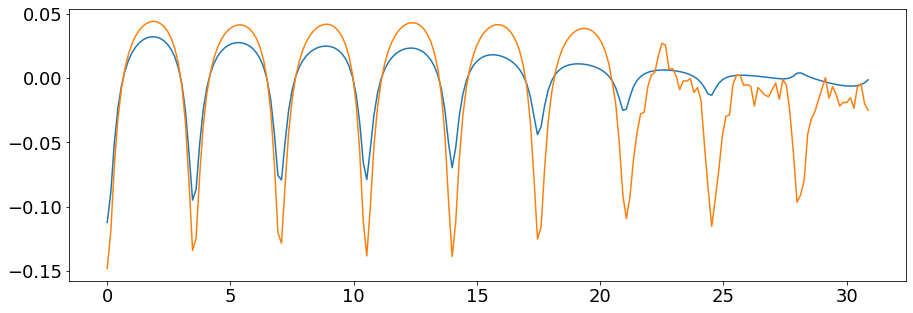

In [0]:
plt.figure(figsize=(15, 5))
plt.plot(m_data['t'], m_data['Vx'])
plt.plot(m_data['t'], m_data['Vx_sim'])